# phaw_5.1 Genome Annotation Scripts
This notebook stores various scripts used for generating and analyzing genome annotation datasets.

## Library loading

In [3]:
import pandas as pd
pd.options.display.max_colwidth = 100
from IPython.display import display
import os
import warnings
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import math

plt.rcParams.update(plt.rcParamsDefault)
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
plt.rcParams.update(new_rc_params)

sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

## Generate recording file
Generates a .tsv file for recording manual annotations.

In [292]:
#Loads in the original PhRef5and3RACE.gff and converts it into a recording format for manual annotations
gff_load = 'PhRef5and3RACE.gff'
gff_df = pd.read_csv('~/Labwork/Bioinformatics/Transcripts/' + gff_load, sep = '\t', skiprows = 2, header = None)
gff_df = gff_df[gff_df[0] != '###']
gff_df['IGV_address'] = gff_df[0] + ':' + gff_df[3].astype(int).astype(str) + '-' + gff_df[4].astype(int).astype(str)
gff_df['gene_name'] = gff_df[8].apply(lambda x: x.split(';')[1].replace('Name=', ''))

gff_df.to_csv('~/Labwork/Bioinformatics/Transcripts/' + gff_load.replace('.gff', '.tsv'), sep = '\t')
display(gff_df)

recording_df = False

if recording_df == True:
    gff_df_recording = gff_df[['gene_name', 8, 'IGV_address']]
    gff_df_recording = gff_df_recording[gff_df_recording[8].str.contains('Parent') == False]
    gff_df_recording.to_csv('~/Labwork/Bioinformatics/Transcripts/' + gff_load.replace('.gff', '_recording.tsv'), sep = '\t')
    display(gff_df_recording)

,0,1,2,3,4,5,6,7,8,IGV_address,gene_name
0,phaw_50.283869f,phaw_5.0,gene,2146785.0,2165201.0,.,-,.,ID=scratchscrtmRNAcompletecds.path1;Name=scratchscrtmRNAcompletecds,phaw_50.283869f:2146785-2165201,scratchscrtmRNAcompletecds
1,phaw_50.283869f,phaw_5.0,mRNA,2146785.0,2165201.0,.,-,.,ID=scratchscrtmRNAcompletecds.mrna1;Name=scratchscrtmRNAcompletecds;Parent=scratchscrtmRNAcomple...,phaw_50.283869f:2146785-2165201,scratchscrtmRNAcompletecds
2,phaw_50.283869f,phaw_5.0,exon,2164325.0,2165201.0,100,-,.,ID=scratchscrtmRNAcompletecds.mrna1.exon1;Name=scratchscrtmRNAcompletecds;Parent=scratchscrtmRNA...,phaw_50.283869f:2164325-2165201,scratchscrtmRNAcompletecds
3,phaw_50.283869f,phaw_5.0,exon,2146785.0,2146844.0,100,-,.,ID=scratchscrtmRNAcompletecds.mrna1.exon2;Name=scratchscrtmRNAcompletecds;Parent=scratchscrtmRNA...,phaw_50.283869f:2146785-2146844,scratchscrtmRNAcompletecds
4,phaw_50.283869f,phaw_5.0,CDS,2164325.0,2165201.0,100,-,0,ID=scratchscrtmRNAcompletecds.mrna1.cds1;Name=scratchscrtmRNAcompletecds;Parent=scratchscrtmRNAc...,phaw_50.283869f:2164325-2165201,scratchscrtmRNAcompletecds
...,...,...,...,...,...,...,...,...,...,...,...
1438,phaw_50.283862b,phaw_5.0,CDS,3091885.0,3092014.0,99,-,0,ID=wntb.mrna1.cds2;Name=wntb;Parent=wntb.mrna1;Target=wntb 518 647 +,phaw_50.283862b:3091885-3092014,wntb
1439,phaw_50.283862b,phaw_5.0,CDS,3061329.0,3061509.0,98,-,1,ID=wntb.mrna1.cds3;Name=wntb;Parent=wntb.mrna1;Target=wntb 648 828 +,phaw_50.283862b:3061329-3061509,wntb
1440,phaw_50.283862b,phaw_5.0,CDS,3057728.0,3057839.0,98,-,2,ID=wntb.mrna1.cds4;Name=wntb;Parent=wntb.mrna1;Target=wntb 829 940 +,phaw_50.283862b:3057728-3057839,wntb
1441,phaw_50.283862b,phaw_5.0,CDS,3053573.0,3053675.0,99,-,0,ID=wntb.mrna1.cds5;Name=wntb;Parent=wntb.mrna1;Target=wntb 941 1043 +,phaw_50.283862b:3053573-3053675,wntb


# Process manual recording into .gff files
Takes manually added annotation and generates .gff files for comparison using bedtools

In [3]:
#After performing manual annotations, pulls out and filters data for single-copy genes
#with clear promoter peak, first exon (exon1) and last exon (exon-1)
manualannot_load = 'PhRef5and3RACE_recording_manual/PhRef5and3RACE_indices.tsv'
manualannot = pd.read_csv('~/Labwork/Bioinformatics/Parhyale_RNA-Seq/' + manualannot_load, sep = '\t', header = 0)
manualannot = manualannot[~manualannot.apply(lambda r: r.str.contains('FRAG', case=True).any(), axis=1)]
manualannot = manualannot[~manualannot.apply(lambda r: r.str.contains('DUP', case=True).any(), axis=1)]
manualannot = manualannot.dropna()

display(manualannot.head(10))
print('Final gene set length is: ', len(manualannot))

manualannot_df = False
make_gffs = False

#Outputs a cleaned manual annotation dataset with only the approved transcripts
if manualannot_df == True:
    manualannot.to_csv('~/Labwork/Bioinformatics/Parhyale_RNA-Seq/' + manualannot_load.replace('.tsv', '_clean.tsv'), sep = '\t', index = False)

#Generates GFF files for all of the peaks in each of the three data types:
#pro_peak, exon1, and exon-1

#dummy variable to collect all the datatypes
peaks_container = pd.DataFrame()

#iterate through datatypes to create new DataFrames for each
for regiontype in ['pro_peak_address', 'exon1_address', 'exon-1_address']:
    peaks = pd.DataFrame({0: manualannot[regiontype].str.split(':', expand=True)[0],
                              1: 'phaw_5.0',
                              2: regiontype.replace('_address', ''),
                              3: manualannot[regiontype].str.split(':', expand=True)[1].str.split('-', expand = True)[0].str.replace(',', ''),
                              4: manualannot[regiontype].str.split(':', expand=True)[1].str.split('-', expand = True)[1].str.replace(',', ''),
                              5: '.',
                              6: manualannot['Strand'],
                              7: '.',
                              8: 'ID=' + manualannot['gene_name'].astype('str') + '_' + regiontype.replace('_address', '')
                             })
    
    #adds finished table to a container containing all three datatypes
    peaks_container = peaks_container.append(peaks)
    if make_gffs == True:
        peaks.to_csv('~/Labwork/Bioinformatics/Parhyale_RNA-Seq/' + manualannot_load.replace('indices.tsv', regiontype.replace('_address', '') + '.gff'), sep = '\t', index = False, header = None)

#cleans up the index of the dummy variable and then displays it        
peaks_container.reset_index(drop = True, inplace = True)
display(peaks_container)

#outputs a single GFF file containing all three of the datatypes together
if make_gffs == True:
    peaks_container.to_csv('~/Labwork/Bioinformatics/Parhyale_RNA-Seq/PhRef5and3RACE_recording_manual/Manualannot_alltypes.gff', sep = '\t', index = False, header = None)

,gene_name,8,IGV_address,Strand,pro_peak_address,exon1_address,exon-1_address
0,snail3proteinmRNApartialcds,ID=snail3proteinmRNApartialcds.path1;Name=snail3proteinmRNApartialcds,phaw_50.283864b:30526-33704,+,phaw_50.283864b:25948-26939,"phaw_50.283864b:26,453-26,990","phaw_50.283864b:29,154-33,680"
1,snail1proteinmRNAcompletecds,ID=snail1proteinmRNAcompletecds.path1;Name=snail1proteinmRNAcompletecds,phaw_50.283864b:142369-144224,+,phaw_50.283864b:141402-144143,"phaw_50.283864b:142,367-144,208","phaw_50.283864b:142,367-144,208"
2,scratchscrtmRNAcompletecds,ID=scratchscrtmRNAcompletecds.path1;Name=scratchscrtmRNAcompletecds,phaw_50.283869f:2146785-2165201,-,phaw_50.283869f:2270072-2271735,"phaw_50.283869f:2,270,060-2,271,025","phaw_50.283869f:2,146,761-2,150,484"
3,scallopedproteinsdgene,ID=scallopedproteinsdgene.path1;Name=scallopedproteinsdgene,phaw_50.007301a:763757-786495,-,phaw_50.007301a:920698-921986,"phaw_50.007301a:921,178-921,537","phaw_50.007301a:762,031-762,973"
4,snail2proteinmRNApartialcds,ID=snail2proteinmRNApartialcds.path1;Name=snail2proteinmRNApartialcds,phaw_50.283864b:718097-721779,+,phaw_50.283864b:713312-713863,"phaw_50.283864b:713,632-713,751","phaw_50.283864b:717,219-721,810"
5,extradenticleproteinexdgene,ID=extradenticleproteinexdgene.path1;Name=extradenticleproteinexdgene,phaw_50.283468a:8063095-8076889,+,phaw_50.283468a:7799208-7800212,"phaw_50.283468a:7,799,472-7,800,056","phaw_50.283468a:8,097,516-8,101,622"
6,prosperoproteinmRNApartialcds,ID=prosperoproteinmRNApartialcds.path1;Name=prosperoproteinmRNApartialcds,phaw_50.283875a:6013042-6035299,+,phaw_50.283875a:5998087-5999786,"phaw_50.283875a:5,998,945-6,001,387","phaw_50.283875a:6,034,691-6,038,907"
9,homothoraxproteinhthgene,ID=homothoraxproteinhthgene.path1;Name=homothoraxproteinhthgene,phaw_50.283815b:16274653-16574076,-,phaw_50.283815b:16604672-16607172,"phaw_50.283815b:16,605,602-16,606,372","phaw_50.283815b:16,168,073-16,170,044"
15,oddskipped2proteinmRNAcompletecds,ID=oddskipped2proteinmRNAcompletecds.path1;Name=oddskipped2proteinmRNAcompletecds,phaw_50.000289b:10228579-10229883,+,phaw_50.000289b:10227897-10229524,"phaw_50.000289b:10,228,565-10,229,900","phaw_50.000289b:10,228,565-10,229,900"
16,KNIRPS1kni1mRNAcompletecds,ID=KNIRPS1kni1mRNAcompletecds.path1;Name=KNIRPS1kni1mRNAcompletecds,phaw_50.283866:9026088-9035313,+,phaw_50.283866:9025431-9026438,"phaw_50.283866:9,026,082-9,026,813","phaw_50.283866:9,034,022-9,037,291"


Final gene set length is:  55


,0,1,2,3,4,5,6,7,8
0,phaw_50.283864b,phaw_5.0,pro_peak,25948,26939,.,+,.,ID=snail3proteinmRNApartialcds_pro_peak
1,phaw_50.283864b,phaw_5.0,pro_peak,141402,144143,.,+,.,ID=snail1proteinmRNAcompletecds_pro_peak
2,phaw_50.283869f,phaw_5.0,pro_peak,2270072,2271735,.,-,.,ID=scratchscrtmRNAcompletecds_pro_peak
3,phaw_50.007301a,phaw_5.0,pro_peak,920698,921986,.,-,.,ID=scallopedproteinsdgene_pro_peak
4,phaw_50.283864b,phaw_5.0,pro_peak,713312,713863,.,+,.,ID=snail2proteinmRNApartialcds_pro_peak
...,...,...,...,...,...,...,...,...,...
160,phaw_50.282695a,phaw_5.0,exon-1,24687725,24692898,.,+,.,ID=AbdominalBisoform1cloneJ7b11_exon-1
161,phaw_50.282695a,phaw_5.0,exon-1,27151053,27152222,.,+,.,ID=DeformedcDNAcloneFLb2_exon-1
162,phaw_50.000289b,phaw_5.0,exon-1,9791530,9795846,.,+,.,ID=odd3_exon-1
163,phaw_50.283028b,phaw_5.0,exon-1,1776166,1784663,.,-,.,ID=runt2_exon-1


# Perform bedtools intersect
Generates bedtools intersect results of manual recording .gff against different gene annotation .gffs

In [4]:
#Specify which models to compare to the manually annotated peaks
models_list = ['PhRef5and3RACE.gff', 
               'Phaw.Kao.annotations.transcript.sorted.gff', 
               'Trinity_S21.sorted.gff',
               'Par-haw_Nanopore_stringtie2.gff',
               'Par-haw_Nanopore_stringtie2_mix.gff',
               'phaw_5.0_eggnog_gene_annotations.sorted.gff',
               'ParhyaleTranscriptome.ReAnnotated.reformatted4.sorted.gff',
               'mikado.loci.gff']

#Specify the location of the final manual annotation file
manualannotloc = '~/Labwork/Bioinformatics/Parhyale_RNA-Seq/PhRef5and3RACE_recording_manual/Manualannot_alltypes.gff'

#Iterate through models and use bedtools to detect overlaps
for model in models_list:
    modelloc = '~/Labwork/Bioinformatics/Transcripts/' + model
    outputloc = '~/Labwork/Bioinformatics/Transcripts/' + model.replace('.gff', '_manualannot.tsv')
    !/usr/local/bin/bedtools intersect -s -wo -a $modelloc -b $manualannotloc > $outputloc

    #Display first two lines of each overlap file
    output = pd.read_csv(outputloc, sep = '\t', header = None)
    display(output.head(2))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,phaw_50.283869f,phaw_5.0,gene,2146785,2165201,.,-,.,ID=scratchscrtmRNAcompletecds.path1;Name=scratchscrtmRNAcompletecds,phaw_50.283869f,phaw_5.0,exon-1,2146761,2150484,.,-,.,ID=scratchscrtmRNAcompletecds_exon-1,3700
1,phaw_50.283869f,phaw_5.0,mRNA,2146785,2165201,.,-,.,ID=scratchscrtmRNAcompletecds.mrna1;Name=scratchscrtmRNAcompletecds;Parent=scratchscrtmRNAcomple...,phaw_50.283869f,phaw_5.0,exon-1,2146761,2150484,.,-,.,ID=scratchscrtmRNAcompletecds_exon-1,3700


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,phaw_50.000081a,phaw_5.0,gene,2243875,2353479,.,+,.,ID=mikado.phaw_50.000081aG168.1.path1;Name=mikado.phaw_50.000081aG168.1,phaw_50.000081a,phaw_5.0,pro_peak,2243466,2244527,.,+,.,ID=spi5RACElargefragment3RACE_pro_peak,653
1,phaw_50.000081a,phaw_5.0,gene,2243875,2353479,.,+,.,ID=mikado.phaw_50.000081aG168.1.path1;Name=mikado.phaw_50.000081aG168.1,phaw_50.000081a,phaw_5.0,exon1,2243861,2244179,.,+,.,ID=spi5RACElargefragment3RACE_exon1,305


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,phaw_50.000081a,phaw_5.0,gene,2239477,2289557,.,+,.,ID=TRINITY_DN67806_c3_g1_i4.path1;Name=TRINITY_DN67806_c3_g1_i4,phaw_50.000081a,phaw_5.0,pro_peak,2243466,2244527,.,+,.,ID=spi5RACElargefragment3RACE_pro_peak,1062
1,phaw_50.000081a,phaw_5.0,gene,2239477,2289557,.,+,.,ID=TRINITY_DN67806_c3_g1_i4.path1;Name=TRINITY_DN67806_c3_g1_i4,phaw_50.000081a,phaw_5.0,exon1,2243861,2244179,.,+,.,ID=spi5RACElargefragment3RACE_exon1,319


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,phaw_50.000081a,StringTie,transcript,2243867,2282183,1000,+,.,ID=STRG.117.1;geneID=STRG.117,phaw_50.000081a,phaw_5.0,pro_peak,2243466,2244527,.,+,.,ID=spi5RACElargefragment3RACE_pro_peak,661
1,phaw_50.000081a,StringTie,transcript,2243867,2282183,1000,+,.,ID=STRG.117.1;geneID=STRG.117,phaw_50.000081a,phaw_5.0,exon1,2243861,2244179,.,+,.,ID=spi5RACElargefragment3RACE_exon1,313


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,phaw_50.000081a,StringTie,transcript,2239403,2291822,1000,+,.,ID=STRG.154.1;geneID=STRG.154,phaw_50.000081a,phaw_5.0,pro_peak,2243466,2244527,.,+,.,ID=spi5RACElargefragment3RACE_pro_peak,1062
1,phaw_50.000081a,StringTie,transcript,2239403,2291822,1000,+,.,ID=STRG.154.1;geneID=STRG.154,phaw_50.000081a,phaw_5.0,exon1,2243861,2244179,.,+,.,ID=spi5RACElargefragment3RACE_exon1,319


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,phaw_50.000081a,maker,mRNA,2278477,2392013,.,+,.,ID=maker-phaw_50.000081a-snap-gene-9.176-mRNA-2;Parent=maker-phaw_50.000081a-snap-gene-9.176;Nam...,phaw_50.000081a,phaw_5.0,exon-1,2347070,2349001,.,+,.,ID=spi5RACElargefragment3RACE_exon-1,1932
1,phaw_50.000081a,maker,mRNA,2278477,2392013,.,+,.,ID=maker-phaw_50.000081a-snap-gene-9.176-mRNA-1;Parent=maker-phaw_50.000081a-snap-gene-9.176;Nam...,phaw_50.000081a,phaw_5.0,exon-1,2347070,2349001,.,+,.,ID=spi5RACElargefragment3RACE_exon-1,1932


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,phaw_50.000081a,phaw_5.0,gene,2243877,2348876,.,+,.,ID=comp171893_c0_seq1_.path1;Name=comp171893_c0_seq1_,phaw_50.000081a,phaw_5.0,pro_peak,2243466,2244527,.,+,.,ID=spi5RACElargefragment3RACE_pro_peak,651
1,phaw_50.000081a,phaw_5.0,gene,2243877,2348876,.,+,.,ID=comp171893_c0_seq1_.path1;Name=comp171893_c0_seq1_,phaw_50.000081a,phaw_5.0,exon1,2243861,2244179,.,+,.,ID=spi5RACElargefragment3RACE_exon1,303


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,phaw_50.000081a,Mikado_loci,superlocus,2243867,2789062,.,+,.,ID=Mikado_superlocus:phaw_50.000081a+:2243867-2789062;Name=superlocus:phaw_50.000081a+:2243867-2...,phaw_50.000081a,phaw_5.0,pro_peak,2243466,2244527,.,+,.,ID=spi5RACElargefragment3RACE_pro_peak,661
1,phaw_50.000081a,Mikado_loci,superlocus,2243867,2789062,.,+,.,ID=Mikado_superlocus:phaw_50.000081a+:2243867-2789062;Name=superlocus:phaw_50.000081a+:2243867-2...,phaw_50.000081a,phaw_5.0,exon1,2243861,2244179,.,+,.,ID=spi5RACElargefragment3RACE_exon1,313


# Process downstream data to generate summary statistics
Calculates promoter peak overlap, exon1 overlap, and exon-1 overlap.

In [5]:
#Specify which output files from bedtools intersect to parse for further analysis
output_list = ['PhRef5and3RACE_manualannot.tsv', 
               'Trinity_S21.sorted_manualannot.tsv', 
               'Par-haw_Nanopore_stringtie2_manualannot.tsv',
               'Par-haw_Nanopore_stringtie2_mix_manualannot.tsv',
               'Phaw.Kao.annotations.transcript.sorted_manualannot.tsv', 
               'phaw_5.0_eggnog_gene_annotations.sorted_manualannot.tsv',
               'ParhyaleTranscriptome.ReAnnotated.reformatted4.sorted_manualannot.tsv',
               'mikado.loci_manualannot.tsv']

#Specify the original peaks file location
original_peaks_file = '~/Labwork/Bioinformatics/Parhyale_RNA-Seq/PhRef5and3RACE_recording_manual/Manualannot_alltypes.gff'
original_peaks_df = pd.read_csv(original_peaks_file, sep = '\t', header = None)
original_peaks_df.index = original_peaks_df[0].astype('str') + ':' + original_peaks_df[3].astype('str') + '-' + original_peaks_df[4].astype('str')

#Make empty cells to later modify as you iterate through dataset
original_peaks_df[['pro_peak_overlap', 'exon1_overlap', 'exon-1_overlap', 'split']] = ''
#original_peaks_df = original_peaks_df[original_peaks_df[8].str.contains('snail1')]

#Dummy variables for for loops below
flipflopper = 0
output_dict = {file:'' for file in output_list}

#Iterates through outputfiles and analyzes them
for outputfile in output_list:
    outputloc = '~/Labwork/Bioinformatics/Transcripts/' + outputfile
    output_df = pd.read_csv(outputloc, sep = '\t', header = None)
    output_df['keys'] = output_df[9].astype('str') + ':' + output_df[12].astype('str') + '-' + output_df[13].astype('str')
    
    #Iterates through original indexes (e.g. peak IDs) from original peaks file
    for index in original_peaks_df.index:
        
        #for each peak type (pro-peak, exon1, exon-1 separately, evaluate whether it is good)
        test_df = output_df[output_df['keys'] == index]
        test_df = test_df[test_df[2] == 'exon']
        
        datatype = str(original_peaks_df.loc[index][2])
        
        #Checks if there is any model overlapping with the promoter peak
        #Marks 0 if no, 1 if yes
        if datatype == 'pro_peak':
            if len(test_df) == 0:
                original_peaks_df.loc[index, 'pro_peak_overlap'] = 0
            else:
                original_peaks_df.loc[index, 'pro_peak_overlap'] = 1
        
        #Checks and outputs for fraction overlap with exon1 peak
        if datatype == 'exon1':
            if len(test_df) == 0:
                original_peaks_df.loc[index, 'exon1_overlap'] = 0
            else:
                region_length = original_peaks_df.loc[index, 4] - original_peaks_df.loc[index, 3]
                overlap_fraction = max(test_df[18].values / region_length)
                original_peaks_df.loc[index, 'exon1_overlap'] = overlap_fraction
        
        #Checks and outputs for fraction overlap with exon-1 peak
        if datatype == 'exon-1':
            if len(test_df) == 0:
                original_peaks_df.loc[index, 'exon-1_overlap'] = 0
            else:
                region_length = original_peaks_df.loc[index, 4] - original_peaks_df.loc[index, 3]
                overlap_fraction = max(test_df[18].values / region_length)
                original_peaks_df.loc[index, 'exon-1_overlap'] = overlap_fraction
    
    #Inputs data into appropriate cells of index
    original_peaks_df['gene_name'] = original_peaks_df[8].apply(lambda x: x.split('=')[1].split('_')[0])
    dummy_pro_peak = original_peaks_df[original_peaks_df[2] == 'pro_peak'][['gene_name', 'pro_peak_overlap']]
    dummy_exon1 = original_peaks_df[original_peaks_df[2] == 'exon1'][['gene_name', 'exon1_overlap']]
    dummy_exonminus1 = original_peaks_df[original_peaks_df[2] == 'exon-1'][['gene_name', 'exon-1_overlap']]
    
    #Generates merged table of all three datatype results
    summary_df = dummy_pro_peak.merge(dummy_exon1, left_on = 'gene_name', right_on = 'gene_name')
    summary_df = summary_df.merge(dummy_exonminus1, left_on = 'gene_name', right_on = 'gene_name')
    summary_df = summary_df[summary_df['exon1_overlap'] != '']
    summary_df.reset_index(inplace=True)
    
    output_dict[outputfile] = summary_df

# Categorization of gene models
Performs categorical analysis to determine whether gene model contains single, split, exon1 only, or exon-1 only models.

In [28]:
#Specify which output files from bedtools intersect to parse for further analysis
output_list = ['PhRef5and3RACE_manualannot.tsv', 
               'Trinity_S21.sorted_manualannot.tsv', 
               'Par-haw_Nanopore_stringtie2_manualannot.tsv',
               'Par-haw_Nanopore_stringtie2_mix_manualannot.tsv',
               'Phaw.Kao.annotations.transcript.sorted_manualannot.tsv', 
               'phaw_5.0_eggnog_gene_annotations.sorted_manualannot.tsv',
               'ParhyaleTranscriptome.ReAnnotated.reformatted4.sorted_manualannot.tsv',
               'mikado.loci_manualannot.tsv']

#Specify which are the highest-level parent data types accepted
#This approach ignores subdivisions of exons/introns within each model
searchfor = ['gene', 'mRNA', 'transcript']

#Iterates through outputfiles and analyzes them
for outputfile in output_list:
    outputloc = '~/Labwork/Bioinformatics/Transcripts/' + outputfile
    output_df = pd.read_csv(outputloc, sep = '\t', header = None)
    output_df['keys'] = output_df[9].astype('str') + ':' + output_df[12].astype('str') + '-' + output_df[13].astype('str')
    
    output_dict[outputfile].index = output_dict[outputfile]['gene_name']
    output_dict[outputfile]['single_model_spans'] = 0
    output_dict[outputfile]['split_models'] = 0
    output_dict[outputfile]['exon1_only'] = 0
    output_dict[outputfile]['exon-1_only'] = 0
    output_dict[outputfile]['no_model'] = 0
    
    #Checks for each gene name whether there is a model that fits particular parameters
    for gene in output_dict[outputfile]['gene_name']:
        match_df = output_df[output_df[17].str.contains(gene)]
        match_genes = match_df[match_df[2].str.contains('|'.join(searchfor))]
        match_tidy = match_genes[[11, 8]]
        match_tidy1 = match_tidy.groupby(8)[11].apply(lambda x: ','.join(x)).reset_index()
        
        overlaps_both = 0
        overlaps_exon1 = 0
        overlaps_exonminus1 = 0
        
        for model in match_tidy1[11]:
            if 'exon1' in model:
                overlaps_exon1 += 1
            if 'exon-1' in model:
                overlaps_exonminus1 += 1
            if all(['exon1' in model, 'exon-1' in model]):
                overlaps_both += 1
        
        #Uses boolean logic to determine different possible classifications
        if overlaps_both > 0:
            output_dict[outputfile].loc[gene, 'single_model_spans'] = 1
        if overlaps_both == 0 and overlaps_exon1 > 0 and overlaps_exonminus1 > 0:
            output_dict[outputfile].loc[gene, 'split_models'] = 1
        if overlaps_both == 0 and overlaps_exon1 > 0 and overlaps_exonminus1 == 0:
            output_dict[outputfile].loc[gene, 'exon1_only'] = 1
        if overlaps_both == 0 and overlaps_exon1 == 0 and overlaps_exonminus1 > 0:
            output_dict[outputfile].loc[gene, 'exon-1_only'] = 1
        if overlaps_both == 0 and overlaps_exon1 == 0 and overlaps_exonminus1 == 0:
            output_dict[outputfile].loc[gene, 'no_model'] = 1

display(len(output_dict['PhRef5and3RACE_manualannot.tsv']['index']))
display(output_dict['PhRef5and3RACE_manualannot.tsv']['index'])

49

gene_name
snail3proteinmRNApartialcds                 0
scratchscrtmRNAcompletecds                  2
scallopedproteinsdgene                      3
snail2proteinmRNApartialcds                 4
extradenticleproteinexdgene                 5
prosperoproteinmRNApartialcds               6
homothoraxproteinhthgene                    7
KNIRPS1kni1mRNAcompletecds                  9
KNIRPS2kni2mRNAcompletecds                 10
Sp69protein                                11
deltaproteinmRNAcompletecds                12
betacateninmRNAcompletecds                 13
shortgastrulationproteinmRNAcompletecds    14
rho5RACEvariant2                           15
Pax371proteinmRNAcompletecds               16
notchproteinmRNAcompletecds                17
rho5RACEvariant1                           18
pdm                                        19
optixmRNAcompletecds                       20
ash26F                                     21
Par6                                       22
pnt3RACE                

# Generates summary figures for overlap statistics

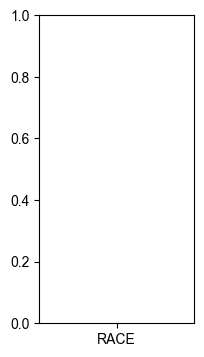

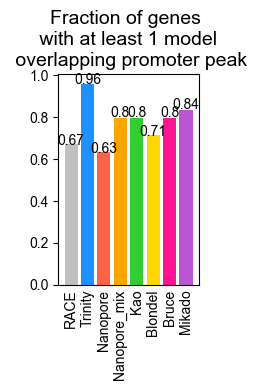

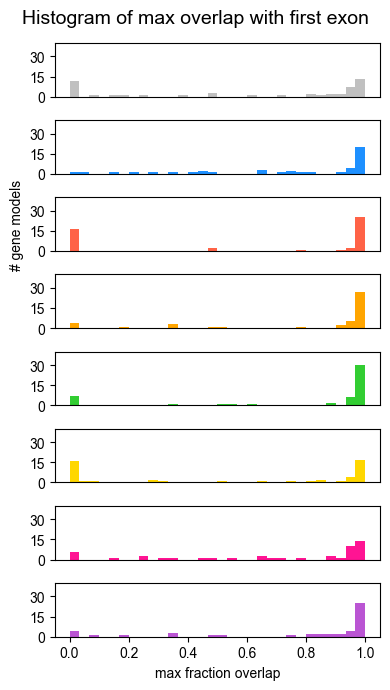

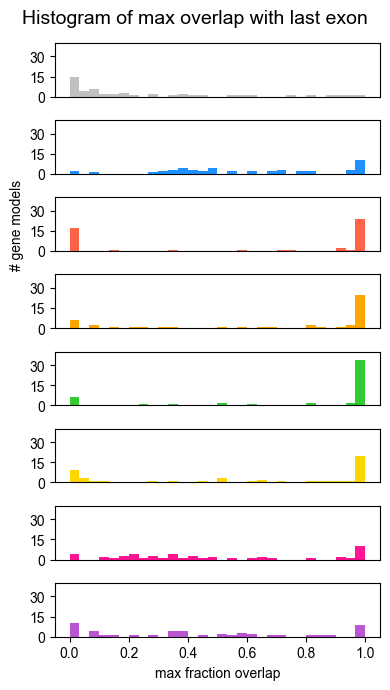

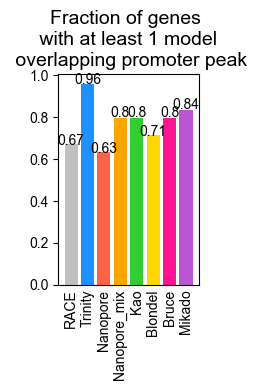

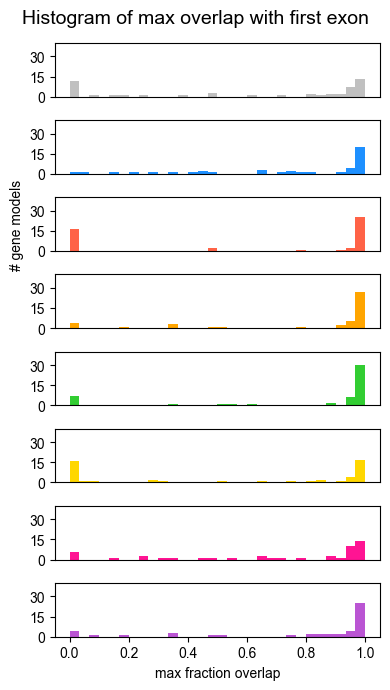

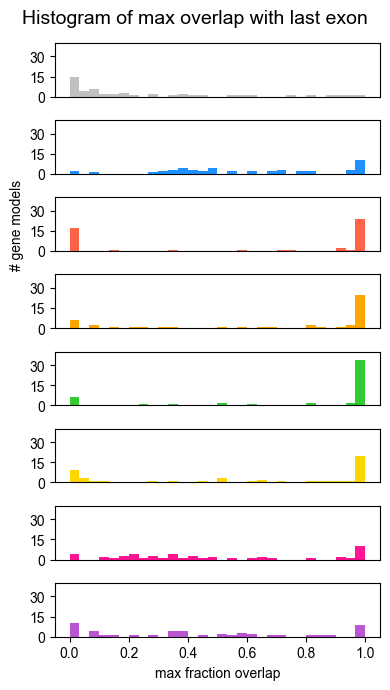

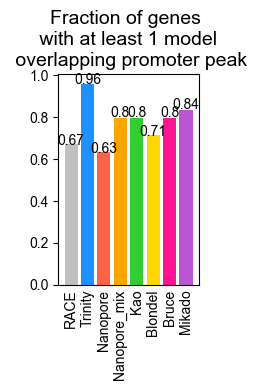

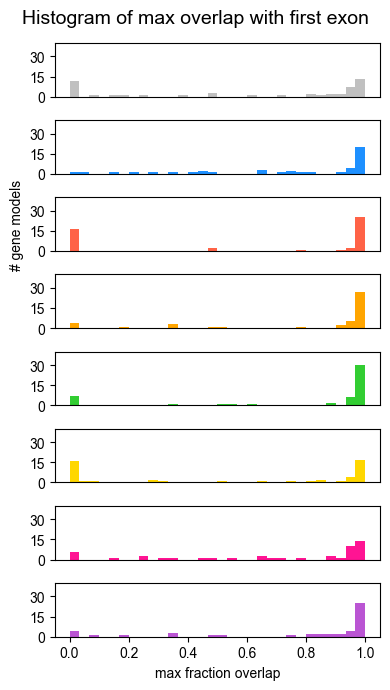

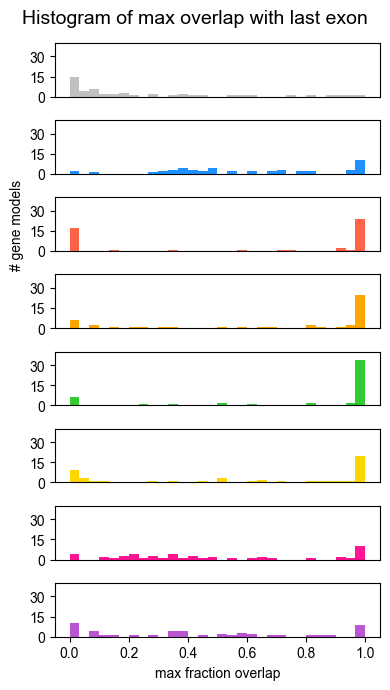

In [10]:
#Checks whether you want to save figures or not, and specifies a prefix
savefigs = False
prefix = '20210731'
outfmt = '.svg'

#Specify which attributes to look for
attributes_list = ['pro_peak_overlap', 'exon1_overlap', 'exon-1_overlap']

#Specify nicknames for the datasets (in order)
names = ['RACE', 'Trinity', 'Nanopore', 'Nanopore_mix', 'Kao',  'Blondel', 'Bruce', 'Mikado']

#Specify colors for the datasets (in order)
colors = ['silver', 'dodgerblue', 'tomato', 'orange', 'limegreen', 'gold', 'deeppink', 'mediumorchid']

#Dictionary comparing output filename to nickname
namedict = {
    'PhRef5and3RACE_manualannot.tsv': 'RACE',  
    'Trinity_S21.sorted_manualannot.tsv': 'Trinity', 
    #'Phaw_DAS_Trinity-GG_hisat2.sorted_manualannot.tsv': 'Trinity_GG',
    'Par-haw_Nanopore_stringtie2_manualannot.tsv': 'Nanopore',
    'Par-haw_Nanopore_stringtie2_mix_manualannot.tsv': 'Nanopore_mix',
    'Phaw.Kao.annotations.transcript.sorted_manualannot.tsv': 'Kao',
    'phaw_5.0_eggnog_gene_annotations.sorted_manualannot.tsv': 'Blondel',
    'ParhyaleTranscriptome.ReAnnotated.reformatted4.sorted_manualannot.tsv':'Bruce',
    'mikado.loci_manualannot.tsv':'Mikado'
}

#Dictionary specifying number to color
colordict = dict(zip([i for i in np.arange(len(colors))],colors))

#Dummy variable for for loops below
reformatted_dict = {i:'' for i in attributes_list}

#Rotates and combines all data across all models into 1 dataframe
for attribute in attributes_list:
    dummy = {i:'' for i in output_dict.keys()}
    for dictionary in output_dict:
        dummy[dictionary] = output_dict[dictionary][attribute]
    dummy_df = pd.DataFrame(dummy)
    reformatted_dict[attribute] = dummy_df

#Calculates fraction of genes in each model that have any pro_peak_overlap
total_fraction = {i:'' for i in reformatted_dict['pro_peak_overlap'].columns}
for column in reformatted_dict['pro_peak_overlap'].columns:
    total = reformatted_dict['pro_peak_overlap'][column].sum()
    total_fraction[column] = total / len(reformatted_dict['pro_peak_overlap'])

#Plot bar chart of fraction of genes where at least one model overlaps promoter peak
fig1 = plt.figure(figsize=(2, 4))
plt.bar(names, total_fraction.values(), color=colors)
plt.xticks(rotation = 90)
plt.title('Fraction of genes \n with at least 1 model \n overlapping promoter peak', fontsize = 14)
addlabels(names, np.round(list(total_fraction.values()), 2))
plt.tick_params(axis='x', which='both', length=0)
plt.tight_layout()

if savefigs == True:
    plt.savefig(prefix + "_Fig1_genemodel_promoter_overlap" + outfmt)

#Plot histogram of max gene model percentage overlap with first exon
fig2 = plt.figure(figsize=(4, 7))
i = 1
for column in reformatted_dict['exon1_overlap']:
    subplot = plt.subplot(len(namedict), 1, i)
    plt.hist(reformatted_dict['exon1_overlap'][column], bins=30, range=[0, 1], label=namedict[column], color = colordict[i - 1])
    plt.axis([-0.05, 1.05, 0, 40])
    plt.yticks([0, 15, 30])
    if i == 3:
        plt.ylabel("# gene models")
    plt.xlabel("max fraction overlap")
    if i < len(names):
        subplot.set_xticklabels([])
        plt.xlabel('')
        plt.tick_params(axis='x', which='both', length=0)
    i += 1
plt.suptitle("Histogram of max overlap with first exon", fontsize = 14)
plt.tight_layout()

if savefigs == True:
    plt.savefig(prefix + "_Fig2_genemodel_exon1_histogram" + outfmt)
plt.show()

#Plot histogram of max gene model percentage overlap with last exon
fig3 = plt.figure(figsize=(4, 7))
i = 1
for column in reformatted_dict['exon-1_overlap']:
    subplot = plt.subplot(len(namedict), 1, i)
    plt.hist(reformatted_dict['exon-1_overlap'][column], bins=30, range=[0, 1],label=namedict[column], color = colordict[i - 1])
    plt.axis([-0.05, 1.05, 0, 40])
    plt.yticks([0, 15, 30])
    if i == 3:
        plt.ylabel("# gene models")
    plt.xlabel("max fraction overlap")
    if i < len(names):
        subplot.set_xticklabels([])
        plt.xlabel('')
        plt.tick_params(axis='x', which='both', length=0)
    i += 1
plt.suptitle("Histogram of max overlap with last exon", fontsize = 14)
plt.tight_layout()

if savefigs == True:
    plt.savefig(prefix + "_Fig3_genemodel_exonminus1_histogram" + outfmt)
    
plt.show()

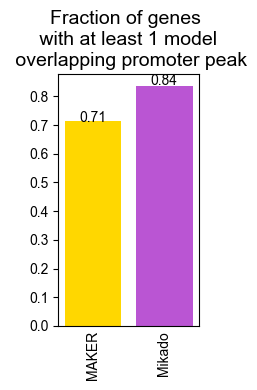

In [11]:
#Checks whether you want to save figures or not, and specifies a prefix
savefigs = False
prefix = '20211025'
outfmt = '.svg'

#Specify which attributes to look for
attributes_list = ['pro_peak_overlap', 'exon1_overlap', 'exon-1_overlap']

#Specify nicknames for the datasets (in order)
names = ['RACE', 'Trinity', 'Nanopore', 'Nanopore_mix', 'Kao',  'Blondel', 'Bruce', 'Mikado']

#Specify colors for the datasets (in order)
colors = ['silver', 'dodgerblue', 'tomato', 'orange', 'limegreen', 'gold', 'deeppink', 'mediumorchid']

#Dictionary comparing output filename to nickname
namedict = {
    'PhRef5and3RACE_manualannot.tsv': 'RACE',  
    'Trinity_S21.sorted_manualannot.tsv': 'Trinity', 
    'Par-haw_Nanopore_stringtie2_manualannot.tsv': 'Nanopore',
    'Par-haw_Nanopore_stringtie2_mix_manualannot.tsv': 'Nanopore_mix',
    'Phaw.Kao.annotations.transcript.sorted_manualannot.tsv': 'Kao',
    'phaw_5.0_eggnog_gene_annotations.sorted_manualannot.tsv': 'Blondel',
    'ParhyaleTranscriptome.ReAnnotated.reformatted4.sorted_manualannot.tsv':'Bruce',
    'mikado.loci_manualannot.tsv':'Mikado'
}

#Dictionary specifying number to color
colordict = dict(zip([i for i in np.arange(len(colors))],colors))

#Dummy variable for for loops below
reformatted_dict = {i:'' for i in attributes_list}

#Rotates and combines all data across all models into 1 dataframe
for attribute in attributes_list:
    dummy = {i:'' for i in output_dict.keys()}
    for dictionary in output_dict:
        dummy[dictionary] = output_dict[dictionary][attribute]
    dummy_df = pd.DataFrame(dummy)
    reformatted_dict[attribute] = dummy_df

#Calculates fraction of genes in each model that have any pro_peak_overlap
total_fraction = {i:'' for i in reformatted_dict['pro_peak_overlap'].columns}
for column in reformatted_dict['pro_peak_overlap'].columns:
    total = reformatted_dict['pro_peak_overlap'][column].sum()
    total_fraction[column] = total / len(reformatted_dict['pro_peak_overlap'])

total_fraction = {'MAKER': total_fraction['phaw_5.0_eggnog_gene_annotations.sorted_manualannot.tsv'],
                 'Mikado': total_fraction['mikado.loci_manualannot.tsv']}

colors = ['gold', 'mediumorchid']

#Plot bar chart of fraction of genes where at least one model overlaps promoter peak
fig1 = plt.figure(figsize=(2, 4))
plt.bar(total_fraction.keys(), total_fraction.values(), color=colors)
plt.xticks(rotation = 90)
plt.title('Fraction of genes \n with at least 1 model \n overlapping promoter peak', fontsize = 14)
addlabels(total_fraction.keys(), np.round(list(total_fraction.values()), 2))
plt.tick_params(axis='x', which='both', length=0)
plt.tight_layout()

if savefigs == True:
    plt.savefig(prefix + "_Fig1_genemodel_promoter_overlap" + outfmt)
plt.show()

,Blondel,Mikado
total_fraction,0.714286,0.836735
single_model_spans,0.551020,0.734694
split_models,0.102041,0.040816
exon1_only,0.122449,0.142857
exon-1_only,0.183673,0.081633
no_model,0.040816,0.000000


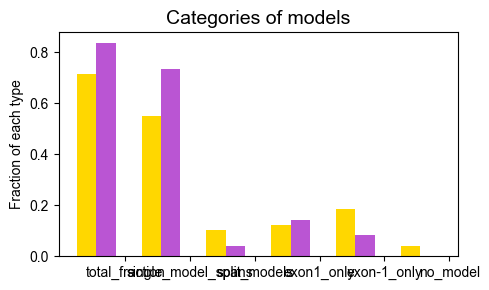

In [12]:
summaries_list = ['single_model_spans', 'split_models', 'exon1_only', 'exon-1_only', 'no_model']
summaries_desc = ['single model', 'split model', 'first exon only', 'last exon only', 'no model']
summaries_desc_shorter = summaries_desc[0:3]

#Specify nicknames for the datasets (in order)
names = ['RACE', 'Trinity', 'Nanopore', 'Nanopore_mix', 'Kao',  'Blondel', 'Bruce', 'Mikado']

#Specify colors for the datasets (in order)
colors = ['silver', 'dodgerblue', 'tomato', 'orange', 'limegreen', 'gold', 'deeppink', 'mediumorchid']

#Dictionary comparing output filename to nickname
namedict = {
    'PhRef5and3RACE_manualannot.tsv': 'RACE',  
    'Trinity_S21.sorted_manualannot.tsv': 'Trinity', 
    'Par-haw_Nanopore_stringtie2_manualannot.tsv': 'Nanopore',
    'Par-haw_Nanopore_stringtie2_mix_manualannot.tsv': 'Nanopore_mix',
    'Phaw.Kao.annotations.transcript.sorted_manualannot.tsv': 'Kao',
    'phaw_5.0_eggnog_gene_annotations.sorted_manualannot.tsv': 'Blondel',
    'ParhyaleTranscriptome.ReAnnotated.reformatted4.sorted_manualannot.tsv':'Bruce',
    'mikado.loci_manualannot.tsv':'Mikado'
}
colordict = dict(zip([i for i in np.arange(len(colors))],colors))

summary_metrics = {i:'' for i in output_dict}

collection = ''
for output in output_dict:
    temp_df = pd.DataFrame(output_dict[output][summaries_list].sum() / len(output_dict[output]))
    temp_df = temp_df.rename(columns = {0: namedict[output]})
    if type(collection) == str:
        collection = temp_df
    else:
        collection = collection.merge(temp_df, left_index = True, right_index = True)

collection = collection[['Blondel', 'Mikado']]
fractions = pd.DataFrame(dict(zip(['Blondel', 'Mikado'], total_fraction.values())), index = ['total_fraction'])
collection = fractions.append(collection)

colordict = {
    'Blondel': 'gold',
    'Mikado': 'mediumorchid'
}

display(collection)

x = np.arange(len(collection.index))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(5, 3))

i = 0
for column in collection.columns:
    j = i - 2
    rects = ax.bar(x + width * j, collection[column], width, label= column, color = colordict[column])
    i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction of each type')
ax.set_title('Categories of models', fontsize = 14)
ax.set_xticks(x)
ax.set_xticklabels(collection.index)
fig.tight_layout()

if savefigs == True:
    plt.savefig(prefix + "_genemodel_summary_categories" + outfmt)

plt.show()

# Generates summary figures for category statistics

single_model_spans    0.57
split_models          0.04
exon1_only            0.14
exon-1_only           0.14
no_model              0.10
Name: RACE, dtype: float64
single_model_spans    0.61
split_models          0.35
exon1_only            0.02
exon-1_only           0.02
no_model              0.00
Name: Trinity, dtype: float64
single_model_spans    0.55
split_models          0.27
exon1_only            0.04
exon-1_only           0.06
no_model              0.08
Name: Trinity_GG, dtype: float64
single_model_spans    0.53
split_models          0.04
exon1_only            0.10
exon-1_only           0.10
no_model              0.22
Name: Nanopore, dtype: float64
single_model_spans    0.76
split_models          0.12
exon1_only            0.04
exon-1_only           0.04
no_model              0.04
Name: Nanopore_mix, dtype: float64
single_model_spans    0.65
split_models          0.10
exon1_only            0.10
exon-1_only           0.14
no_model              0.00
Name: Kao, dtype: float64
single_m

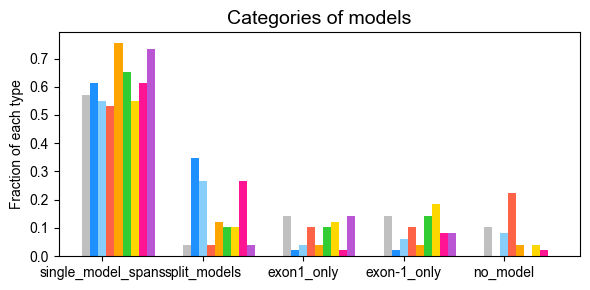

single_model_spans    0.64
split_models          0.05
exon1_only            0.16
exon-1_only           0.16
Name: RACE, dtype: float64
single_model_spans    0.61
split_models          0.35
exon1_only            0.02
exon-1_only           0.02
Name: Trinity, dtype: float64
single_model_spans    0.60
split_models          0.29
exon1_only            0.04
exon-1_only           0.07
Name: Trinity_GG, dtype: float64
single_model_spans    0.68
split_models          0.05
exon1_only            0.13
exon-1_only           0.13
Name: Nanopore, dtype: float64
single_model_spans    0.79
split_models          0.13
exon1_only            0.04
exon-1_only           0.04
Name: Nanopore_mix, dtype: float64
single_model_spans    0.65
split_models          0.10
exon1_only            0.10
exon-1_only           0.14
Name: Kao, dtype: float64
single_model_spans    0.57
split_models          0.11
exon1_only            0.13
exon-1_only           0.19
Name: Blondel, dtype: float64
single_model_spans    0.62
split

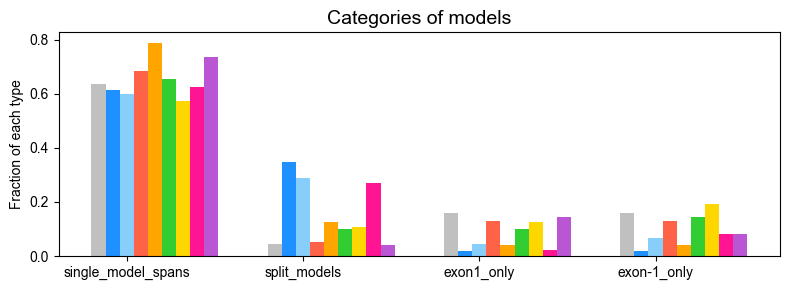

In [190]:
summaries_list = ['single_model_spans', 'split_models', 'exon1_only', 'exon-1_only', 'no_model']
summaries_desc = ['single model', 'split model', 'first exon only', 'last exon only', 'no model']
summaries_desc_shorter = summaries_desc[0:3]
#Specify nicknames for the datasets (in order)
names = ['RACE', 'Trinity', 'Trinity_GG', 'Nanopore', 'Nanopore_mix', 'Kao',  'Blondel', 'Bruce', 'Mikado']

#Specify colors for the datasets (in order)
colors = ['silver', 'dodgerblue', 'lightskyblue', 'tomato', 'orange', 'limegreen', 'gold', 'deeppink', 'mediumorchid']

#Dictionary comparing output filename to nickname
namedict = {
    'PhRef5and3RACE_manualannot.tsv': 'RACE',  
    'Trinity_S21.sorted_manualannot.tsv': 'Trinity', 
    'Phaw_DAS_Trinity-GG_hisat2.sorted_manualannot.tsv': 'Trinity_GG',
    'Par-haw_Nanopore_stringtie2_manualannot.tsv': 'Nanopore',
    'Par-haw_Nanopore_stringtie2_mix_manualannot.tsv': 'Nanopore_mix',
    'Phaw.Kao.annotations.transcript.sorted_manualannot.tsv': 'Kao',
    'phaw_5.0_eggnog_gene_annotations.sorted_manualannot.tsv': 'Blondel',
    'ParhyaleTranscriptome.ReAnnotated.reformatted4.sorted_manualannot.tsv':'Bruce',
    'mikado.loci_manualannot.tsv':'Mikado'
}
colordict = dict(zip([i for i in np.arange(len(colors))],colors))

summary_metrics = {i:'' for i in output_dict}

collection = ''
for output in output_dict:
    temp_df = pd.DataFrame(output_dict[output][summaries_list].sum() / len(output_dict[output]))
    temp_df = temp_df.rename(columns = {0: namedict[output]})
    if type(collection) == str:
        collection = temp_df
    else:
        collection = collection.merge(temp_df, left_index = True, right_index = True)

collection2 = ''
for output in output_dict:
    temp_df = pd.DataFrame(output_dict[output][summaries_list].sum() / (len(output_dict[output]) - sum(output_dict[output][summaries_list]['no_model'])))
    temp_df = temp_df.rename(columns = {0: namedict[output]})
    if type(collection2) == str:
        collection2 = temp_df
    else:
        collection2 = collection2.merge(temp_df, left_index = True, right_index = True)
collection2 = collection2.drop('no_model')
        
x = np.arange(len(collection.index))  # the label locations
width = 0.08  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 3))
i = 0
for column in collection.columns:
    j = i - 2
    rects = ax.bar(x + width * j, collection[column], width, label= column, color = colordict[i])
    print(np.round(collection[column], 2))
    i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction of each type')
ax.set_title('Categories of models', fontsize = 14)
ax.set_xticks(x)
ax.set_xticklabels(collection.index)
fig.tight_layout()

if savefigs == True:
    plt.savefig(prefix + "_Fig4_genemodel_summary_categories" + outfmt)

plt.show()

x = np.arange(len(collection2.index))  # the label locations
width = 0.08  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 3))
i = 0
for column in collection2.columns:
    j = i - 2
    rects = ax.bar(x + width * j, collection2[column], width, label= column, color = colordict[i])
    print(np.round(collection2[column], 2))
    i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction of each type')
ax.set_title('Categories of models', fontsize = 14)
ax.set_xticks(x)
ax.set_xticklabels(collection2.index)
fig.tight_layout()

if savefigs == True:
    plt.savefig(prefix + "_Fig5_genemodel_summary_categories_normalized" + outfmt)
plt.show()

,RACE,Trinity,Trinity_GG,Nanopore,Nanopore_mix,Kao,Blondel,Bruce,Mikado
promoter_overlap,0.673469,0.959184,0.775510,0.632653,0.795918,0.795918,0.714286,0.795918,0.836735
single,0.571429,0.612245,0.551020,0.530612,0.755102,0.653061,0.551020,0.612245,0.734694
split,0.040816,0.346939,0.265306,0.040816,0.122449,0.102041,0.102041,0.265306,0.040816
first,0.142857,0.020408,0.040816,0.102041,0.040816,0.102041,0.122449,0.020408,0.142857
last,0.142857,0.020408,0.061224,0.102041,0.040816,0.142857,0.183673,0.081633,0.081633
no model,0.102041,0.000000,0.081633,0.224490,0.040816,0.000000,0.040816,0.020408,0.000000


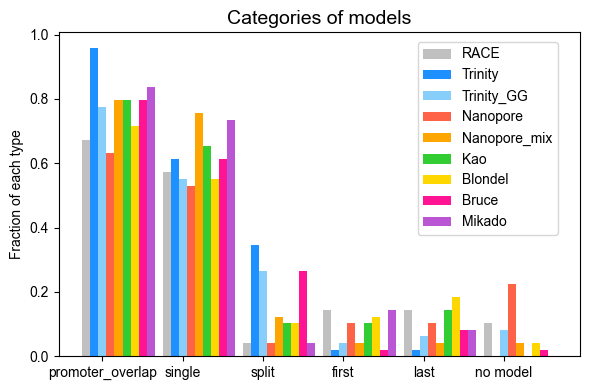

In [222]:
firstrow = pd.DataFrame({namedict[i]:total_fraction[i] for i in total_fraction}, index = [0])
complete_data = pd.concat([firstrow, collection], ignore_index = True)
complete_data.index = ['promoter_overlap', 'single', 'split', 'first', 'last', 'no model']

display(complete_data)

x = np.arange(len(complete_data.index))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))
i = 0
for column in complete_data.columns:
    j = i - 2
    rects = ax.bar(x + width * j, complete_data[column], width, label= column, color = colordict[i])
    i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction of each type')
ax.set_title('Categories of models', fontsize = 14)
ax.set_xticks(x)
ax.set_xticklabels(complete_data.index)
fig.tight_layout()
fig.legend(loc = "upper right", bbox_to_anchor = (0.95, 0.9))

if savefigs == True:
    plt.savefig(prefix + "_Fig5_fullsummary." + outfmt)

plt.show()

# Assess fraction of all genes with overlapping promoter peak

In [13]:
#Specify which models to compare to the Omni-ATAC peaks
models_list = ['phaw_5.0_eggnog_gene_annotations.sorted.gff',
               'mikado.loci.sorted.gff']

#Specify the location of the final manual annotation file
peaks_file = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/OmniATAC_bothruns_q005_allpeaks.igv_new.gff'

#Iterate through models and use bedtools to detect overlaps
for model in models_list:
    modelloc = '~/Labwork/Bioinformatics/Transcripts/' + model
    outputloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/' + model.replace('.gff', '_vsOmniATAC.tsv')
    !/usr/local/bin/bedtools closest -D a -a $modelloc -b $peaks_file > $outputloc

    #Display first two lines of each overlap file
    output = pd.read_csv(outputloc, sep = '\t', header = None)
    output = output[output[18] != -1]
    output = output.astype({11: int})
    output_new = output.to_csv(outputloc.replace('.tsv', '.filtered.tsv'), index = None, header = None, sep = '\t')
    display(output.head(2))

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
11,phaw_50.000009,maker,CDS,10186,10479,.,+,0,ID=augustus-phaw_50.000009-processed-gene-0.1-mRNA-1:cds;Parent=augustus-phaw_50.000009-processe...,phaw_50.000009,bed2gff,1,11629,11888,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=269.657501;-log10(p)_MAX=5.01003;-log10(p)_MIN=5.01003;-log1...,+,.,1;,1150
12,phaw_50.000009,maker,exon,10186,10479,.,+,.,ID=augustus-phaw_50.000009-processed-gene-0.1-mRNA-1:exon:0;Parent=augustus-phaw_50.000009-proce...,phaw_50.000009,bed2gff,1,11629,11888,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=269.657501;-log10(p)_MAX=5.01003;-log10(p)_MIN=5.01003;-log1...,+,.,1;,1150


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
12,phaw_50.000009,Mikado_loci,superlocus,10027,10786,.,+,.,ID=Mikado_superlocus:phaw_50.000009+:10027-10786;Name=superlocus:phaw_50.000009+:10027-10786,phaw_50.000009,bed2gff,1,11629,11888,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=269.657501;-log10(p)_MAX=5.01003;-log10(p)_MIN=5.01003;-log1...,+,.,1;,843
13,phaw_50.000009,Mikado_loci,gene,10027,10513,19,+,.,ID=mikado.phaw_50.000009G1;Name=mikado.phaw_50.000009G1;multiexonic=False;superlocus=Mikado_supe...,phaw_50.000009,bed2gff,1,11629,11888,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=269.657501;-log10(p)_MAX=5.01003;-log10(p)_MIN=5.01003;-log1...,+,.,1;,1116


In [154]:
#Specify which models to compare to the Omni-ATAC peaks
models_list = ['phaw_5.0_eggnog_gene_annotations.sorted.gff',
               'mikado.loci.sorted.gff']

fraction_with_nearby_dummy = {}
fraction_with_5k_dummy = {}
fraction_with_strong_dummy = {}
hist_dist = {}
hist_strength = {}
hist_closestrength = {}

#Iterate through models and use bedtools to detect overlaps
for model in models_list:
    outputloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/' + model.replace('.gff', '_vsOmniATAC.tsv')
    filteredloc = outputloc.replace('.tsv', '.filtered.tsv')
    output = pd.read_csv(outputloc, sep = '\t', header = None)
    output_genesonly = output[output[2].str.contains('|'.join(searchfor))]
    filtered = pd.read_csv(filteredloc, sep = '\t', header = None)
    filtered_genesonly = filtered[filtered[2].str.contains('|'.join(searchfor))]
    
    fraction_with_nearby_dummy[model] = len(filtered_genesonly) / len(output_genesonly)
    fraction_with_5k_dummy[model] = len(filtered_genesonly[abs(filtered_genesonly[18]) < 5000]) / len(filtered_genesonly)
    fraction_with_strong_dummy[model] = len(filtered_genesonly[(abs(filtered_genesonly[18]) < 5000) & (filtered_genesonly[11] > 3)]) / len(filtered_genesonly)
    hist_dist[model] = filtered_genesonly[18].values
    hist_strength[model] = filtered_genesonly[11].values
    hist_closestrength[model] = filtered_genesonly[abs(filtered_genesonly[18]) < 5000][11].values
    
display(fraction_with_nearby_dummy)
display(fraction_with_5k_dummy)
display(fraction_with_strong_dummy)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


{'phaw_5.0_eggnog_gene_annotations.sorted.gff': 0.879386108313825,
 'mikado.loci.sorted.gff': 0.9757562134737653}

{'phaw_5.0_eggnog_gene_annotations.sorted.gff': 0.9164119838490196,
 'mikado.loci.sorted.gff': 0.8724289992430974}

{'phaw_5.0_eggnog_gene_annotations.sorted.gff': 0.5747429004840833,
 'mikado.loci.sorted.gff': 0.5538305854477243}

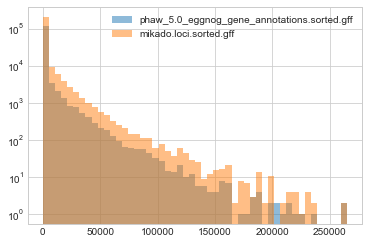

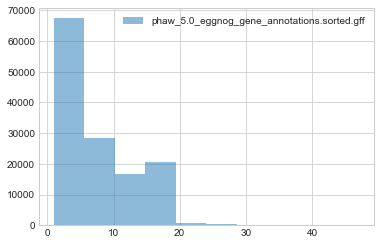

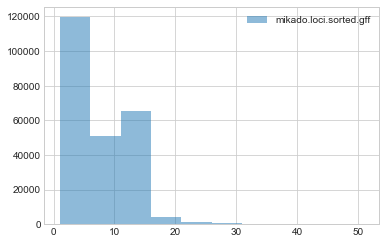

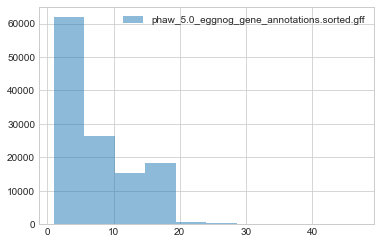

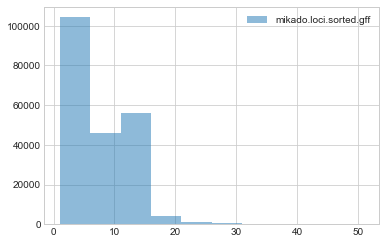

In [155]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in hist_dist:
    plt.hist(abs(hist_dist[i]), bins = 50, label = i, alpha = 0.5)
ax.set_yscale('log')
plt.legend(loc = 'upper right')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in hist_strength:
    plt.hist(abs(hist_strength[i]), label = i, alpha = 0.5)
    plt.legend(loc = 'upper right')
    plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in hist_closestrength:
    plt.hist(abs(hist_closestrength[i]), label = i, alpha = 0.5)
    plt.legend(loc = 'upper right')
    plt.show()

In [196]:
oldmodel = 'phaw_5.0_eggnog_gene_annotations.sorted.gff'
newmodel = 'mikado.loci.sorted.gff'

outputdir = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/'

oldmodelloc = '~/Labwork/Bioinformatics/Transcripts/' + oldmodel
oldmodeldf = pd.read_csv(oldmodelloc, sep = '\t', header = None)
oldmodel_genesonly = oldmodeldf[oldmodeldf[2] == 'gene']
oldmodel_genesonly_output = outputdir + oldmodel.replace('sorted', 'genesonly')
oldmodel_genesonly.to_csv(oldmodel_genesonly_output, sep = '\t', header = None, index = None)
newmodelloc = '~/Labwork/Bioinformatics/Transcripts/' + newmodel
newmodeldf = pd.read_csv(newmodelloc, sep = '\t', header = None, skiprows = 1)
newmodel_genesonly = newmodeldf[newmodeldf[2] == 'gene']
newmodel_genesonly_output = outputdir + newmodel.replace('sorted', 'genesonly')
newmodel_genesonly.to_csv(newmodel_genesonly_output, sep = '\t', header = None, index = None)
outputloc = outputdir + oldmodel.replace('.gff', '_vsDASMikado.tsv')
!/usr/local/bin/bedtools closest -D a -a $oldmodel_genesonly_output -b $newmodel_genesonly_output > $outputloc

output = pd.read_csv(outputloc, sep = '\t', header = None)
output_filtered = output[output[18] != -1]
oldmodel_match = output_filtered.iloc[:, :9]
oldmodel_matchout = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/Blondel_annotations.pair.gff'
oldmodel_match.to_csv(oldmodel_matchout, header = None, index = None, sep = '\t')
oldmodel_sortedout = oldmodel_matchout.replace('pair', 'sorted')
!/usr/local/bin/bedtools sort -i $oldmodel_matchout > $oldmodel_sortedout
newmodel_match = output_filtered.iloc[:, 9:-1]
newmodel_matchout = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/Sun_annotations.pair.gff'
newmodel_match.to_csv(newmodel_matchout, header = None, index = None, sep = '\t')
newmodel_sortedout = newmodel_matchout.replace('pair', 'sorted')
!/usr/local/bin/bedtools sort -i $newmodel_matchout > $newmodel_sortedout
display(output.head(5))
display(oldmodel_match.head(5))
display(newmodel_match.head(5))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,phaw_50.000008,maker,gene,48042,64245,.,-,.,ID=maker-phaw_50.000008-augustus-gene-0.0;Name=maker-phaw_50.000008-augustus-gene-0.0,phaw_50.000008,Mikado_loci,gene,48042,64245,22,-,.,ID=mikado.phaw_50.000008G1;Name=mikado.phaw_50.000008G1;multiexonic=True;superlocus=Mikado_super...,0
1,phaw_50.000009,maker,gene,10186,10479,.,+,.,ID=augustus-phaw_50.000009-processed-gene-0.1;Name=augustus-phaw_50.000009-processed-gene-0.1,phaw_50.000009,Mikado_loci,gene,10027,10513,19,+,.,ID=mikado.phaw_50.000009G1;Name=mikado.phaw_50.000009G1;multiexonic=False;superlocus=Mikado_supe...,0
2,phaw_50.000011,maker,gene,262,372,.,+,.,ID=genemark-phaw_50.000011-processed-gene-0.1;Name=genemark-phaw_50.000011-processed-gene-0.1,.,.,.,-1,-1,.,.,.,.,-1
3,phaw_50.000014,maker,gene,7027,16031,.,-,.,ID=genemark-phaw_50.000014-processed-gene-0.13;Name=genemark-phaw_50.000014-processed-gene-0.13,phaw_50.000014,Mikado_loci,gene,3630,19158,17,-,.,ID=mikado.phaw_50.000014G1;Name=mikado.phaw_50.000014G1;multiexonic=True;superlocus=Mikado_super...,0
4,phaw_50.000014,maker,gene,49115,54626,.,-,.,ID=genemark-phaw_50.000014-processed-gene-0.16;Name=genemark-phaw_50.000014-processed-gene-0.16,phaw_50.000014,Mikado_loci,gene,3630,19158,17,-,.,ID=mikado.phaw_50.000014G1;Name=mikado.phaw_50.000014G1;multiexonic=True;superlocus=Mikado_super...,29957


,0,1,2,3,4,5,6,7,8
0,phaw_50.000008,maker,gene,48042,64245,.,-,.,ID=maker-phaw_50.000008-augustus-gene-0.0;Name=maker-phaw_50.000008-augustus-gene-0.0
1,phaw_50.000009,maker,gene,10186,10479,.,+,.,ID=augustus-phaw_50.000009-processed-gene-0.1;Name=augustus-phaw_50.000009-processed-gene-0.1
3,phaw_50.000014,maker,gene,7027,16031,.,-,.,ID=genemark-phaw_50.000014-processed-gene-0.13;Name=genemark-phaw_50.000014-processed-gene-0.13
4,phaw_50.000014,maker,gene,49115,54626,.,-,.,ID=genemark-phaw_50.000014-processed-gene-0.16;Name=genemark-phaw_50.000014-processed-gene-0.16
5,phaw_50.000014,maker,gene,90734,106507,.,-,.,ID=maker-phaw_50.000014-snap-gene-0.33;Name=maker-phaw_50.000014-snap-gene-0.33


,9,10,11,12,13,14,15,16,17
0,phaw_50.000008,Mikado_loci,gene,48042,64245,22,-,.,ID=mikado.phaw_50.000008G1;Name=mikado.phaw_50.000008G1;multiexonic=True;superlocus=Mikado_super...
1,phaw_50.000009,Mikado_loci,gene,10027,10513,19,+,.,ID=mikado.phaw_50.000009G1;Name=mikado.phaw_50.000009G1;multiexonic=False;superlocus=Mikado_supe...
3,phaw_50.000014,Mikado_loci,gene,3630,19158,17,-,.,ID=mikado.phaw_50.000014G1;Name=mikado.phaw_50.000014G1;multiexonic=True;superlocus=Mikado_super...
4,phaw_50.000014,Mikado_loci,gene,3630,19158,17,-,.,ID=mikado.phaw_50.000014G1;Name=mikado.phaw_50.000014G1;multiexonic=True;superlocus=Mikado_super...
5,phaw_50.000014,Mikado_loci,gene,91834,122312,22,-,.,ID=mikado.phaw_50.000014G2;Name=mikado.phaw_50.000014G2;multiexonic=True;superlocus=Mikado_super...


In [131]:
#Specify which models to compare to the Omni-ATAC peaks
models_list = ['Blondel_annotations.sorted.gff',
              'Sun_annotations.sorted.gff']

#Specify the location of the final manual annotation file
peaks_file = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/OmniATAC_bothruns_q005_allpeaks.igv_new.gff'

#Iterate through models and use bedtools to detect overlaps
for model in models_list:
    modelloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/' + model
    outputloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/' + model.replace('.gff', '_vsOmniATAC.tsv')
    !/usr/local/bin/bedtools closest -D a -a $modelloc -b $peaks_file > $outputloc

    #Display first two lines of each overlap file
    output = pd.read_csv(outputloc, sep = '\t', header = None)
    output = output[output[18] != -1]
    output = output.astype({11: int})
    output_new = output.to_csv(outputloc.replace('.tsv', '.filtered.tsv'), index = None, header = None, sep = '\t')
    display(output.head(2))

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,phaw_50.000019,maker,mRNA,108204,109977,.,+,.,ID=maker-phaw_50.000019-snap-gene-0.4-mRNA-1;Parent=maker-phaw_50.000019-snap-gene-0.4;Name=make...,phaw_50.000019,bed2gff,15,97414,97613,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=412.2456523;-log10(p)_MAX=6.694856;-log10(p)_MIN=5.136321;-...,+,.,15;,-10591
2,phaw_50.000038,maker,mRNA,171,599,.,+,.,ID=snap-phaw_50.000038-processed-gene-0.1-mRNA-1;Parent=snap-phaw_50.000038-processed-gene-0.1;N...,phaw_50.000038,bed2gff,5,39,474,COUNT=5;SCORE_MEAN=855;SIGNAL_MEAN=366.4183776;-log10(p)_MAX=5.045541;-log10(p)_MIN=4.127027;-lo...,+,.,5;,0


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,phaw_50.000019,Mikado_loci,gene,108204,109977,19,+,.,ID=mikado.phaw_50.000019G2;Name=mikado.phaw_50.000019G2;multiexonic=True;superlocus=Mikado_super...,phaw_50.000019,bed2gff,15,97414,97613,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=412.2456523;-log10(p)_MAX=6.694856;-log10(p)_MIN=5.136321;-...,+,.,15;,-10591
2,phaw_50.000038,Mikado_loci,gene,299,643,19,+,.,ID=mikado.phaw_50.000038G1;Name=mikado.phaw_50.000038G1;multiexonic=False;superlocus=Mikado_supe...,phaw_50.000038,bed2gff,5,39,474,COUNT=5;SCORE_MEAN=855;SIGNAL_MEAN=366.4183776;-log10(p)_MAX=5.045541;-log10(p)_MIN=4.127027;-lo...,+,.,5;,0


In [151]:
#Specify which models to compare to the Omni-ATAC peaks
models_list = ['Blondel_annotations.sorted.gff',
               'Sun_annotations.sorted.gff']

fraction_with_nearby_dummy = {}
fraction_with_5k_dummy = {}
fraction_with_strong_dummy = {}
hist_dist = {}
hist_strength = {}
hist_closestrength = {}

#Iterate through models and use bedtools to detect overlaps
for model in models_list:
    outputloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/' + model.replace('.gff', '_vsOmniATAC.tsv')
    filteredloc = outputloc.replace('.tsv', '.filtered.tsv')
    output = pd.read_csv(outputloc, sep = '\t', header = None)
    output_genesonly = output
    filtered = pd.read_csv(filteredloc, sep = '\t', header = None)
    filtered_genesonly = filtered
    
    fraction_with_nearby_dummy[model] = len(filtered_genesonly) / len(output_genesonly)
    fraction_with_5k_dummy[model] = len(filtered_genesonly[abs(filtered_genesonly[18]) < 5000]) / len(filtered_genesonly)
    fraction_with_strong_dummy[model] = len(filtered_genesonly[(abs(filtered_genesonly[18]) < 5000) & (filtered_genesonly[11] > 3)]) / len(filtered_genesonly)
    hist_dist[model] = filtered_genesonly[18].values
    hist_strength[model] = filtered_genesonly[11].values
    hist_closestrength[model] = filtered_genesonly[abs(filtered_genesonly[18]) < 5000][11].values
    
    display(len(filtered), len(output))
    
display(fraction_with_nearby_dummy)
display(fraction_with_5k_dummy)
display(fraction_with_strong_dummy)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


146769

147246

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


112238

112716

{'Blondel_annotations.sorted.gff': 0.9967605232060633,
 'Sun_annotations.sorted.gff': 0.9957592533446893}

{'Blondel_annotations.sorted.gff': 0.966450681002119,
 'Sun_annotations.sorted.gff': 0.9337479285090611}

{'Blondel_annotations.sorted.gff': 0.5897771327732696,
 'Sun_annotations.sorted.gff': 0.5746716798232328}

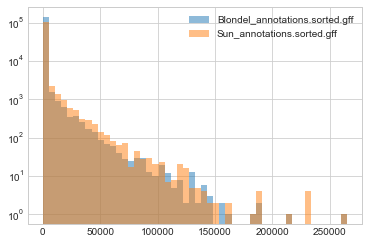

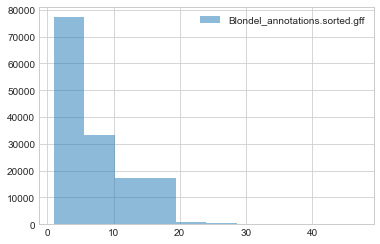

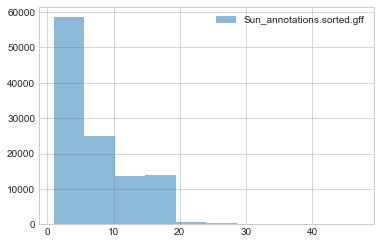

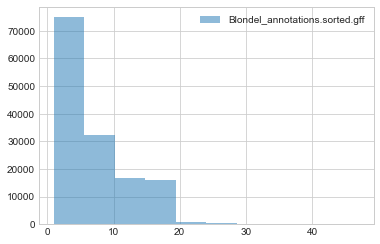

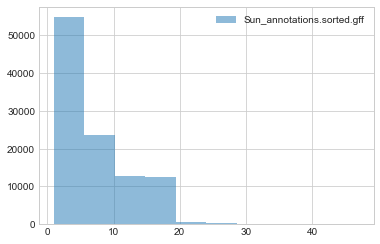

In [152]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in hist_dist:
    plt.hist(abs(hist_dist[i]), bins = 50, label = i, alpha = 0.5)
ax.set_yscale('log')
plt.legend(loc = 'upper right')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in hist_strength:
    plt.hist(abs(hist_strength[i]), label = i, alpha = 0.5)
    plt.legend(loc = 'upper right')
    plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in hist_closestrength:
    plt.hist(abs(hist_closestrength[i]), label = i, alpha = 0.5)
    plt.legend(loc = 'upper right')
    plt.show()

In [14]:
modelnames = ['phaw_5.0_eggnog_gene_annotations.sorted.gff',
              'mikado.loci.sorted.gff']

outputdir = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/'

for model in modelnames:
    modelloc = '~/Labwork/Bioinformatics/Transcripts/' + model
    if 'mikado' in model:
        modeldf = pd.read_csv(modelloc, sep = '\t', header = None, skiprows = 1)
    else:
        modeldf = pd.read_csv(modelloc, sep = '\t', header = None)
    if 'stringtie2' not in model:
        model_genesonly = modeldf[modeldf[2] == 'gene']
    else:
        model_genesonly = modeldf[modeldf[2] == 'transcript']
    model_genesonly_output = outputdir + model.replace('sorted', 'genesonly')
    model_genesonly.to_csv(model_genesonly_output, sep = '\t', header = None, index = None)

In [15]:
modelnames = ['phaw_5.0_eggnog_gene_annotations.genesonly.gff',
              'mikado.loci.genesonly.gff']
startinglist_size = {}
finallist_size = {}
ratios = {}
hist_strength = {}

for modelname in modelnames:
    dataloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/'
    genesonly = pd.read_csv(dataloc + modelname, header = None, sep = '\t')
    
    genesonly['size'] = genesonly.apply(lambda row: int(row[4]) - int(row[3]), axis = 1)
    genesonly = genesonly[genesonly['size'] > 500]
    startinglist_size[modelname] = len(genesonly)
    genesonly['newstart'] = genesonly.apply(lambda row: int(row[3]) if row[6] == '+' else int(row[4]) - 200, axis = 1)
    genesonly['newend'] = genesonly.apply(lambda row: int(row[4]) if row[6] == '-' else int(row[3]) + 200, axis = 1)

    geneendsname = modelname.replace('genesonly', 'geneends')
    geneendsloc = dataloc + geneendsname
    geneends = genesonly[[0, 1, 2, 'newstart', 'newend', 5, 6, 7, 8]]
    geneends.to_csv(geneendsloc, header = None, sep = '\t', index = None)
    geneendssorted = geneendsloc.replace('geneends', 'geneends.sorted')
    !/usr/local/bin/bedtools sort -i $geneendsloc > $geneendssorted

    #Specify the location of the final manual annotation file
    peaks_file = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/OmniATAC_bothruns_q005_allpeaks.igv_new.gff'
    outputloc = dataloc + modelname.replace('.genesonly.gff', '.geneends.closest_old.gff')
    !/usr/local/bin/bedtools closest -D a -a $geneendssorted -b $peaks_file > $outputloc
    
    promoter_guesses = pd.read_csv(outputloc, header = None, sep = '\t')
    promoter_guesses = promoter_guesses[abs(promoter_guesses[18]) < 5000]
    promoter_guesses = promoter_guesses[promoter_guesses[18] != -1]
    promoter_guesses['IGV_address'] = promoter_guesses[9].astype(str) + ":" + promoter_guesses[12].astype(str) + "-" + promoter_guesses[13].astype(str)
    finallist_size[modelname] = len(promoter_guesses)
    ratios[modelname] = finallist_size[modelname] / startinglist_size[modelname]
    
    hist_strength[modelname] = promoter_guesses[11].astype(int).values
    display(promoter_guesses)
    display(ratios[modelname])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,IGV_address
6,phaw_50.000014,maker,gene,237099,237299,.,-,.,ID=genemark-phaw_50.000014-processed-gene-0.31;Name=genemark-phaw_50.000014-processed-gene-0.31,phaw_50.000014,bed2gff,3,238985,239410,COUNT=3;SCORE_MEAN=1000;SIGNAL_MEAN=403.0396423;-log10(p)_MAX=6.473408;-log10(p)_MIN=5.29058;-lo...,+,.,3;,-1686,phaw_50.000014:238985-239410
13,phaw_50.000025,maker,gene,19985,20185,.,+,.,ID=maker-phaw_50.000025-snap-gene-0.23;Name=maker-phaw_50.000025-snap-gene-0.23,phaw_50.000025,bed2gff,1,20294,20650,COUNT=1;SCORE_MEAN=900;SIGNAL_MEAN=321.394867;-log10(p)_MAX=4.94445;-log10(p)_MIN=4.94445;-log10...,+,.,1;,109,phaw_50.000025:20294-20650
14,phaw_50.000027,maker,gene,71530,71730,.,+,.,ID=maker-phaw_50.000027-snap-gene-0.18;Name=maker-phaw_50.000027-snap-gene-0.18,phaw_50.000027,bed2gff,6,69831,70633,COUNT=6;SCORE_MEAN=658.6666667;SIGNAL_MEAN=495.1125947;-log10(p)_MAX=5.650686;-log10(p)_MIN=4.16...,+,.,6;,-897,phaw_50.000027:69831-70633
15,phaw_50.000028,maker,gene,23602,23802,.,+,.,ID=maker-phaw_50.000028-snap-gene-0.0;Name=maker-phaw_50.000028-snap-gene-0.0,phaw_50.000028,bed2gff,7,21120,21638,COUNT=7;SCORE_MEAN=728.4285714;SIGNAL_MEAN=325.6438557;-log10(p)_MAX=5.258597;-log10(p)_MIN=3.99...,+,.,7;,-1964,phaw_50.000028:21120-21638
16,phaw_50.000039,maker,gene,24207,24407,.,-,.,ID=maker-phaw_50.000039-augustus-gene-0.4;Name=maker-phaw_50.000039-augustus-gene-0.4,phaw_50.000039,bed2gff,15,21717,22035,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=581.3232748;-log10(p)_MAX=8.373808;-log10(p)_MIN=5.207952;-...,+,.,15;,2172,phaw_50.000039:21717-22035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24970,phaw_50.283875a,maker,gene,26588316,26588516,.,-,.,ID=maker-phaw_50.283875a-snap-gene-88.6;Name=maker-phaw_50.283875a-snap-gene-88.6,phaw_50.283875a,bed2gff,11,26589332,26590000,COUNT=11;SCORE_MEAN=944.0909091;SIGNAL_MEAN=624.2845059;-log10(p)_MAX=8.382157;-log10(p)_MIN=5.4...,+,.,11;,-816,phaw_50.283875a:26589332-26590000
24974,phaw_50.283875a,maker,gene,26756020,26756220,.,+,.,ID=maker-phaw_50.283875a-snap-gene-88.2;Name=maker-phaw_50.283875a-snap-gene-88.2,phaw_50.283875a,bed2gff,1,26755723,26756084,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=1479.325195;-log10(p)_MAX=11.257517;-log10(p)_MIN=11.257517;...,+,.,1;,0,phaw_50.283875a:26755723-26756084
24975,phaw_50.283875b,maker,gene,346,546,.,-,.,ID=augustus-phaw_50.283875b-processed-gene-0.5;Name=augustus-phaw_50.283875b-processed-gene-0.5,phaw_50.283875b,bed2gff,11,50,515,COUNT=11;SCORE_MEAN=773.8181818;SIGNAL_MEAN=319.7917383;-log10(p)_MAX=5.066792;-log10(p)_MIN=4.2...,+,.,11;,0,phaw_50.283875b:50-515
24977,phaw_50.283875b,maker,gene,202391,202591,.,-,.,ID=maker-phaw_50.283875b-snap-gene-0.22;Name=maker-phaw_50.283875b-snap-gene-0.22,phaw_50.283875b,bed2gff,1,207478,207749,COUNT=1;SCORE_MEAN=893;SIGNAL_MEAN=242.770172;-log10(p)_MAX=4.674273;-log10(p)_MIN=4.674273;-log...,+,.,1;,-4887,phaw_50.283875b:207478-207749


0.47653155135848907

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,IGV_address
8,phaw_50.000023,Mikado_loci,gene,39009,39209,21,+,.,ID=mikado.phaw_50.000023G1;Name=mikado.phaw_50.000023G1;multiexonic=False;superlocus=Mikado_supe...,phaw_50.000023,bed2gff,2,39987,40643,COUNT=2;SCORE_MEAN=351;SIGNAL_MEAN=225.3805085;-log10(p)_MAX=3.966765;-log10(p)_MIN=3.94913;-log...,+,.,2;,778,phaw_50.000023:39987-40643
10,phaw_50.000023,Mikado_loci,gene,117984,118184,21,-,.,ID=mikado.phaw_50.000023G4;Name=mikado.phaw_50.000023G4;multiexonic=True;superlocus=Mikado_super...,phaw_50.000023,bed2gff,1,121270,121683,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=432.315552;-log10(p)_MAX=5.709125;-log10(p)_MIN=5.709125;-lo...,+,.,1;,-3086,phaw_50.000023:121270-121683
14,phaw_50.000027,Mikado_loci,gene,71616,71816,16,+,.,ID=mikado.phaw_50.000027G3;Name=mikado.phaw_50.000027G3;multiexonic=True;superlocus=Mikado_super...,phaw_50.000027,bed2gff,6,69831,70633,COUNT=6;SCORE_MEAN=658.6666667;SIGNAL_MEAN=495.1125947;-log10(p)_MAX=5.650686;-log10(p)_MIN=4.16...,+,.,6;,-983,phaw_50.000027:69831-70633
15,phaw_50.000027,Mikado_loci,gene,160499,160699,15,-,.,ID=mikado.phaw_50.000027G6;Name=mikado.phaw_50.000027G6;multiexonic=True;superlocus=Mikado_super...,phaw_50.000027,bed2gff,4,157829,158672,COUNT=4;SCORE_MEAN=853;SIGNAL_MEAN=678.4532545;-log10(p)_MAX=7.638493;-log10(p)_MIN=5.39596;-log...,+,.,4;,1827,phaw_50.000027:157829-158672
16,phaw_50.000027,Mikado_loci,gene,161632,161832,15,+,.,ID=mikado.phaw_50.000027G4;Name=mikado.phaw_50.000027G4;multiexonic=True;superlocus=Mikado_super...,phaw_50.000027,bed2gff,4,157829,158672,COUNT=4;SCORE_MEAN=853;SIGNAL_MEAN=678.4532545;-log10(p)_MAX=7.638493;-log10(p)_MIN=5.39596;-log...,+,.,4;,-2960,phaw_50.000027:157829-158672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37423,phaw_50.283875a,Mikado_loci,gene,26757940,26758140,22,+,.,ID=mikado.phaw_50.283875aG523;Name=mikado.phaw_50.283875aG523;multiexonic=True;superlocus=Mikado...,phaw_50.283875a,bed2gff,1,26755723,26756084,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=1479.325195;-log10(p)_MAX=11.257517;-log10(p)_MIN=11.257517;...,+,.,1;,-1856,phaw_50.283875a:26755723-26756084
37429,phaw_50.283875b,Mikado_loci,gene,855548,855748,20,-,.,ID=mikado.phaw_50.283875bG7;Name=mikado.phaw_50.283875bG7;multiexonic=True;superlocus=Mikado_sup...,phaw_50.283875b,bed2gff,15,850040,850855,COUNT=15;SCORE_MEAN=943.2666667;SIGNAL_MEAN=538.304191;-log10(p)_MAX=6.149063;-log10(p)_MIN=4.66...,+,.,15;,4693,phaw_50.283875b:850040-850855
37432,phaw_50.283875b,Mikado_loci,gene,1261178,1261378,22,-,.,ID=mikado.phaw_50.283875bG9;Name=mikado.phaw_50.283875bG9;multiexonic=True;superlocus=Mikado_sup...,phaw_50.283875b,bed2gff,5,1263954,1264350,COUNT=5;SCORE_MEAN=782.4;SIGNAL_MEAN=279.998813;-log10(p)_MAX=5.964021;-log10(p)_MIN=5.029833;-l...,+,.,5;,-2576,phaw_50.283875b:1263954-1264350
37434,phaw_50.283875b,Mikado_loci,gene,1404886,1405086,20,+,.,ID=mikado.phaw_50.283875bG11;Name=mikado.phaw_50.283875bG11;multiexonic=True;superlocus=Mikado_s...,phaw_50.283875b,bed2gff,7,1409007,1409584,COUNT=7;SCORE_MEAN=931.1428571;SIGNAL_MEAN=706.7873973;-log10(p)_MAX=8.844542;-log10(p)_MIN=5.06...,+,.,7;,3921,phaw_50.283875b:1409007-1409584


0.5062256185539464

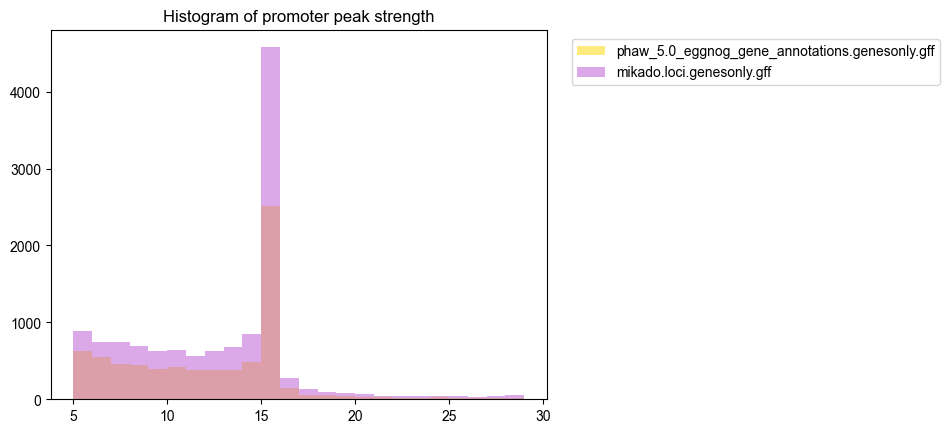

{'phaw_5.0_eggnog_gene_annotations.genesonly.gff': 0.47653155135848907,
 'mikado.loci.genesonly.gff': 0.5062256185539464}

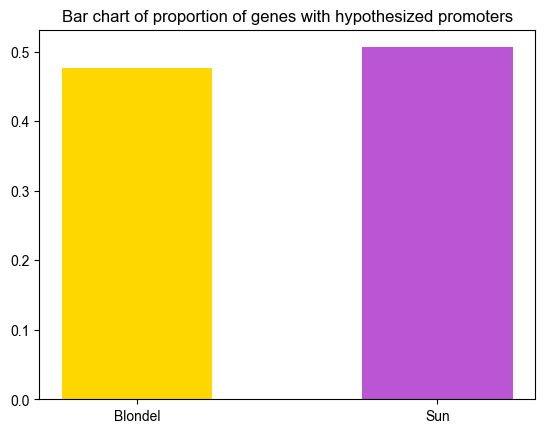

{'phaw_5.0_eggnog_gene_annotations.genesonly.gff': 11909,
 'mikado.loci.genesonly.gff': 18946}

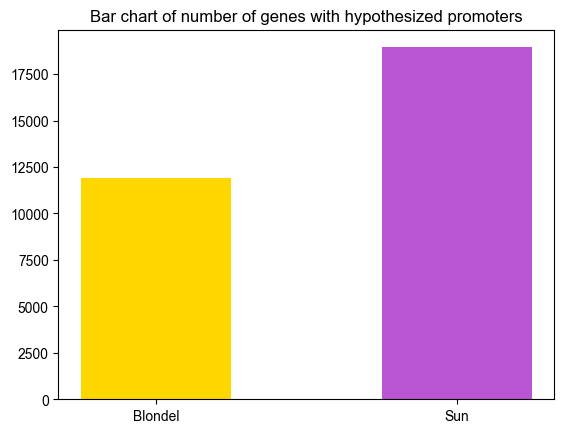

In [18]:
datasets = ['phaw_5.0_eggnog_gene_annotations.genesonly.gff',
              'mikado.loci.genesonly.gff']
dummynames = ['Blondel', 'Sun']
colors = ['gold', 'mediumorchid']
colordict = dict(zip([i for i in datasets],colors))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in hist_strength:
    plt.hist(abs(hist_strength[i]), bins = np.arange(5, 30), label = i, alpha = 0.5, color = colordict[i])
plt.legend(loc = (1.05, 0.85))
plt.title('Histogram of promoter peak strength')
plt.show()

display(ratios)
fig2 = plt.figure()
plt.bar(dummynames, ratios.values(), 0.5, color = colors)
plt.title('Bar chart of proportion of genes with hypothesized promoters')
plt.show()

display(finallist_size)
fig3 = plt.figure()
plt.bar(dummynames, finallist_size.values(), 0.5, color = colors)
plt.title('Bar chart of number of genes with hypothesized promoters')
plt.show()

,query_name,seed eggNOG ortholog,seed ortholog evalue,seed ortholog score,Predicted taxonomic group,Predicted protein name,Gene Ontology terms,EC number,KEGG_ko,KEGG_Pathway,...,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG Reaction,tax_scope: eggNOG taxonomic level used for annotation,eggNOG OGs,"bestOG (deprecated, use smallest from eggnog OGs)",COG Functional Category,eggNOG free text description
0,maker-phaw_50.000008-augustus-gene-0.0-mRNA-1,13037.EHJ64856,8.800000e-08,63.5,Lepidoptera,NaN,"GO:0005575,GO:0005576,GO:0005615,GO:0006950,GO:0006979,GO:0007275,GO:0007568,GO:0008150,GO:00083...",NaN,ko:K03098,NaN,...,NaN,"ko00000,ko04147",NaN,NaN,NaN,Arthropoda,"3A0H1@33154,3BPI5@33208,3D6K3@33213,3SMTM@50557,41ZJ0@6656,446UH@7088,COG3040@1,KOG4824@2759",NA|NA|NA,M,Lipocalin-like domain
1,maker-phaw_50.000019-snap-gene-0.4-mRNA-1,10224.XP_006813755.1,3.000000e-09,68.2,Bilateria,GXYLT1,"GO:0003674,GO:0003824,GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO:0005783,GO:0005789,GO:00064...",NaN,ko:K13676,"ko00514,map00514",...,NaN,"ko00000,ko00001,ko01000,ko01003",NaN,NaN,NaN,Metazoa,"38DMB@33154,3B9TI@33208,3CS1N@33213,KOG3765@1,KOG3765@2759",NA|NA|NA,G,Glucoside xylosyltransferase
2,snap-phaw_50.000038-processed-gene-0.1-mRNA-1,7091.BGIBMGA012290-TA,2.600000e-07,62.0,Lepidoptera,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Arthropoda,"2EMJ6@1,2SR73@2759,3APM7@33154,3C35F@33208,3DI2R@33213,3SPU5@50557,4234V@6656,44A1S@7088",NA|NA|NA,S,Conserved hypothetical protein
3,maker-phaw_50.000056-snap-gene-0.28-mRNA-1,13037.EHJ76964,7.500000e-07,62.8,Lepidoptera,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Arthropoda,"397CY@33154,3CBP4@33208,3DSYP@33213,3SYIN@50557,4291P@6656,447G9@7088,KOG1721@1,KOG1721@2759",NA|NA|NA,S,C2H2-type zinc-finger domain
4,maker-phaw_50.000056-snap-gene-0.28-mRNA-2,13037.EHJ76964,6.800000e-07,62.8,Lepidoptera,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Arthropoda,"397CY@33154,3CBP4@33208,3DSYP@33213,3SYIN@50557,4291P@6656,447G9@7088,KOG1721@1,KOG1721@2759",NA|NA|NA,S,C2H2-type zinc-finger domain


'total number of gene models:'

15105

'total number of named gene models:'

4949

,query_name,seed eggNOG ortholog,seed ortholog evalue,seed ortholog score,Predicted taxonomic group,Predicted protein name,Gene Ontology terms,EC number,KEGG_ko,KEGG_Pathway,...,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG Reaction,tax_scope: eggNOG taxonomic level used for annotation,eggNOG OGs,"bestOG (deprecated, use smallest from eggnog OGs)",COG Functional Category,eggNOG free text description
0,mikado.phaw_50.000008G1.1.p1,13037.EHJ64856,6.100000e-08,63.9,Lepidoptera,NaN,"GO:0005575,GO:0005576,GO:0005615,GO:0006950,GO:0006979,GO:0007275,GO:0007568,GO:0008150,GO:00083...",NaN,ko:K03098,NaN,...,NaN,"ko00000,ko04147",NaN,NaN,NaN,Arthropoda,"3A0H1@33154,3BPI5@33208,3D6K3@33213,3SMTM@50557,41ZJ0@6656,446UH@7088,COG3040@1,KOG4824@2759",NA|NA|NA,M,Lipocalin-like domain
1,mikado.phaw_50.000019G1.1.p1,10224.XP_006813755.1,3.300000e-14,86.3,Bilateria,GXYLT1,"GO:0003674,GO:0003824,GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO:0005783,GO:0005789,GO:00064...",NaN,ko:K13676,"ko00514,map00514",...,NaN,"ko00000,ko00001,ko01000,ko01003",NaN,NaN,NaN,Metazoa,"38DMB@33154,3B9TI@33208,3CS1N@33213,KOG3765@1,KOG3765@2759",NA|NA|NA,G,Glucoside xylosyltransferase
2,mikado.phaw_50.000019G2.1.p1,10224.XP_006813755.1,3.000000e-09,68.2,Bilateria,GXYLT1,"GO:0003674,GO:0003824,GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO:0005783,GO:0005789,GO:00064...",NaN,ko:K13676,"ko00514,map00514",...,NaN,"ko00000,ko00001,ko01000,ko01003",NaN,NaN,NaN,Metazoa,"38DMB@33154,3B9TI@33208,3CS1N@33213,KOG3765@1,KOG3765@2759",NA|NA|NA,G,Glucoside xylosyltransferase
3,mikado.phaw_50.000023G1.1.p1,7897.ENSLACP00000023583,5.400000e-44,185.3,Vertebrata,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Metazoa,"39Y6T@33154,3BEGN@33208,3CZ7K@33213,48DPU@7711,49A9G@7742,KOG1075@1,KOG1075@2759",NA|NA|NA,S,Reverse transcriptase (RNA-dependent DNA polymerase)
4,mikado.phaw_50.000025G1.1.p1,6669.EFX85237,2.300000e-161,575.9,Arthropoda,NaN,"GO:0000003,GO:0001666,GO:0003008,GO:0003014,GO:0003674,GO:0003824,GO:0005215,GO:0005575,GO:00056...",3.6.3.44,ko:K05658,"ko02010,ko04976,ko05206,ko05226,map02010,map04976,map05206,map05226",...,NaN,"ko00000,ko00001,ko01000,ko02000,ko04090,ko04147",3.A.1.201,NaN,NaN,Arthropoda,"38E88@33154,3B958@33208,3CVKH@33213,41WNN@6656,COG1132@1,KOG0055@2759",NA|NA|NA,Q,It is involved in the biological process described with transmembrane transport


'total number of gene models:'

21218

'total number of named gene models:'

6850

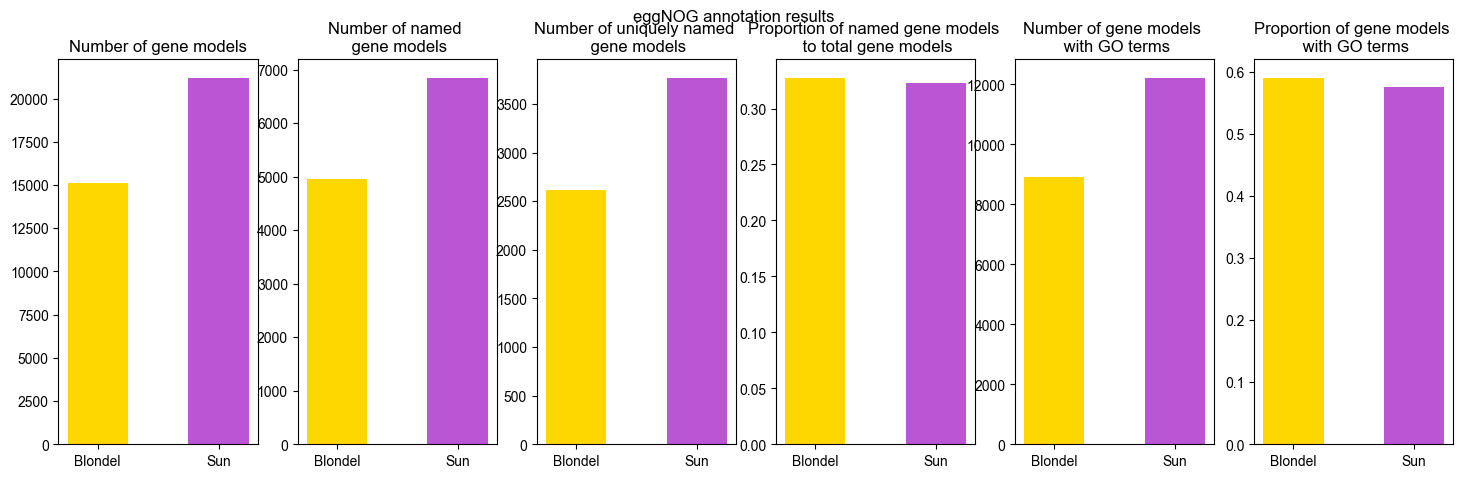

{'phaw_5.0_basicannot.emapper.annotations': 15105,
 'phaw_5.0_mikado.emapper.annotations': 21218}

{'phaw_5.0_basicannot.emapper.annotations': 4949,
 'phaw_5.0_mikado.emapper.annotations': 6850}

{'phaw_5.0_basicannot.emapper.annotations': 2610,
 'phaw_5.0_mikado.emapper.annotations': 3771}

{'phaw_5.0_basicannot.emapper.annotations': 0.3276398543528633,
 'phaw_5.0_mikado.emapper.annotations': 0.32283909887831086}

{'phaw_5.0_basicannot.emapper.annotations': 8925,
 'phaw_5.0_mikado.emapper.annotations': 12226}

{'phaw_5.0_basicannot.emapper.annotations': 0.5908639523336644,
 'phaw_5.0_mikado.emapper.annotations': 0.5762088792534641}

In [20]:
annotations_files = ['phaw_5.0_basicannot.emapper.annotations',
                     'phaw_5.0_mikado.emapper.annotations']
dummynames = ['Blondel', 'Sun']
colors = ['gold', 'mediumorchid']
colordict = dict(zip([i for i in datasets],colors))

columns = ['query_name', 
'seed eggNOG ortholog',
'seed ortholog evalue',
'seed ortholog score',
'Predicted taxonomic group',
'Predicted protein name',
'Gene Ontology terms',
'EC number',
'KEGG_ko',
'KEGG_Pathway',
'KEGG_Module',
'KEGG_Reaction',
'KEGG_rclass',
'BRITE',
'KEGG_TC',
'CAZy',
'BiGG Reaction',
'tax_scope: eggNOG taxonomic level used for annotation',
'eggNOG OGs',
'bestOG (deprecated, use smallest from eggnog OGs)',
'COG Functional Category',
'eggNOG free text description']

len_dict = {}
named_dict = {}
unique_dict = {}
ratio_dict = {}
go_bar = {}
go_pro_bar = {}

for annotations_file in annotations_files:
    annotations = pd.DataFrame(pd.read_csv(annotations_file, sep='\t', skiprows=4, names = columns))
    display(annotations.head(5))
    len_dict[annotations_file] = len(annotations)
    named_dict[annotations_file] = len(annotations[~pd.isnull(annotations['Predicted protein name'])])
    unique_dict[annotations_file] = len(annotations['Predicted protein name'].unique())
    ratio_dict[annotations_file] = named_dict[annotations_file] / len_dict[annotations_file]
    go_bar[annotations_file] = len(annotations[~pd.isnull(annotations['Gene Ontology terms'])])
    go_pro_bar[annotations_file] = go_bar[annotations_file] / len(annotations)
    display('total number of gene models:', len_dict[annotations_file])
    display('total number of named gene models:', named_dict[annotations_file])
    
numfigs = 6

fig1 = plt.figure(figsize = (18, 5))
plt.suptitle('eggNOG annotation results', fontsize = 12)
ax1 = plt.subplot(1, numfigs, 1)
plt.bar(dummynames, len_dict.values(), 0.5, color = colors)
plt.title('Number of gene models')
    
ax2 = plt.subplot(1, numfigs, 2)
plt.bar(dummynames, named_dict.values(), 0.5, color = colors)
plt.title('Number of named \n gene models')

ax3 = plt.subplot(1, numfigs, 3)
plt.bar(dummynames, unique_dict.values(), 0.5, color = colors)
plt.title('Number of uniquely named \n gene models')

ax4 = plt.subplot(1, numfigs, 4)
plt.bar(dummynames, ratio_dict.values(), 0.5, color = colors)
plt.title('Proportion of named gene models \n to total gene models')

ax5 = plt.subplot(1, numfigs, 5)
plt.bar(dummynames, go_bar.values(), 0.5, color = colors)
plt.title('Number of gene models \n with GO terms')

ax6 = plt.subplot(1, numfigs, 6)
plt.bar(dummynames, go_pro_bar.values(), 0.5, color = colors)
plt.title('Proportion of gene models \n with GO terms')

plt.show()

display(len_dict, named_dict, unique_dict, ratio_dict, go_bar, go_pro_bar)

6087

1521

3822

,Orthogroup,UP000000803_7227,phaw_5.0.onlyGenes.exons.fasta.transdecoder
0,OG0000000,"sp|Q9VNH6|EXOC4_DROME, sp|Q9W5P1|MED21_DROME","augustus-phaw_50.000081a-processed-gene-10.10-mRNA-1.p1, augustus-phaw_50.000135c-processed-gene..."
1,OG0000001,NaN,"augustus-phaw_50.283710-processed-gene-24.37-mRNA-1.p1, augustus-phaw_50.283842-processed-gene-5..."
2,OG0000002,NaN,"augustus-phaw_50.000023-processed-gene-0.30-mRNA-1.p1, augustus-phaw_50.282260b-processed-gene-2..."
3,OG0000003,NaN,"augustus-phaw_50.000135b-processed-gene-64.10-mRNA-1.p1, augustus-phaw_50.000203b-processed-gene..."
4,OG0000004,NaN,"augustus-phaw_50.000289b-processed-gene-18.14-mRNA-1.p1, augustus-phaw_50.021653-processed-gene-..."


,Orthogroup,UP000000803_7227,phaw_5.0.onlyGenes.exons.fasta.transdecoder
0,OG0009631,tr|A0A0B4LFP0|A0A0B4LFP0_DROME,NaN
1,OG0009632,tr|A1ZA99|A1ZA99_DROME,NaN
2,OG0009633,tr|A1ZAS8|A1ZAS8_DROME,NaN
3,OG0009634,tr|O76339|O76339_DROME,NaN
4,OG0009635,tr|O76888|O76888_DROME,NaN


5982

18

7822

,Orthogroup,DAS.mikado.loci.fasta.transdecoder,UP000000803_7227
0,OG0000000,"mikado.phaw_50.282976aG39.1.p1, mikado.phaw_50.282976aG39.2.p1, mikado.phaw_50.282976aG39.3.p1, ...",tr|Q9V436|Q9V436_DROME
1,OG0000001,"mikado.phaw_50.283828bG67.2.p1, mikado.phaw_50.283828bG67.3.p1, mikado.phaw_50.283828bG67.4.p1, ...",tr|M9PFU5|M9PFU5_DROME
2,OG0000002,"mikado.phaw_50.283865cG148.2.p1, mikado.phaw_50.283865cG148.3.p1, mikado.phaw_50.283865cG148.4.p...",tr|Q95RP8|Q95RP8_DROME
3,OG0000003,"mikado.phaw_50.020523aG19.1.p1, mikado.phaw_50.020523aG19.2.p1, mikado.phaw_50.020523aG19.3.p1, ...",tr|Q0E980|Q0E980_DROME
4,OG0000004,"mikado.phaw_50.282654bG164.2.p1, mikado.phaw_50.282654bG164.3.p1, mikado.phaw_50.282654bG164.4.p...",sp|Q9V597|RL31_DROME


,Orthogroup,DAS.mikado.loci.fasta.transdecoder,UP000000803_7227
0,OG0005982,mikado.phaw_50.000008G1.1.p1,NaN
1,OG0005983,mikado.phaw_50.000009G1.1.p1,NaN
2,OG0005984,mikado.phaw_50.000014G1.1.p1,NaN
3,OG0005985,mikado.phaw_50.000014G2.1.p1,NaN
4,OG0005986,mikado.phaw_50.000014G3.1.p1,NaN


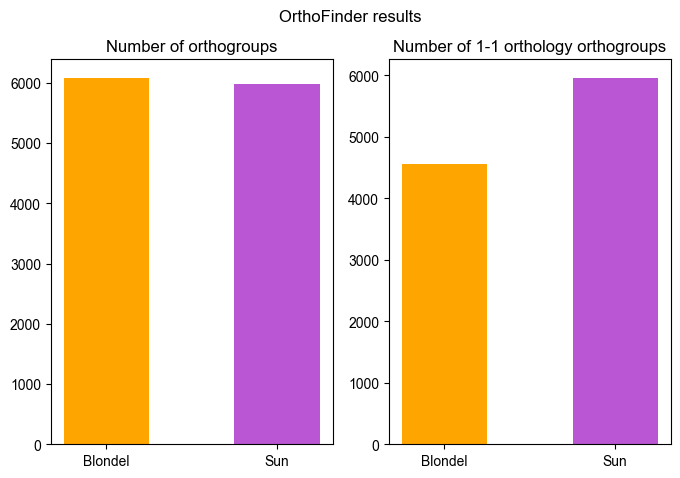

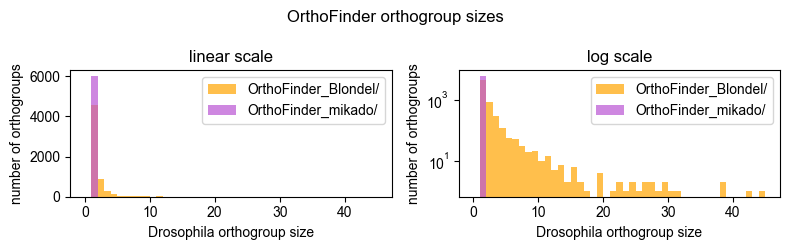

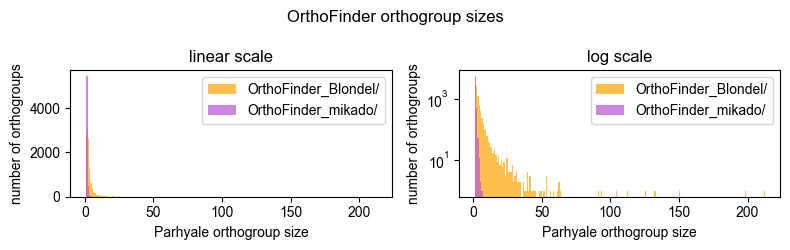

In [111]:
folders = ['OrthoFinder_Blondel/',
           'OrthoFinder_mikado/']
dummynames = ['Blondel', 'Sun']
colors = ['orange', 'mediumorchid']
colordict = dict(zip([i for i in folders],colors))

multiples_hist = {}
multiples_Parhyale_hist = {}
assigned_bar = {}
multiple_bar = {}
unique_bar = {}

for folder in folders:
    assigned = pd.DataFrame(pd.read_csv(folder + 'Orthogroups.tsv', sep='\t'))
    unassigned = pd.DataFrame(pd.read_csv(folder + 'Orthogroups_UnassignedGenes.tsv', sep='\t'))
    
    assigned_annot_list = list(assigned['UP000000803_7227'].astype(str).unique())
    if folder == 'OrthoFinder_Blondel/':
        assigned_Parhyale_list = list(assigned['phaw_5.0.onlyGenes.exons.fasta.transdecoder'].astype(str).unique())
        assigned_Parhyale_multiples = [i for i in assigned_Parhyale_list if ',' in i]
        multiples_Parhyale_hist[folder] = [len(i.split(',')) for i in assigned_Parhyale_list]
    elif folder == 'OrthoFinder_mikado/':
        assigned_Parhyale_list = list(assigned['DAS.mikado.loci.fasta.transdecoder'].astype(str).unique())
        assigned_Parhyale_multiples = [i for i in assigned_Parhyale_list if ',' in i]
        multiples_Parhyale_hist[folder] = [len(i.split(',')) for i in assigned_Parhyale_list]        
    assigned_multiples = [i for i in assigned_annot_list if ',' in i]
    multiples_hist[folder] = [len(i.split(',')) for i in assigned_annot_list]
    assigned_bar[folder] = len(assigned_annot_list)
    multiple_bar[folder] = len(assigned_multiples)
    unique_bar[folder] = assigned_bar[folder] - multiple_bar[folder]
    display(assigned_bar[folder])
    display(multiple_bar[folder])
    
    unassigned_annot_list = list(unassigned['UP000000803_7227'].astype(str).unique())
    display(len(unassigned_annot_list))
    
    display(assigned.head(5))
    display(unassigned.head(5))

    
fig1 = plt.figure(figsize = (8, 5))
plt.suptitle('OrthoFinder results', fontsize = 12)
ax1 = plt.subplot(1, 2, 1)
plt.bar(dummynames, assigned_bar.values(), 0.5, color = colors)
plt.title('Number of orthogroups')

ax2 = plt.subplot(1, 2, 2)
plt.bar(dummynames, unique_bar.values(), 0.5, color = colors)
plt.title('Number of 1-1 orthology orthogroups')


# Plot Drosophila orthogroup sizes
fig2 = plt.figure(figsize = (8, 2.5))
plt.suptitle('OrthoFinder orthogroup sizes', fontsize = 12)
ax = fig2.add_subplot(1, 2, 1)
for i in multiples_hist:
    plt.hist(multiples_hist[i], bins= np.arange(0, max(multiples_hist[i]) + 1), label = i, alpha = 0.7, color = colordict[i], rasterized = True)
plt.title('linear scale')
plt.ylabel('number of orthogroups')
plt.xlabel('Drosophila orthogroup size')
plt.legend(loc = 'upper right')

ax = fig2.add_subplot(1, 2, 2)
for i in multiples_hist:
    plt.hist(multiples_hist[i], bins= np.arange(0, max(multiples_hist[i]) + 1), label = i, alpha = 0.7, color = colordict[i], rasterized = True)
    ax.set_yscale('log')
plt.title('log scale')
plt.ylabel('number of orthogroups')
plt.xlabel('Drosophila orthogroup size')
plt.legend(loc = 'upper right')

plt.tight_layout()

plt.savefig('OrthoFinder_Drosophila_orthogroup_size_histograms.svg')
plt.show()


# Plot Parhyale orthogroup sizes
fig2 = plt.figure(figsize = (8, 2.5))
plt.suptitle('OrthoFinder orthogroup sizes', fontsize = 12)
ax = fig2.add_subplot(1, 2, 1)
for i in multiples_Parhyale_hist:
    plt.hist(multiples_Parhyale_hist[i], bins= np.arange(0, max(multiples_Parhyale_hist[i]) + 1), label = i, alpha = 0.7, color = colordict[i], rasterized = True)
plt.title('linear scale')
plt.ylabel('number of orthogroups')
plt.xlabel('Parhyale orthogroup size')
plt.legend(loc = 'upper right')

ax = fig2.add_subplot(1, 2, 2)
for i in multiples_Parhyale_hist:
    plt.hist(multiples_Parhyale_hist[i], bins= np.arange(0, max(multiples_Parhyale_hist[i]) + 1), label = i, alpha = 0.7, color = colordict[i], rasterized = True)
    ax.set_yscale('log')
plt.title('log scale')
plt.ylabel('number of orthogroups')
plt.xlabel('Parhyale orthogroup size')
plt.legend(loc = 'upper right')

plt.tight_layout()

plt.savefig('OrthoFinder_Parhyale_orthogroup_size_histograms.svg')
plt.show()

In [24]:
dummynames = ['Blondel', 'Mikado']
colors = ['gold', 'mediumorchid']
colordict = dict(zip([i for i in folders],colors))

compilation_list = [len_dict.values(), finallist_size.values(), go_bar.values(), named_dict.values(), unique_dict.values(), assigned_bar.values(), unique_bar.values()]

blondel_values = [list(i)[0] for i in compilation_list]
mikado_values = [list(i)[1] for i in compilation_list]
horizontal_indices = ['Total', 'Assigned\n promoter', 'eggNOG\n GO term\n assigned', 'eggNOG\n named', 'uniquely\n eggNOG\n named', 'OrthoFinder\n orthogroups', 'OrthoFinder\n 1:1\n orthogroups']

horizontal_compiled_bar = pd.DataFrame({'Blondel': blondel_values, 'Mikado': mikado_values}, index = horizontal_indices)
ax = horizontal_compiled_bar.plot.barh(color = colors, figsize = (3, 6))
ax.invert_yaxis()
plt.xlabel('Number of models')

plt.savefig('Mikado_vs_Blondel_model_summaries.svg')

display(horizontal_compiled_bar)

,Blondel,Mikado
Total,15105,21218
Assigned\n promoter,11909,18946
eggNOG\n GO term\n assigned,8925,12226
eggNOG\n named,4949,6850
uniquely\n eggNOG\n named,2610,3771
OrthoFinder\n orthogroups,6087,5982
OrthoFinder\n 1:1\n orthogroups,4566,5964


In [358]:
#Generates a gene-to-transcript map for mRNAs and ncRNAs based on .gff file
annotation = pd.DataFrame(pd.read_csv('~/Labwork/Bioinformatics/Transcripts/' + 'mikado.loci.sorted.gff', sep='\t', header = None))
display(annotation[2].unique())
mRNAs = annotation[annotation[8].astype(str).apply(lambda x: 'Parent' in x) & (annotation[2] == 'mRNA')]
ncRNAs = annotation[annotation[8].astype(str).apply(lambda x: 'Parent' in x) & (annotation[2] == 'ncRNA')]

transcripts = mRNAs.append(ncRNAs)
transcripts.sort_index(inplace = True)

transcripts['Parent'] = transcripts[8].str.split(';', expand = True)[1].str.replace('Parent=', '')
transcripts['ID'] = transcripts[8].str.split(';', expand = True)[0].str.replace('ID=', '')

gene_trans_map = transcripts[['Parent', 'ID']]
gene_trans_map.to_csv('~/Labwork/Bioinformatics/Transcripts/' + 'DAS.mikado.loci.fasta.gene_trans_map', sep='\t', header = None, index = None)
display(gene_trans_map)

array(['superlocus', 'gene', 'mRNA', 'exon', 'three_prime_UTR', 'CDS',
       'five_prime_UTR', 'ncRNA_gene', 'ncRNA'], dtype=object)

,Parent,ID
2,mikado.phaw_50.000008G1,mikado.phaw_50.000008G1.1
14,mikado.phaw_50.000009G1,mikado.phaw_50.000009G1.1
21,mikado.phaw_50.000014G1,mikado.phaw_50.000014G1.1
38,mikado.phaw_50.000014G2,mikado.phaw_50.000014G2.1
51,mikado.phaw_50.000014G3,mikado.phaw_50.000014G3.1
...,...,...
682181,mikado.phaw_50.283875bG10,mikado.phaw_50.283875bG10.1
682192,mikado.phaw_50.283875bG11,mikado.phaw_50.283875bG11.1
682203,mikado.phaw_50.283875bG12,mikado.phaw_50.283875bG12.1
682212,mikado.phaw_50.283875bG13,mikado.phaw_50.283875bG13.1


In [362]:
#made bed file using gff2bed < mikado.loci.sorted.gff > mikado.loci.sorted.bed

bed = pd.DataFrame(pd.read_csv('~/Labwork/Bioinformatics/Transcripts/' + 'mikado.loci.sorted.bed', sep='\t', header = None))
mRNA_bed = bed[bed[7] == 'mRNA']
mRNA_bed.to_csv('~/Labwork/Bioinformatics/Transcripts/' + 'mikado.loci.sorted.mRNAs.bed', sep='\t', header = None, index = None)
display(mRNA_bed)

ncRNA_bed = bed[bed[7] == 'ncRNA']
ncRNA_bed.to_csv('~/Labwork/Bioinformatics/Transcripts/' + 'mikado.loci.sorted.ncRNAs.bed', sep='\t', header = None, index = None)
display(ncRNA_bed)

,0,1,2,3,4,5,6,7,8,9
4,phaw_50.000008,48041,64245,mikado.phaw_50.000008G1.1,22.0,-,Mikado_loci,mRNA,.,ID=mikado.phaw_50.000008G1.1;Parent=mikado.phaw_50.000008G1;Name=mikado.phaw_50.000008G1.1;_aed=...
14,phaw_50.000009,10026,10513,mikado.phaw_50.000009G1.1,19.0,+,Mikado_loci,mRNA,.,ID=mikado.phaw_50.000009G1.1;Parent=mikado.phaw_50.000009G1;Name=mikado.phaw_50.000009G1.1;targe...
23,phaw_50.000014,3629,19158,mikado.phaw_50.000014G1.1,17.0,-,Mikado_loci,mRNA,.,ID=mikado.phaw_50.000014G1.1;Parent=mikado.phaw_50.000014G1;Name=mikado.phaw_50.000014G1.1;targe...
40,phaw_50.000014,91833,122312,mikado.phaw_50.000014G2.1,22.0,-,Mikado_loci,mRNA,.,ID=mikado.phaw_50.000014G2.1;Parent=mikado.phaw_50.000014G2;Name=mikado.phaw_50.000014G2.1;alias...
53,phaw_50.000014,136821,138919,mikado.phaw_50.000014G3.1,20.0,-,Mikado_loci,mRNA,.,ID=mikado.phaw_50.000014G3.1;Parent=mikado.phaw_50.000014G3;Name=mikado.phaw_50.000014G3.1;targe...
...,...,...,...,...,...,...,...,...,...,...
682183,phaw_50.283875b,1351832,1361691,mikado.phaw_50.283875bG10.1,23.0,+,Mikado_loci,mRNA,.,ID=mikado.phaw_50.283875bG10.1;Parent=mikado.phaw_50.283875bG10;Name=mikado.phaw_50.283875bG10.1...
682193,phaw_50.283875b,1404885,1409630,mikado.phaw_50.283875bG11.1,20.0,+,Mikado_loci,mRNA,.,ID=mikado.phaw_50.283875bG11.1;Parent=mikado.phaw_50.283875bG11;Name=mikado.phaw_50.283875bG11.1...
682205,phaw_50.283875b,1489478,1489852,mikado.phaw_50.283875bG12.1,15.0,-,Mikado_loci,mRNA,.,ID=mikado.phaw_50.283875bG12.1;Parent=mikado.phaw_50.283875bG12;Name=mikado.phaw_50.283875bG12.1...
682213,phaw_50.283875b,1518894,1519376,mikado.phaw_50.283875bG13.1,17.0,-,Mikado_loci,mRNA,.,ID=mikado.phaw_50.283875bG13.1;Parent=mikado.phaw_50.283875bG13;Name=mikado.phaw_50.283875bG13.1...


,0,1,2,3,4,5,6,7,8,9
807,phaw_50.000071,39482,41268,mikado.phaw_50.000071G1.1,18.0,+,Mikado_loci,ncRNA,.,ID=mikado.phaw_50.000071G1.1;Parent=mikado.phaw_50.000071G1;alias=st2m_STRG.61.1;canonical_junct...
1213,phaw_50.000081a,492694,494506,mikado.phaw_50.000081aG12.1,18.0,+,Mikado_loci,ncRNA,.,ID=mikado.phaw_50.000081aG12.1;Parent=mikado.phaw_50.000081aG12;alias=st2m_STRG.92.1;canonical_j...
2289,phaw_50.000081a,3687205,3688487,mikado.phaw_50.000081aG77.1,18.0,+,Mikado_loci,ncRNA,.,ID=mikado.phaw_50.000081aG77.1;Parent=mikado.phaw_50.000081aG77;alias=st2m_STRG.189.1;canonical_...
2415,phaw_50.000081a,4142378,4144419,mikado.phaw_50.000081aG90.1,18.0,+,Mikado_loci,ncRNA,.,ID=mikado.phaw_50.000081aG90.1;Parent=mikado.phaw_50.000081aG90;alias=st2m_STRG.211.1;canonical_...
5508,phaw_50.000135b,1662731,1662803,mikado.phaw_50.000135bG33.1,18.0,+,Mikado_loci,ncRNA,.,ID=mikado.phaw_50.000135bG33.1;Parent=mikado.phaw_50.000135bG33;_aed=1;_qi=0|-1|0|0|-1|0|1|73|0;...
...,...,...,...,...,...,...,...,...,...,...
680713,phaw_50.283875a,24151486,24151559,mikado.phaw_50.283875aG455.1,18.0,-,Mikado_loci,ncRNA,.,ID=mikado.phaw_50.283875aG455.1;Parent=mikado.phaw_50.283875aG455;_aed=1;_qi=0|-1|0|0|-1|0|1|74|...
680725,phaw_50.283875a,24161859,24161932,mikado.phaw_50.283875aG456.1,18.0,-,Mikado_loci,ncRNA,.,ID=mikado.phaw_50.283875aG456.1;Parent=mikado.phaw_50.283875aG456;_aed=1;_qi=0|-1|0|0|-1|0|1|74|...
680728,phaw_50.283875a,24162344,24162417,mikado.phaw_50.283875aG457.1,18.0,-,Mikado_loci,ncRNA,.,ID=mikado.phaw_50.283875aG457.1;Parent=mikado.phaw_50.283875aG457;_aed=1;_qi=0|-1|0|0|-1|0|1|74|...
681318,phaw_50.283875a,25281764,25281989,mikado.phaw_50.283875aG479.1,18.0,+,Mikado_loci,ncRNA,.,ID=mikado.phaw_50.283875aG479.1;Parent=mikado.phaw_50.283875aG479;_aed=0;_qi=0|-1|0|1|-1|1|1|0|7...


In [108]:
guess_promoter = True
guess_others = True
compile_guesses = True
compile_distances = True
compile_nearest_gene = True

all_dict = {}
startinglist_size = {}
finallist_size = {}
ratios = {}
hist_strength = {}

if guess_promoter:
    modelname = 'mikado.loci.genesonly.gff'
    dataloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/'
    genesonly = pd.read_csv(dataloc + modelname, header = None, sep = '\t')
    
    genesonly['size'] = genesonly.apply(lambda row: int(row[4]) - int(row[3]), axis = 1)
    genesonly = genesonly[genesonly['size'] > 500]
    startinglist_size[modelname] = len(genesonly)
    genesonly['newstart'] = genesonly.apply(lambda row: int(row[3]) if row[6] == '+' else int(row[4]) - 200, axis = 1)
    genesonly['newend'] = genesonly.apply(lambda row: int(row[4]) if row[6] == '-' else int(row[3]) + 200, axis = 1)

    geneendsname = modelname.replace('genesonly', 'geneends')
    geneendsloc = dataloc + geneendsname
    geneends = genesonly[[0, 1, 2, 'newstart', 'newend', 5, 6, 7, 8]]
    geneends.to_csv(geneendsloc, header = None, sep = '\t', index = None)
    geneendssorted = geneendsloc.replace('geneends', 'geneends.sorted')
    !/usr/local/bin/bedtools sort -i $geneendsloc > $geneendssorted

    #Specify the location of the final manual annotation file
    peaks_file = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/OmniATAC_bothruns_q005_allpeaks.igv_new.gff'
    original = pd.read_csv(peaks_file, sep = '\t', header = None)
    original['contig_start_end'] = original[0].astype(str) + '_' + original[3].astype(str) + '_' + original[4].astype(str)
    all_dict['original'] = original
    outputloc = dataloc + modelname.replace('.genesonly.gff', '.geneends.closest.gff')
    !/usr/local/bin/bedtools closest -D a -a $geneendssorted -b $peaks_file > $outputloc
    
    promoter_guesses = pd.read_csv(outputloc, header = None, sep = '\t')
    promoter_guesses = promoter_guesses[abs(promoter_guesses[18]) < 5000]
    promoter_guesses = promoter_guesses[promoter_guesses[18] != -1]
    promoter_guesses['IGV_address'] = promoter_guesses[9].astype(str) + ":" + promoter_guesses[12].astype(str) + "-" + promoter_guesses[13].astype(str)
    promoter_guesses['contig_start_end'] = promoter_guesses[9].astype(str) + "_" + promoter_guesses[12].astype(str) + "_" + promoter_guesses[13].astype(str)
    all_dict['promoters'] = promoter_guesses

if guess_others:
    modelname = 'mikado.loci.sorted.gff'
    dataloc = '~/Labwork/Bioinformatics/Transcripts/'
    allgffloc = dataloc + modelname
    allgffs = pd.read_csv(dataloc + modelname, header = None, sep = '\t', skiprows = 1)
    exons = allgffs[allgffs[2].isin(['exon', 'three_prime_UTR', 'five_prime_UTR'])]
    exonsloc = dataloc + modelname.replace('.sorted', '.exons_utrs.')
    exons.to_csv(exonsloc, index = None, header = None, sep = '\t')
    rnas = allgffs[allgffs[2].isin(['gene', 'ncRNA_gene'])]
    rnasloc = dataloc + modelname.replace('.sorted', '.rnas.')
    rnas.to_csv(rnasloc, index = None, header = None, sep = '\t')
    
    #Specify the location of the final manual annotation file
    peaks_file = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/OmniATAC_bothruns_q005_allpeaks.igv_new.gff'
    exons_outputloc = exonsloc.replace('.gff', '.closestpeaks.gff')
    rnas_outputloc = rnasloc.replace('.gff', '.closestpeaks.gff')
    !/usr/local/bin/bedtools closest -D a -t first -fu -a $peaks_file -b $exonsloc > $exons_outputloc
    !/usr/local/bin/bedtools closest -D a -t first -fu -a $peaks_file -b $rnasloc > $rnas_outputloc
    
    exons_guesses = pd.read_csv(exons_outputloc, header = None, sep = '\t')
    exons_guesses['contig_start_end'] = exons_guesses[0].astype(str) + '_' + exons_guesses[3].astype(str) + '_' + exons_guesses[4].astype(str)
    exons_true = exons_guesses[exons_guesses[18] == 0]
    all_dict['exons'] = exons_true
    all_dict['exons_possible'] = exons_guesses[exons_guesses[18] != 0]
    rnas_guesses = pd.read_csv(rnas_outputloc, header = None, sep = '\t')
    rnas_guesses['contig_start_end'] = rnas_guesses[0].astype(str) + '_' + rnas_guesses[3].astype(str) + '_' + rnas_guesses[4].astype(str)
    rnas_true = rnas_guesses[rnas_guesses[18] == 0]
    all_dict['rnas'] = rnas_true
    all_dict['rnas_possible'] = rnas_guesses[rnas_guesses[18] != 0]

if compile_nearest_gene:
    all_dict['promoters']['nearest_gene'] = all_dict['promoters'][8].str.split(';', expand = True)[0].str.replace('ID=', '')
    
    all_dict['exons'][['a', 'b', 'c', 'd']] = all_dict['exons'][17].str.split(';', expand = True)[1].str.replace('Parent=', '').str.split('.', expand = True)
    all_dict['exons']['nearest_gene'] = all_dict['exons'][['a', 'b', 'c']].agg('.'.join, axis = 1)
    
    all_dict['exons_possible'][['a', 'b', 'c', 'd']] = all_dict['exons_possible'][17].str.split(';', expand = True)[1].str.replace('Parent=', '').str.split('.', expand = True)
    all_dict['exons_possible']['nearest_gene'] = all_dict['exons_possible']['a'].astype('str') + '.' + all_dict['exons_possible']['b'].astype('str') + '.' + all_dict['exons_possible']['c'].astype('str')
    
    all_dict['rnas']['nearest_gene'] = all_dict['rnas'][17].str.split(';', expand = True)[1].str.replace('Name=', '')
    
if compile_guesses:
    original = all_dict['original']
    all_dict['promoters']['type'] = 'promoter'
    promoters = original.merge(all_dict['promoters'][['contig_start_end', 'type', 'nearest_gene']])
    original_nopro = original[~original['contig_start_end'].isin(promoters['contig_start_end'])]
    all_dict['exons']['type'] = all_dict['exons'][11]
    exons = original_nopro.merge(all_dict['exons'][['contig_start_end', 'type', 'nearest_gene']])
    original_noexon = original_nopro[~original_nopro['contig_start_end'].isin(exons['contig_start_end'])]
    all_dict['rnas']['type'] = all_dict['rnas'][11]
    introns = original_noexon.merge(all_dict['rnas'][['contig_start_end', 'type', 'nearest_gene']])
    original_intergenic = original_noexon[~original_noexon['contig_start_end'].isin(introns['contig_start_end'])]
    intergenic = original_intergenic.merge(all_dict['exons_possible'][['contig_start_end', 13, 18, 'nearest_gene']])
    identified = intergenic[intergenic[13] != -1]
    proximal_intergenic = identified[abs(identified[18]) <= 10000]
    proximal_intergenic['type'] = 'proximal_intergenic'
    distal_intergenic = identified[~identified['contig_start_end'].isin(proximal_intergenic['contig_start_end'])]
    distal_intergenic['type'] = 'distal_intergenic'
    remain = intergenic[intergenic[13] == -1]
    remain['type'] = 'unknown'
    
    compiled = promoters.append(exons).append(introns).append(proximal_intergenic).append(distal_intergenic).append(remain)
    
    if compile_nearest_gene:
        compiled_nearestgene = compiled[[0, 'type', 'contig_start_end', 3, 4, 5, 6, 7, 2, 'nearest_gene']].drop_duplicates(['contig_start_end'])
        compiled_nearestgeneloc = dataloc + 'Sall_peaktypes_nearestgene.gff'
        compiled_nearestgene.to_csv(compiled_nearestgeneloc, sep = '\t', header = None, index = None)
        
    if compile_distances:
        compiled_distances = compiled[[0, 'type', 'contig_start_end', 3, 4, 5, 6, 7, 2, 'nearest_gene', 18]].drop_duplicates(['contig_start_end'])
        compiled_distancesloc = dataloc + 'Sall_peaktypes_distances.gff'
        compiled_distances.to_csv(compiled_distancesloc, sep = '\t', header = None, index = None)
    
    compiled.reset_index(inplace = True)
    
    compiled_outloc = dataloc + 'Sall_peaktypes.gff'
    compiled_out = compiled[[0, 'type', 'contig_start_end', 3, 4, 5, 6, 7, 2]].drop_duplicates()
    compiled_out.to_csv(compiled_outloc, sep = '\t', header = None, index = None)
    
    all_dict['compiled'] = compiled_out

display(compiled_out)

if compile_nearest_gene:
    display(compiled_nearestgene)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-108-9e5c5f8be72b>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,0,type,contig_start_end,3,4,5,6,7,2
0,phaw_50.000023,promoter,phaw_50.000023_39987_40643,39987,40643,COUNT=2;SCORE_MEAN=351;SIGNAL_MEAN=225.3805085;-log10(p)_MAX=3.966765;-log10(p)_MIN=3.94913;-log...,+,.,2
1,phaw_50.000023,promoter,phaw_50.000023_121270_121683,121270,121683,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=432.315552;-log10(p)_MAX=5.709125;-log10(p)_MIN=5.709125;-lo...,+,.,1
2,phaw_50.000027,promoter,phaw_50.000027_69831_70633,69831,70633,COUNT=6;SCORE_MEAN=658.6666667;SIGNAL_MEAN=495.1125947;-log10(p)_MAX=5.650686;-log10(p)_MIN=4.16...,+,.,6
3,phaw_50.000027,promoter,phaw_50.000027_157829_158672,157829,158672,COUNT=4;SCORE_MEAN=853;SIGNAL_MEAN=678.4532545;-log10(p)_MAX=7.638493;-log10(p)_MIN=5.39596;-log...,+,.,4
5,phaw_50.000028,promoter,phaw_50.000028_21120_21638,21120,21638,COUNT=7;SCORE_MEAN=728.4285714;SIGNAL_MEAN=325.6438557;-log10(p)_MAX=5.258597;-log10(p)_MIN=3.99...,+,.,7
...,...,...,...,...,...,...,...,...,...
191156,phaw_50.283856,unknown,phaw_50.283856_46103_47590,46103,47590,COUNT=17;SCORE_MEAN=922.3529412;SIGNAL_MEAN=1498.451131;-log10(p)_MAX=10.31401;-log10(p)_MIN=4.3...,+,.,17
191157,phaw_50.283856,unknown,phaw_50.283856_54876_55716,54876,55716,COUNT=14;SCORE_MEAN=965.3571429;SIGNAL_MEAN=729.0515604;-log10(p)_MAX=7.341001;-log10(p)_MIN=4.6...,+,.,14
191158,phaw_50.283858,unknown,phaw_50.283858_1105_1719,1105,1719,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=2300.867057;-log10(p)_MAX=11.550564;-log10(p)_MIN=8.902076;...,+,.,15
191159,phaw_50.283858,unknown,phaw_50.283858_6445_6923,6445,6923,COUNT=5;SCORE_MEAN=846.8;SIGNAL_MEAN=325.5418152;-log10(p)_MAX=6.457194;-log10(p)_MIN=4.907079;-...,+,.,5


,0,type,contig_start_end,3,4,5,6,7,2,nearest_gene
0,phaw_50.000023,promoter,phaw_50.000023_39987_40643,39987,40643,COUNT=2;SCORE_MEAN=351;SIGNAL_MEAN=225.3805085;-log10(p)_MAX=3.966765;-log10(p)_MIN=3.94913;-log...,+,.,2,mikado.phaw_50.000023G1
1,phaw_50.000023,promoter,phaw_50.000023_121270_121683,121270,121683,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=432.315552;-log10(p)_MAX=5.709125;-log10(p)_MIN=5.709125;-lo...,+,.,1,mikado.phaw_50.000023G4
2,phaw_50.000027,promoter,phaw_50.000027_69831_70633,69831,70633,COUNT=6;SCORE_MEAN=658.6666667;SIGNAL_MEAN=495.1125947;-log10(p)_MAX=5.650686;-log10(p)_MIN=4.16...,+,.,6,mikado.phaw_50.000027G3
3,phaw_50.000027,promoter,phaw_50.000027_157829_158672,157829,158672,COUNT=4;SCORE_MEAN=853;SIGNAL_MEAN=678.4532545;-log10(p)_MAX=7.638493;-log10(p)_MIN=5.39596;-log...,+,.,4,mikado.phaw_50.000027G6
5,phaw_50.000028,promoter,phaw_50.000028_21120_21638,21120,21638,COUNT=7;SCORE_MEAN=728.4285714;SIGNAL_MEAN=325.6438557;-log10(p)_MAX=5.258597;-log10(p)_MIN=3.99...,+,.,7,mikado.phaw_50.000028G1
...,...,...,...,...,...,...,...,...,...,...
139244,phaw_50.283856,unknown,phaw_50.283856_46103_47590,46103,47590,COUNT=17;SCORE_MEAN=922.3529412;SIGNAL_MEAN=1498.451131;-log10(p)_MAX=10.31401;-log10(p)_MIN=4.3...,+,.,17,None.None.None
139245,phaw_50.283856,unknown,phaw_50.283856_54876_55716,54876,55716,COUNT=14;SCORE_MEAN=965.3571429;SIGNAL_MEAN=729.0515604;-log10(p)_MAX=7.341001;-log10(p)_MIN=4.6...,+,.,14,None.None.None
139246,phaw_50.283858,unknown,phaw_50.283858_1105_1719,1105,1719,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=2300.867057;-log10(p)_MAX=11.550564;-log10(p)_MIN=8.902076;...,+,.,15,None.None.None
139247,phaw_50.283858,unknown,phaw_50.283858_6445_6923,6445,6923,COUNT=5;SCORE_MEAN=846.8;SIGNAL_MEAN=325.5418152;-log10(p)_MAX=6.457194;-log10(p)_MIN=4.907079;-...,+,.,5,None.None.None


In [151]:
display(all_dict['rnas'])

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,contig_start_end,nearest_gene,type
59,phaw_50.000028,bed2gff,7,21120,21638,COUNT=7;SCORE_MEAN=728.4285714;SIGNAL_MEAN=325.6438557;-log10(p)_MAX=5.258597;-log10(p)_MIN=3.99...,+,.,7;,phaw_50.000028,...,17874,31753,17,+,.,ID=mikado.phaw_50.000028G1;Name=mikado.phaw_50.000028G1;multiexonic=True;superlocus=Mikado_super...,0,phaw_50.000028_21120_21638,mikado.phaw_50.000028G1,gene
68,phaw_50.000038,bed2gff,5,39,474,COUNT=5;SCORE_MEAN=855;SIGNAL_MEAN=366.4183776;-log10(p)_MAX=5.045541;-log10(p)_MIN=4.127027;-lo...,+,.,5;,phaw_50.000038,...,299,643,19,+,.,ID=mikado.phaw_50.000038G1;Name=mikado.phaw_50.000038G1;multiexonic=False;superlocus=Mikado_supe...,0,phaw_50.000038_39_474,mikado.phaw_50.000038G1,gene
76,phaw_50.000041,bed2gff,15,95396,96175,COUNT=15;SCORE_MEAN=997.9333333;SIGNAL_MEAN=856.6102335;-log10(p)_MAX=6.676847;-log10(p)_MIN=4.8...,+,.,15;,phaw_50.000041,...,77796,125569,20,+,.,ID=mikado.phaw_50.000041G1;Name=mikado.phaw_50.000041G1;multiexonic=True;superlocus=Mikado_super...,0,phaw_50.000041_95396_96175,mikado.phaw_50.000041G1,gene
77,phaw_50.000041,bed2gff,9,115051,116462,COUNT=9;SCORE_MEAN=704.7777778;SIGNAL_MEAN=564.5859342;-log10(p)_MAX=6.001868;-log10(p)_MIN=4.24...,+,.,9;,phaw_50.000041,...,77796,125569,20,+,.,ID=mikado.phaw_50.000041G1;Name=mikado.phaw_50.000041G1;multiexonic=True;superlocus=Mikado_super...,0,phaw_50.000041_115051_116462,mikado.phaw_50.000041G1,gene
78,phaw_50.000041,bed2gff,5,123454,123706,COUNT=5;SCORE_MEAN=1000;SIGNAL_MEAN=367.9242798;-log10(p)_MAX=6.183949;-log10(p)_MIN=5.345132;-l...,+,.,5;,phaw_50.000041,...,77796,125569,20,+,.,ID=mikado.phaw_50.000041G1;Name=mikado.phaw_50.000041G1;multiexonic=True;superlocus=Mikado_super...,0,phaw_50.000041_123454_123706,mikado.phaw_50.000041G1,gene
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183819,phaw_50.283872c,bed2gff,1,172235,172724,COUNT=1;SCORE_MEAN=610;SIGNAL_MEAN=298.858337;-log10(p)_MAX=4.699354;-log10(p)_MIN=4.699354;-log...,+,.,1;,phaw_50.283872c,...,23080,174082,18,-,.,ID=mikado.phaw_50.283872cG1;Name=mikado.phaw_50.283872cG1;multiexonic=True;superlocus=Mikado_sup...,0,phaw_50.283872c_172235_172724,mikado.phaw_50.283872cG1,gene
183820,phaw_50.283872c,bed2gff,1,174049,174210,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=256.293427;-log10(p)_MAX=6.619758;-log10(p)_MIN=6.619758;-lo...,+,.,1;,phaw_50.283872c,...,23080,174082,18,-,.,ID=mikado.phaw_50.283872cG1;Name=mikado.phaw_50.283872cG1;multiexonic=True;superlocus=Mikado_sup...,0,phaw_50.283872c_174049_174210,mikado.phaw_50.283872cG1,gene
185777,phaw_50.283873b,bed2gff,7,15642,16319,COUNT=7;SCORE_MEAN=841.2857143;SIGNAL_MEAN=481.9225354;-log10(p)_MAX=10.036862;-log10(p)_MIN=4.8...,+,.,7;,phaw_50.283873b,...,15677,16084,17,+,.,ID=mikado.phaw_50.283873bG1;Name=mikado.phaw_50.283873bG1;multiexonic=False;superlocus=Mikado_su...,0,phaw_50.283873b_15642_16319,mikado.phaw_50.283873bG1,gene
187240,phaw_50.283874b,bed2gff,15,288649,289341,COUNT=15;SCORE_MEAN=946.7333333;SIGNAL_MEAN=863.7605143;-log10(p)_MAX=8.223534;-log10(p)_MIN=4.5...,+,.,15;,phaw_50.283874b,...,266279,289092,15,-,.,ID=mikado.phaw_50.283874bG3;Name=mikado.phaw_50.283874bG3;multiexonic=True;superlocus=Mikado_sup...,0,phaw_50.283874b_288649_289341,mikado.phaw_50.283874bG3,gene


{'distal_intergenic': 97335,
 'proximal_intergenic': 38243,
 'unknown': 34571,
 'promoter': 17863,
 'exon': 1032,
 'gene': 1021,
 'ncRNA_gene': 13}

{'all_peaks': [34571, 97335, 38243, 17863, 1032, 1021, 13]}

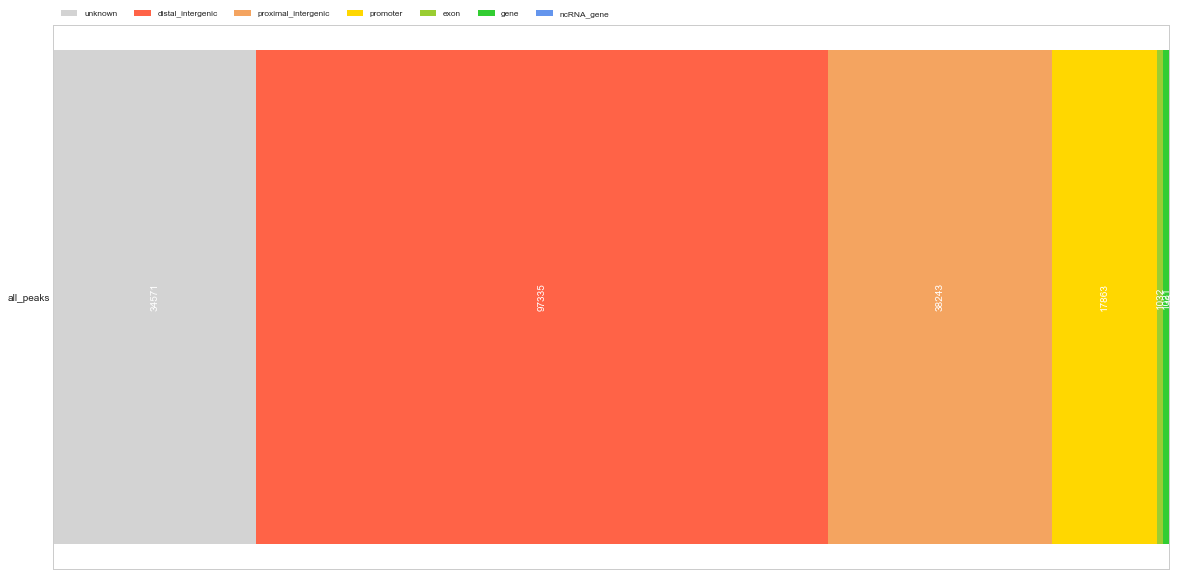

In [140]:
counts = dict(all_dict['compiled']['type'].value_counts())
display(counts)

category_names = ['unknown', 'distal_intergenic', 'proximal_intergenic', 'promoter', 'exon', 'gene', 'ncRNA_gene']
reordered_counts = {}
    
for peaktype in category_names:
    if peaktype in list(counts.keys()):
        reordered_counts[peaktype] = counts[peaktype]
    else:
        reordered_counts[peaktype] = 0

results = {}

results['all_peaks'] = [i for i in list(reordered_counts.values())]

display(results)


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = ['lightgray', 'tomato', 'sandybrown', 'gold', 'yellowgreen', 'limegreen', 'cornflowerblue', 'mediumslateblue']

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        #r, g, b, _ = color
        text_color = 'white'
        ax.bar_label(rects, label_type='center', color=text_color, rotation = 90)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

survey(results, category_names)
plt.show()

# Plot Gene-Peak Distance Distribution

,0,1,2,3,4,5,6,7,8,9,10
19929,phaw_50.000009,proximal_intergenic,phaw_50.000009_11629_11888,11629,11888,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=269.657501;-log10(p)_MAX=5.01003;-log10(p)_MIN=5.01003;-log1...,+,.,1,mikado.phaw_50.000009G1,-1116.0
19930,phaw_50.000014,proximal_intergenic,phaw_50.000014_206407_207519,206407,207519,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=1376.176314;-log10(p)_MAX=10.238941;-log10(p)_MIN=7.131846;...,+,.,15,mikado.phaw_50.000014G4,-8489.0
19931,phaw_50.000023,proximal_intergenic,phaw_50.000023_12096_12730,12096,12730,COUNT=15;SCORE_MEAN=956.7333333;SIGNAL_MEAN=526.3169403;-log10(p)_MAX=6.819659;-log10(p)_MIN=4.8...,+,.,15,mikado.phaw_50.000023G2,7768.0
19932,phaw_50.000023,proximal_intergenic,phaw_50.000023_87809_88060,87809,88060,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=631.877686;-log10(p)_MAX=7.602784;-log10(p)_MIN=7.602784;-lo...,+,.,1,mikado.phaw_50.000023G3,-5597.0
19933,phaw_50.000023,proximal_intergenic,phaw_50.000023_90731_91181,90731,91181,COUNT=4;SCORE_MEAN=680.5;SIGNAL_MEAN=296.6584663;-log10(p)_MAX=4.658824;-log10(p)_MIN=4.162148;-...,+,.,4,mikado.phaw_50.000023G3,-8519.0
...,...,...,...,...,...,...,...,...,...,...,...
155502,phaw_50.283875b,distal_intergenic,phaw_50.283875b_1477585_1478169,1477585,1478169,COUNT=7;SCORE_MEAN=959.8571429;SIGNAL_MEAN=486.7580914;-log10(p)_MAX=6.537003;-log10(p)_MIN=4.93...,+,.,7,mikado.phaw_50.283875bG11,-67955.0
155503,phaw_50.283875b,distal_intergenic,phaw_50.283875b_1535467_1535680,1535467,1535680,COUNT=2;SCORE_MEAN=1000;SIGNAL_MEAN=223.467064;-log10(p)_MAX=5.899739;-log10(p)_MIN=5.556468;-lo...,+,.,2,mikado.phaw_50.283875bG13,-16091.0
155504,phaw_50.283875b,distal_intergenic,phaw_50.283875b_1546842_1547714,1546842,1547714,COUNT=13;SCORE_MEAN=926.4615385;SIGNAL_MEAN=1193.281705;-log10(p)_MAX=11.16451;-log10(p)_MIN=4.8...,+,.,13,mikado.phaw_50.283875bG13,-27466.0
155505,phaw_50.283875b,distal_intergenic,phaw_50.283875b_1548469_1548807,1548469,1548807,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=384.672821;-log10(p)_MAX=5.47358;-log10(p)_MIN=5.47358;-log1...,+,.,1,mikado.phaw_50.283875bG13,-29093.0


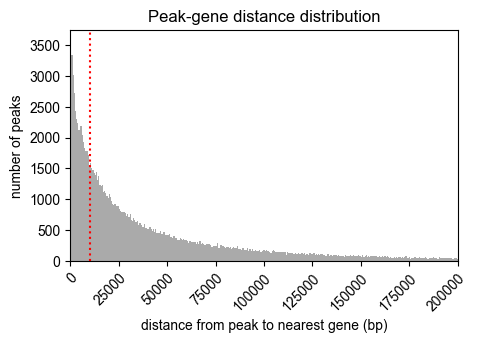

In [73]:
peak_classes = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/Transcripts/" + "Sall_peaktypes_distances.gff", sep = '\t', header = None))
peak_classes = peak_classes[peak_classes[10].notna()]
peak_classes = peak_classes[peak_classes[10] != -1]
display(peak_classes)

distances_list = [abs(x) for x in peak_classes[10]]

plt.figure(figsize = (5, 3))

plt.hist(distances_list, bins = 2000, color = '#AAAAAA')
ax = plt.gca()
ylims = ax.get_ylim()

plt.vlines(10000, 0, 4000, color = 'r', linestyle = 'dotted')
plt.ylim(ylims)
plt.xlim((0, 200000))
plt.xlabel('distance from peak to nearest gene (bp)')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.ylabel('number of peaks')
plt.title('Peak-gene distance distribution')

plt.savefig('OmniATAC_peak-gene_distance_distribution.svg')

plt.show()

In [44]:
guess_promoter = True
guess_others = True
compile_guesses = True

results = {}

stage_list = ['S13', 'S14', 'S15', 'S17', 'S18', 'S19', 'S19plus', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27']
name_generator = [stage + 'A_bothruns_q10.Genrich_sorted.ATAC.q005.narrowPeak.gff' for stage in stage_list]

peak_classes = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/Transcripts/" + "Sall_peaktypes.gff", sep = '\t', header = None))

counts = dict(peak_classes[1].value_counts())

category_names = ['unknown', 'distal_intergenic', 'proximal_intergenic', 'promoter', 'exon', 'gene', 'ncRNA_gene']
reordered_counts = {}
    
for peaktype in category_names:
    if peaktype in list(counts.keys()):
        reordered_counts[peaktype] = counts[peaktype]
    else:
        reordered_counts[peaktype] = 0

results['all peaks'] = [i for i in list(reordered_counts.values())]

stage_dict = {}

for peaks in name_generator:
    all_dict = {}
    peaks_prefix = peaks.split('A_')[0]
    
    peak_classesloc = "~/Labwork/Bioinformatics/Transcripts/" + "Sall_peaktypes.sorted.gff"
    dataloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/SLURM_scripts/q005_narrowPeak/'
    peaks_file = dataloc + peaks
    peak_classes_outputloc = peak_classesloc.replace('Sall', peaks_prefix).replace('sorted', 'nearest')
    !/usr/local/bin/bedtools closest -D a -t first -a $peaks_file -b $peak_classesloc > $peak_classes_outputloc
    
    original = pd.read_csv(peaks_file, header = None, sep = '\t')
    peak_classification = pd.read_csv(peak_classes_outputloc, header = None, sep = '\t')

    stage_dict[peaks_prefix] = peak_classification
    counts = dict(peak_classification[10].value_counts())
    
    reordered_counts = {}
    
    for peaktype in category_names:
        if peaktype in list(counts.keys()):
            reordered_counts[peaktype] = counts[peaktype]
        else:
            reordered_counts[peaktype] = 0
    
    results[peaks_prefix] = [i for i in list(reordered_counts.values())]

display(results)

results_fraction = {}
for i in results:
    results_fraction[i] = [np.round(j / sum(results[i]), 3) for j in results[i]]

display(results_fraction)

results_summed = {}

for stage in results:
    results_summed[stage] = sum(results[stage])

display(results_summed)

{'all peaks': [34571, 97335, 38243, 17863, 1032, 1021, 13],
 'S13': [17534, 26241, 13912, 6587, 912, 608, 7],
 'S14': [18664, 24730, 12917, 6290, 909, 618, 7],
 'S15': [18379, 24897, 12820, 6275, 891, 581, 7],
 'S17': [18081, 31106, 15378, 7215, 904, 618, 5],
 'S18': [19555, 35576, 17535, 7661, 934, 648, 8],
 'S19': [18711, 38162, 18242, 7809, 921, 625, 8],
 'S19plus': [17994, 40141, 18982, 8001, 920, 627, 7],
 'S20': [18237, 47589, 21785, 8506, 905, 640, 8],
 'S21': [20673, 59234, 24647, 8743, 874, 684, 5],
 'S22': [23503, 47021, 19727, 7665, 931, 656, 9],
 'S23': [17593, 56959, 23571, 8898, 867, 598, 6],
 'S24': [16775, 56079, 22997, 8904, 847, 632, 5],
 'S25': [17178, 51676, 21441, 8767, 855, 585, 5],
 'S26': [17413, 53843, 22056, 8851, 840, 593, 6],
 'S27': [17870, 51587, 21036, 8659, 824, 598, 5]}

{'all peaks': [0.182, 0.512, 0.201, 0.094, 0.005, 0.005, 0.0],
 'S13': [0.266, 0.399, 0.211, 0.1, 0.014, 0.009, 0.0],
 'S14': [0.291, 0.386, 0.201, 0.098, 0.014, 0.01, 0.0],
 'S15': [0.288, 0.39, 0.201, 0.098, 0.014, 0.009, 0.0],
 'S17': [0.247, 0.424, 0.21, 0.098, 0.012, 0.008, 0.0],
 'S18': [0.239, 0.434, 0.214, 0.094, 0.011, 0.008, 0.0],
 'S19': [0.221, 0.452, 0.216, 0.092, 0.011, 0.007, 0.0],
 'S19plus': [0.208, 0.463, 0.219, 0.092, 0.011, 0.007, 0.0],
 'S20': [0.187, 0.487, 0.223, 0.087, 0.009, 0.007, 0.0],
 'S21': [0.18, 0.516, 0.215, 0.076, 0.008, 0.006, 0.0],
 'S22': [0.236, 0.473, 0.198, 0.077, 0.009, 0.007, 0.0],
 'S23': [0.162, 0.525, 0.217, 0.082, 0.008, 0.006, 0.0],
 'S24': [0.158, 0.528, 0.216, 0.084, 0.008, 0.006, 0.0],
 'S25': [0.171, 0.514, 0.213, 0.087, 0.009, 0.006, 0.0],
 'S26': [0.168, 0.52, 0.213, 0.085, 0.008, 0.006, 0.0],
 'S27': [0.178, 0.513, 0.209, 0.086, 0.008, 0.006, 0.0]}

{'all peaks': 190078,
 'S13': 65801,
 'S14': 64135,
 'S15': 63850,
 'S17': 73307,
 'S18': 81917,
 'S19': 84478,
 'S19plus': 86672,
 'S20': 97670,
 'S21': 114860,
 'S22': 99512,
 'S23': 108492,
 'S24': 106239,
 'S25': 100507,
 'S26': 103602,
 'S27': 100579}

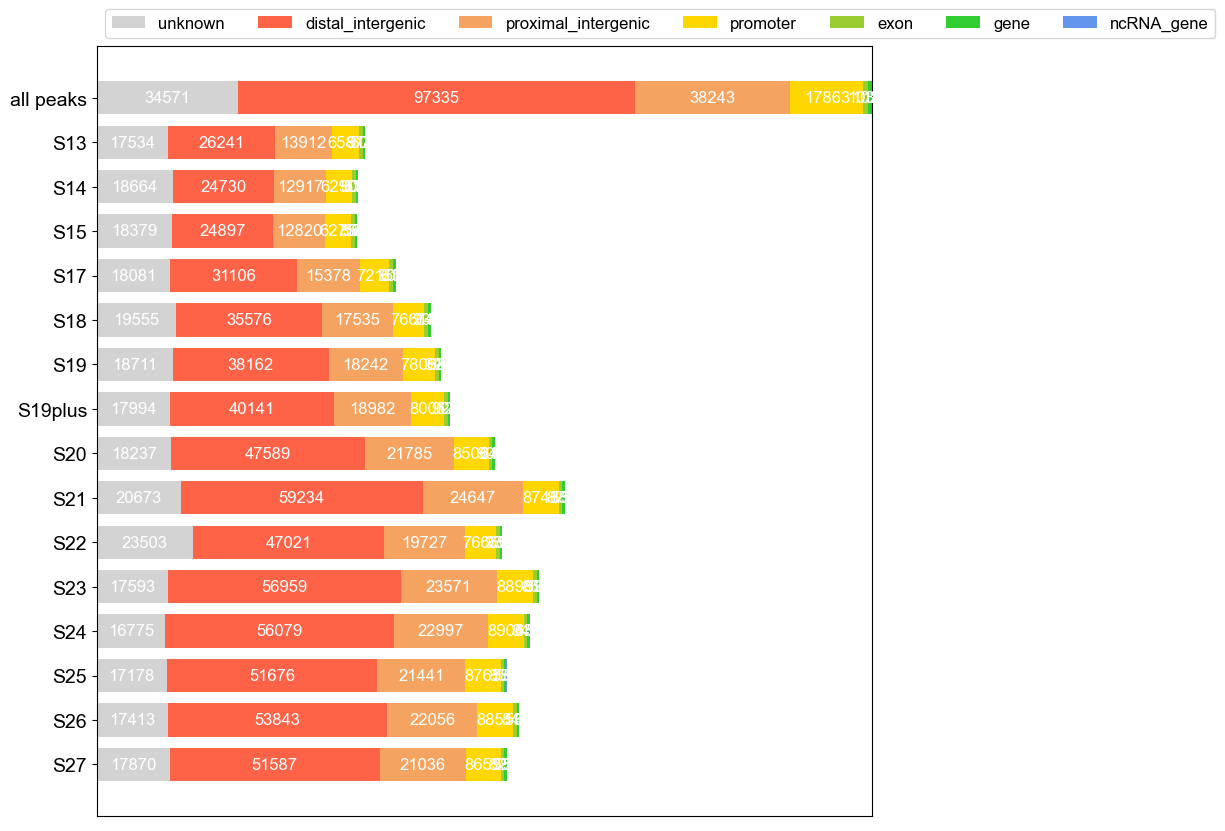

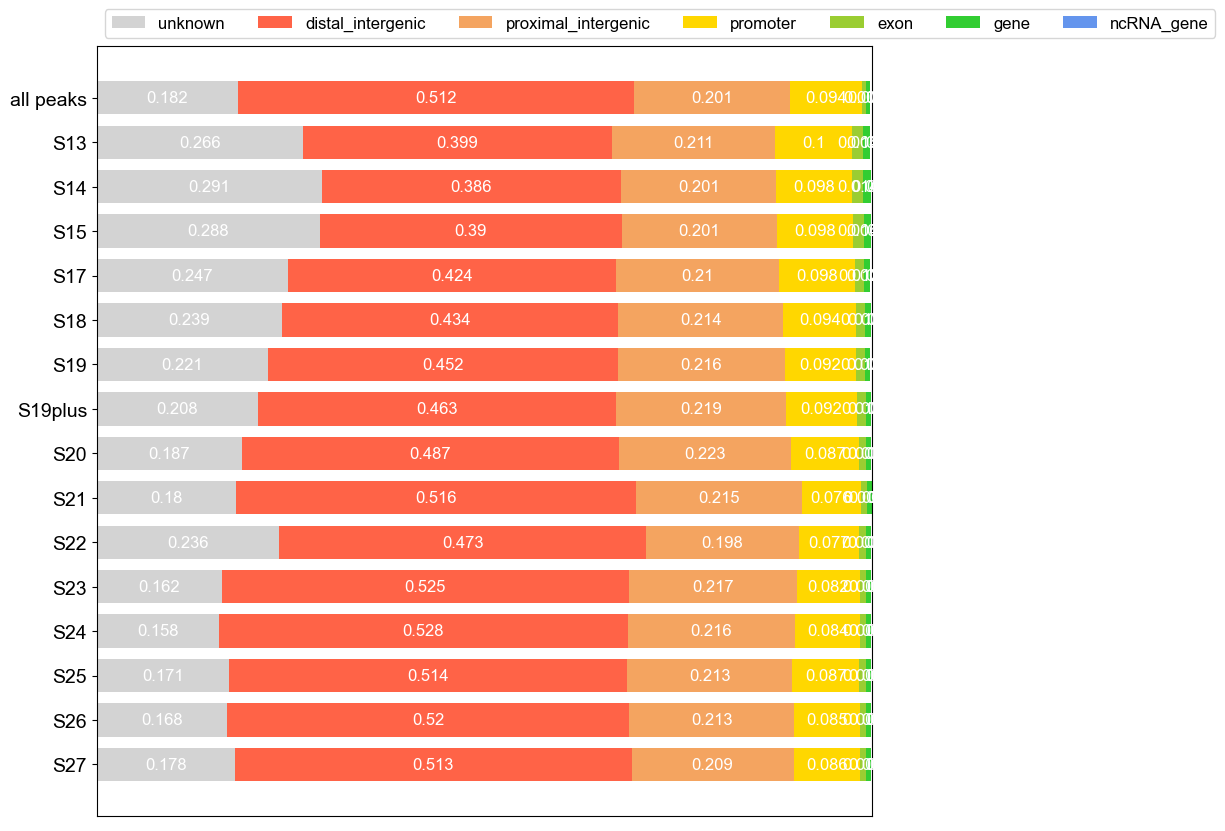

In [4]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = ['lightgray', 'tomato', 'sandybrown', 'gold', 'yellowgreen', 'limegreen', 'cornflowerblue', 'mediumslateblue']

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.75,
                        label=colname, color=color)

        text_color = 'white'
        ax.bar_label(rects, label_type='center', color=text_color, fontsize = 12)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize= 12)
    plt.yticks(fontsize = 14)

    return fig, ax

plt.rcParams.update(plt.rcParamsDefault)
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
plt.rcParams.update(new_rc_params)

sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

survey(results, category_names)
plt.savefig('OmniATAC_peaktype_absolute_bystage.svg')
plt.show()

survey(results_fraction, category_names)
plt.savefig('OmniATAC_peaktype_bystage.svg')
plt.show()

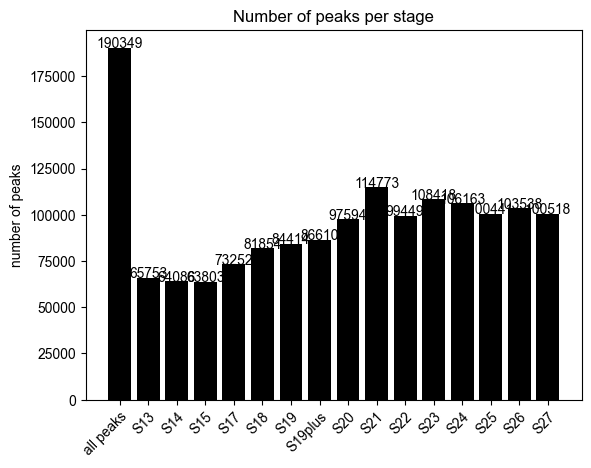

In [143]:
plt.bar(results_summed.keys(), results_summed.values(), color = 'k')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
addlabels(results_summed.keys(), list(results_summed.values()))

plt.title('Number of peaks per stage')
plt.ylabel('number of peaks')
plt.savefig('OmniATAC_numpeaks_perstage.svg')
plt.show()

In [154]:
peak_classes = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/Transcripts/" + "Sall_peaktypes.gff", sep = '\t', header = None))
promoters_only = peak_classes[peak_classes[1] == 'promoter']
promoters_only.to_csv("~/Labwork/Bioinformatics/Transcripts/" + "Sall_promoters.gff", sep = '\t', header = None, index = None)

#gff2bed < Sall_promoters.gff > Sall_promoters.bed
display(promoters_only)

,0,1,2,3,4,5,6,7,8
0,phaw_50.000023,promoter,phaw_50.000023_39987_40643,39987,40643,COUNT=2;SCORE_MEAN=351;SIGNAL_MEAN=225.3805085;-log10(p)_MAX=3.966765;-log10(p)_MIN=3.94913;-log...,+,.,2
1,phaw_50.000023,promoter,phaw_50.000023_121270_121683,121270,121683,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=432.315552;-log10(p)_MAX=5.709125;-log10(p)_MIN=5.709125;-lo...,+,.,1
2,phaw_50.000027,promoter,phaw_50.000027_69831_70633,69831,70633,COUNT=6;SCORE_MEAN=658.6666667;SIGNAL_MEAN=495.1125947;-log10(p)_MAX=5.650686;-log10(p)_MIN=4.16...,+,.,6
3,phaw_50.000027,promoter,phaw_50.000027_157829_158672,157829,158672,COUNT=4;SCORE_MEAN=853;SIGNAL_MEAN=678.4532545;-log10(p)_MAX=7.638493;-log10(p)_MIN=5.39596;-log...,+,.,4
4,phaw_50.000028,promoter,phaw_50.000028_21120_21638,21120,21638,COUNT=7;SCORE_MEAN=728.4285714;SIGNAL_MEAN=325.6438557;-log10(p)_MAX=5.258597;-log10(p)_MIN=3.99...,+,.,7
...,...,...,...,...,...,...,...,...,...
17858,phaw_50.283875a,promoter,phaw_50.283875a_26755723_26756084,26755723,26756084,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=1479.325195;-log10(p)_MAX=11.257517;-log10(p)_MIN=11.257517;...,+,.,1
17859,phaw_50.283875b,promoter,phaw_50.283875b_850040_850855,850040,850855,COUNT=15;SCORE_MEAN=943.2666667;SIGNAL_MEAN=538.304191;-log10(p)_MAX=6.149063;-log10(p)_MIN=4.66...,+,.,15
17860,phaw_50.283875b,promoter,phaw_50.283875b_1263954_1264350,1263954,1264350,COUNT=5;SCORE_MEAN=782.4;SIGNAL_MEAN=279.998813;-log10(p)_MAX=5.964021;-log10(p)_MIN=5.029833;-l...,+,.,5
17861,phaw_50.283875b,promoter,phaw_50.283875b_1409007_1409584,1409007,1409584,COUNT=7;SCORE_MEAN=931.1428571;SIGNAL_MEAN=706.7873973;-log10(p)_MAX=8.844542;-log10(p)_MIN=5.06...,+,.,7


{6: 39558,
 9: 23708,
 4: 21614,
 2: 18593,
 7: 18566,
 3: 17380,
 8: 17203,
 5: 16350,
 1: 8438}

{'Cluster 8': 8438,
 'Cluster 7': 18593,
 'Cluster 5': 17380,
 'Cluster 9': 21614,
 'Cluster 3': 16350,
 'Cluster 1': 39558,
 'Cluster 6': 18566,
 'Cluster 4': 17203,
 'Cluster 2': 23708}

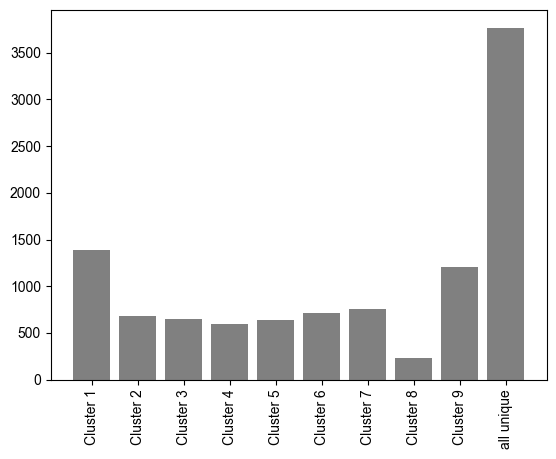

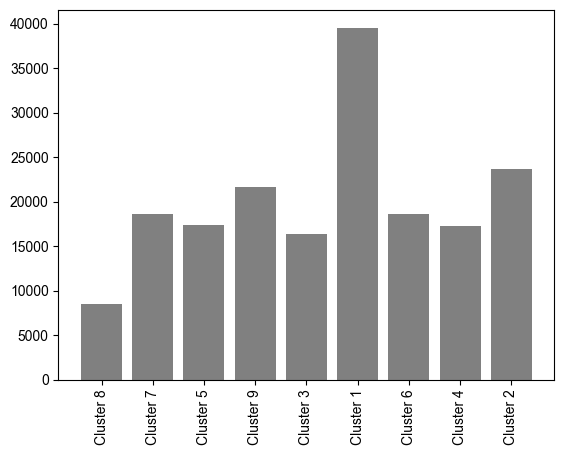

,9,gene.id,best_cluster,Predicted protein name,gene.names,Gene Ontology terms
0,None.None.None,phaw_50.000003_4302_5642,6,NaN,NaN,NaN
1,mikado.phaw_50.000014G4,phaw_50.000014_206406_207519,6,NaN,NaN,NaN
2,mikado.phaw_50.000019G1,phaw_50.000019_97413_97613,6,GXYLT1,mikado.phaw_50.000019G1,"GO:0003674,GO:0003824,GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO:0005783,GO:0005789,GO:00064..."
3,mikado.phaw_50.000023G2,phaw_50.000023_4_138,3,NaN,NaN,NaN
4,mikado.phaw_50.000023G3,phaw_50.000023_87808_88060,1,NaN,NaN,NaN
...,...,...,...,...,...,...
129331,mikado.phaw_50.283875bG12,phaw_50.283875b_1496273_1496592,2,NaN,NaN,NaN
129332,mikado.phaw_50.283875bG13,phaw_50.283875b_1535466_1535680,2,NaN,NaN,NaN
129333,mikado.phaw_50.283875bG13,phaw_50.283875b_1546841_1547714,3,NaN,NaN,NaN
129334,mikado.phaw_50.283876G1,phaw_50.283876_1905_3313,6,NaN,NaN,NaN


In [343]:
make_gene_lists = True
make_plots = True

columns = ['query_name', 
'seed eggNOG ortholog',
'seed ortholog evalue',
'seed ortholog score',
'Predicted taxonomic group',
'Predicted protein name',
'Gene Ontology terms',
'EC number',
'KEGG_ko',
'KEGG_Pathway',
'KEGG_Module',
'KEGG_Reaction',
'KEGG_rclass',
'BRITE',
'KEGG_TC',
'CAZy',
'BiGG Reaction',
'tax_scope: eggNOG taxonomic level used for annotation',
'eggNOG OGs',
'bestOG (deprecated, use smallest from eggnog OGs)',
'COG Functional Category',
'eggNOG free text description']

eggNOG_annotations_loc = 'phaw_5.0_mikado.emapper.annotations'
eggNOG_annotations = pd.DataFrame(pd.read_csv(eggNOG_annotations_loc, sep='\t', skiprows=4, names = columns))
eggNOG_annotations.drop(eggNOG_annotations.tail(3).index, inplace = True)
temp_df = eggNOG_annotations['query_name'].str.split('.', expand = True)

eggNOG_annotations['gene.names'] = temp_df.apply(lambda x: '.'.join(x[0:3].dropna().values.tolist()), axis=1)

unique_names = eggNOG_annotations['Predicted protein name'].unique()

if make_gene_lists:
    with open('eggNOG_mikado_uniquenames.txt', 'w+') as f:
        for item in unique_names:
            f.write("%s\n" % item)

hard_Mfuzz_dir = '/Users/dennis/Labwork/Bioinformatics/Omni-ATAC-Seq/Mfuzz_mikado/'
multicovloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/OmniATAC_bothruns_peaks/' + 'OmniATAC_bothruns_multicov_unformat_mikado.tsv'
name_generator_3 = hard_Mfuzz_dir + 'Mfuzz_a9_m1.1_clusters.tsv'

mfuzz_cmeans = pd.DataFrame(pd.read_csv(name_generator_3))
mfuzz_cmeans_val = mfuzz_cmeans.filter(regex=("cluster.*"))
mfuzz_cmeans['best_cluster'] = mfuzz_cmeans_val.idxmax(axis = 1).str.split('.', expand = True)[1].astype(int)
mfuzz_cmeans['topval'] = mfuzz_cmeans_val.max(axis = 1)

mfuzz_bestcluster = dict(mfuzz_cmeans['best_cluster'].value_counts())
display(mfuzz_bestcluster)

mfuzz_cmeans = mfuzz_cmeans[mfuzz_cmeans['topval'] > 0.9]

nearest_gene = pd.DataFrame(pd.read_csv('~/Labwork/Bioinformatics/Transcripts/' + 'Sall_peaktypes_nearestgene.gff', sep = '\t', header = None))
nearest_gene['newstart'] = nearest_gene[3] - 1
nearest_gene['gene.id'] = nearest_gene[0] + '_' + nearest_gene['newstart'].astype('str') + '_' + nearest_gene[4].astype('str')

mfuzz_cmeans = mfuzz_cmeans.merge(nearest_gene[['gene.id', 9]], left_on = 'gene.id', right_on = 'gene.id')

mfuzz_withannot = mfuzz_cmeans[[9, 'gene.id', 'best_cluster']].merge(eggNOG_annotations[['Predicted protein name', 'gene.names', 'Gene Ontology terms']], left_on = 9, right_on = 'gene.names', how = 'left')

cluster_lists = {}
cluster_dict = {5: 'Cluster 1',
                 8: 'Cluster 2',
                 4: 'Cluster 3',
                 7: 'Cluster 4',
                 2: 'Cluster 5',
                 6: 'Cluster 6',
                 1: 'Cluster 7',
                 0: 'Cluster 8',
                 3: 'Cluster 9'}

bestcluster_dict = {}
for i in np.arange(0, 9):
    bestcluster_dict[cluster_dict[i]] = mfuzz_bestcluster[i + 1]
display(bestcluster_dict)

for i in np.arange(0, 9):
    cluster_lists[cluster_dict[i]] = mfuzz_withannot[mfuzz_withannot['best_cluster'] == i + 1]['Predicted protein name'].astype(str).unique()
    
    if make_gene_lists:
        with open('eggNOG_mikado_uniquenames_' + cluster_dict[i] + '_stringent.txt', 'w+') as f:
            for item in cluster_lists[cluster_dict[i]]:
                f.write("%s\n" % item)

cluster_redict = {}
cluster_lens = {}
for i in np.arange(1, 10):
    cluster_string = 'Cluster ' + str(i)
    cluster_redict[cluster_string] = cluster_lists[cluster_string]
    cluster_lens[cluster_string] = len(cluster_redict[cluster_string])
cluster_lens['all unique'] = len(unique_names)
    
if make_plots:
    plt.bar(list(cluster_lens.keys()), list(cluster_lens.values()), color = 'grey')
    plt.xticks(rotation = 90)
    plt.show()
    
    plt.bar(list(bestcluster_dict.keys()), list(bestcluster_dict.values()), color = 'grey')
    plt.xticks(rotation = 90)
    plt.show()

display(mfuzz_withannot)

In [205]:
columns = ['Orthogroup', 'mikado_gene', 'Drosophila_ID']
assigned = pd.DataFrame(pd.read_csv('OrthoFinder_mikado/' + 'Orthogroups.tsv', sep='\t', names = columns, skiprows = 1))
assigned['UNIPROT_ID'] = assigned['Drosophila_ID'].str.split('|', expand = True)[1]

display(assigned)

OGs = []
genes = []
Dro_IDs = []
UNI_IDs = []

assigned_split = assigned[assigned['mikado_gene'].str.contains(',')]
assigned_unsplit = assigned[~assigned['mikado_gene'].str.contains(',')]
assigned_unsplit['mikado_newgene'] = assigned_unsplit['mikado_gene'].apply(lambda x: '.'.join(x.split('.')[0:3]))
assigned_unsplit['mikado_gene'] = assigned_unsplit['mikado_newgene']
assigned_unsplit.drop(columns = ['mikado_newgene'], inplace = True)
display(assigned_split)

for index, row in assigned_split.iterrows():
    OG = row['Orthogroup']
    mikado_genes = row['mikado_gene'].split(', ')
    ID = row['Drosophila_ID']
    UNI_ID = row['UNIPROT_ID']
    for gene in mikado_genes:
        gene_stripped = '.'.join(gene.split('.')[0:3])
        OGs = OGs + [OG]
        genes = genes + [gene_stripped]
        Dro_IDs = Dro_IDs + [ID]
        UNI_IDs = UNI_IDs + [UNI_ID]

new_rows = pd.DataFrame({'Orthogroup': OGs, 'mikado_gene': genes, 'Drosophila_ID': Dro_IDs, 'UNIPROT_ID': UNI_IDs})
all_list = new_rows.append(assigned_unsplit)
all_list.drop_duplicates(inplace = True)

display(all_list)

,Orthogroup,mikado_gene,Drosophila_ID,UNIPROT_ID
0,OG0000000,"mikado.phaw_50.282976aG39.1.p1, mikado.phaw_50.282976aG39.2.p1, mikado.phaw_50.282976aG39.3.p1, ...",tr|Q9V436|Q9V436_DROME,Q9V436
1,OG0000001,"mikado.phaw_50.283828bG67.2.p1, mikado.phaw_50.283828bG67.3.p1, mikado.phaw_50.283828bG67.4.p1, ...",tr|M9PFU5|M9PFU5_DROME,M9PFU5
2,OG0000002,"mikado.phaw_50.283865cG148.2.p1, mikado.phaw_50.283865cG148.3.p1, mikado.phaw_50.283865cG148.4.p...",tr|Q95RP8|Q95RP8_DROME,Q95RP8
3,OG0000003,"mikado.phaw_50.020523aG19.1.p1, mikado.phaw_50.020523aG19.2.p1, mikado.phaw_50.020523aG19.3.p1, ...",tr|Q0E980|Q0E980_DROME,Q0E980
4,OG0000004,"mikado.phaw_50.282654bG164.2.p1, mikado.phaw_50.282654bG164.3.p1, mikado.phaw_50.282654bG164.4.p...",sp|Q9V597|RL31_DROME,Q9V597
...,...,...,...,...
5977,OG0005977,mikado.phaw_50.283875aG83.2.p1,sp|Q9VAC5|ADA17_DROME,Q9VAC5
5978,OG0005978,mikado.phaw_50.283875aG85.1.p1,tr|Q9VES0|Q9VES0_DROME,Q9VES0
5979,OG0005979,mikado.phaw_50.283875aG91.1.p1,tr|Q9W125|Q9W125_DROME,Q9W125
5980,OG0005980,mikado.phaw_50.283875aG92.1.p1,sp|Q94526|ORK1_DROME,Q94526


<ipython-input-205-64190b3407fb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_unsplit['mikado_newgene'] = assigned_unsplit['mikado_gene'].apply(lambda x: '.'.join(x.split('.')[0:3]))
<ipython-input-205-64190b3407fb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_unsplit['mikado_gene'] = assigned_unsplit['mikado_newgene']
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

,Orthogroup,mikado_gene,Drosophila_ID,UNIPROT_ID
0,OG0000000,"mikado.phaw_50.282976aG39.1.p1, mikado.phaw_50.282976aG39.2.p1, mikado.phaw_50.282976aG39.3.p1, ...",tr|Q9V436|Q9V436_DROME,Q9V436
1,OG0000001,"mikado.phaw_50.283828bG67.2.p1, mikado.phaw_50.283828bG67.3.p1, mikado.phaw_50.283828bG67.4.p1, ...",tr|M9PFU5|M9PFU5_DROME,M9PFU5
2,OG0000002,"mikado.phaw_50.283865cG148.2.p1, mikado.phaw_50.283865cG148.3.p1, mikado.phaw_50.283865cG148.4.p...",tr|Q95RP8|Q95RP8_DROME,Q95RP8
3,OG0000003,"mikado.phaw_50.020523aG19.1.p1, mikado.phaw_50.020523aG19.2.p1, mikado.phaw_50.020523aG19.3.p1, ...",tr|Q0E980|Q0E980_DROME,Q0E980
4,OG0000004,"mikado.phaw_50.282654bG164.2.p1, mikado.phaw_50.282654bG164.3.p1, mikado.phaw_50.282654bG164.4.p...",sp|Q9V597|RL31_DROME,Q9V597
...,...,...,...,...
562,OG0000562,"mikado.phaw_50.283875aG25.1.p1, mikado.phaw_50.283875aG25.2.p1",tr|Q8SXF0|Q8SXF0_DROME,Q8SXF0
563,OG0000563,"mikado.phaw_50.283875aG367.1.p1, mikado.phaw_50.283875aG367.2.p1",sp|Q9VKB4|RPF1_DROME,Q9VKB4
564,OG0000564,"mikado.phaw_50.283875aG407.1.p1, mikado.phaw_50.283875aG407.3.p1",sp|Q960X4|TIP60_DROME,Q960X4
565,OG0000565,"mikado.phaw_50.283875aG409.1.p1, mikado.phaw_50.283875aG410.1.p1",sp|Q95028|LDH_DROME,Q95028


,Orthogroup,mikado_gene,Drosophila_ID,UNIPROT_ID
0,OG0000000,mikado.phaw_50.282976aG39,tr|Q9V436|Q9V436_DROME,Q9V436
7,OG0000001,mikado.phaw_50.283828bG67,tr|M9PFU5|M9PFU5_DROME,M9PFU5
12,OG0000002,mikado.phaw_50.283865cG148,tr|Q95RP8|Q95RP8_DROME,Q95RP8
17,OG0000003,mikado.phaw_50.020523aG19,tr|Q0E980|Q0E980_DROME,Q0E980
21,OG0000004,mikado.phaw_50.282654bG164,sp|Q9V597|RL31_DROME,Q9V597
...,...,...,...,...
5977,OG0005977,mikado.phaw_50.283875aG83,sp|Q9VAC5|ADA17_DROME,Q9VAC5
5978,OG0005978,mikado.phaw_50.283875aG85,tr|Q9VES0|Q9VES0_DROME,Q9VES0
5979,OG0005979,mikado.phaw_50.283875aG91,tr|Q9W125|Q9W125_DROME,Q9W125
5980,OG0005980,mikado.phaw_50.283875aG92,sp|Q94526|ORK1_DROME,Q94526


,9,gene.id,best_cluster,Predicted protein name,gene.names,Gene Ontology terms,Orthogroup,mikado_gene,Drosophila_ID,UNIPROT_ID
0,None.None.None,phaw_50.000003_4302_5642,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mikado.phaw_50.000014G4,phaw_50.000014_206406_207519,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mikado.phaw_50.000019G1,phaw_50.000019_97413_97613,6,GXYLT1,mikado.phaw_50.000019G1,"GO:0003674,GO:0003824,GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO:0005783,GO:0005789,GO:00064...",NaN,NaN,NaN,NaN
3,mikado.phaw_50.000023G2,phaw_50.000023_4_138,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mikado.phaw_50.000023G3,phaw_50.000023_87808_88060,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
129351,mikado.phaw_50.283875bG12,phaw_50.283875b_1496273_1496592,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129352,mikado.phaw_50.283875bG13,phaw_50.283875b_1535466_1535680,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129353,mikado.phaw_50.283875bG13,phaw_50.283875b_1546841_1547714,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129354,mikado.phaw_50.283876G1,phaw_50.283876_1905_3313,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


5982

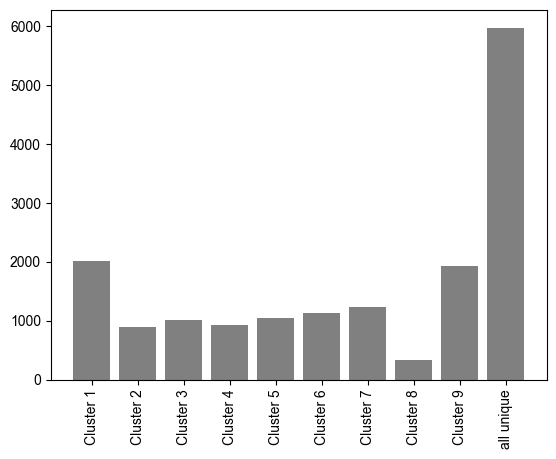

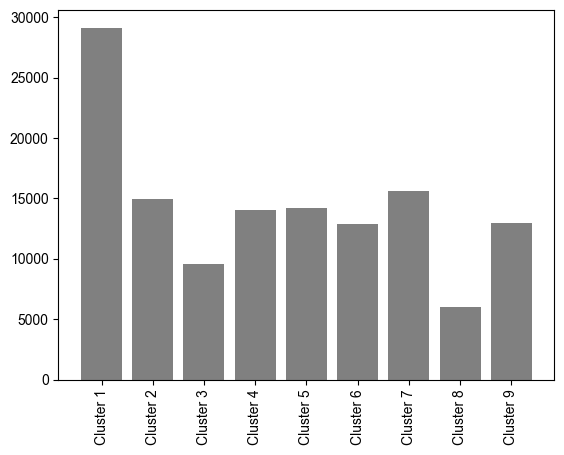

In [344]:
mfuzz_withOF = mfuzz_withannot.merge(all_list, left_on = 9, right_on = 'mikado_gene', how = 'left')

make_plots = True
make_gene_lists = True

display(mfuzz_withOF)

unique_names = all_list['UNIPROT_ID'].unique()
display(len(unique_names))

if make_gene_lists:
    with open('Dmel_mikado_uniquenames.txt', 'w+') as f:
        for item in unique_names:
            f.write("%s\n" % item)

cluster_lists = {}
cluster_dict = {5: 'Cluster 1',
                 8: 'Cluster 2',
                 4: 'Cluster 3',
                 7: 'Cluster 4',
                 2: 'Cluster 5',
                 6: 'Cluster 6',
                 1: 'Cluster 7',
                 0: 'Cluster 8',
                 3: 'Cluster 9'}
cluster_sizes = {}

for i in np.arange(0, 9):
    cluster_lists[cluster_dict[i]] = mfuzz_withOF[mfuzz_withOF['best_cluster'] == i + 1]['UNIPROT_ID'].astype(str).unique()
    cluster_sizes[cluster_dict[i]] = len(mfuzz_withOF[mfuzz_withOF['best_cluster'] == i + 1])
    
    if make_gene_lists:
        with open('Dmel_mikado_uniquenames_' + cluster_dict[i] + '_stringent.txt', 'w+') as f:
            for item in cluster_lists[cluster_dict[i]]:
                f.write("%s\n" % item)

cluster_redict = {}
cluster_lens = {}
for i in np.arange(1, 10):
    cluster_string = 'Cluster ' + str(i)
    cluster_redict[cluster_string] = cluster_lists[cluster_string]
    cluster_lens[cluster_string] = len(cluster_redict[cluster_string])
cluster_lens['all unique'] = len(unique_names)

cluster_resizes = {}
for i in np.arange(1, 10):
    cluster_string = 'Cluster ' + str(i)
    cluster_resizes[cluster_string] = cluster_sizes[cluster_string]

if make_plots:
    plt.bar(list(cluster_lens.keys()), list(cluster_lens.values()), color = 'grey')
    plt.xticks(rotation = 90)
    plt.show()
    
    plt.bar(list(cluster_resizes.keys()), list(cluster_resizes.values()), color = 'grey')
    plt.xticks(rotation = 90)
    plt.show()

In [191]:
display(len(eggNOG_annotations['Predicted protein name'].unique()))
display(len(eggNOG_annotations['Gene Ontology terms'].unique()))

3771

5908

<ipython-input-366-21843506469a>:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


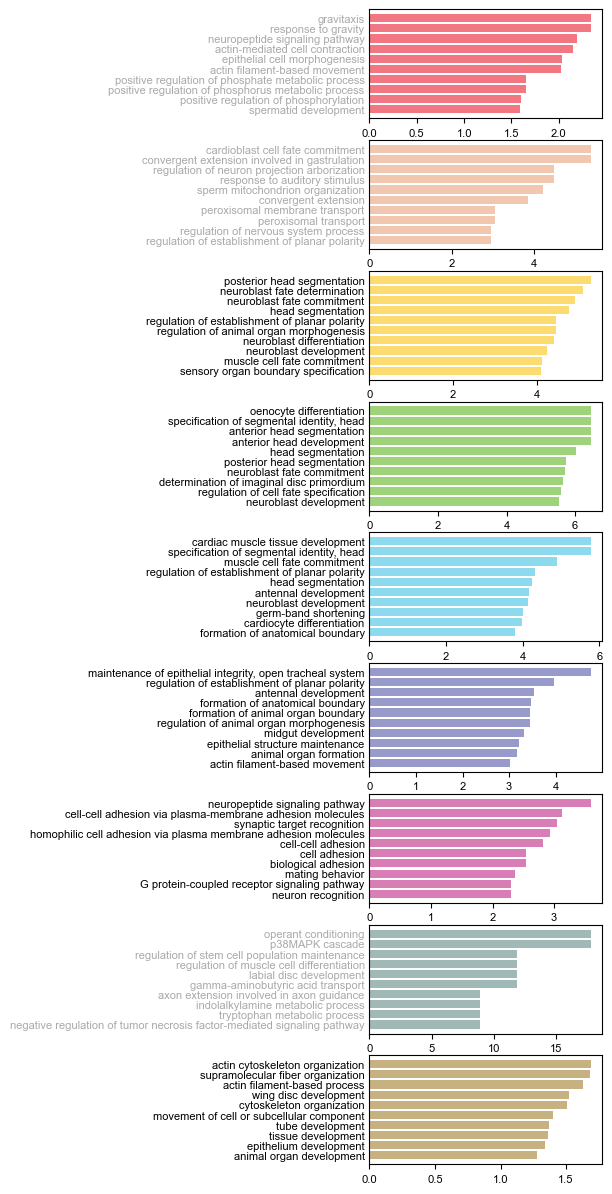

In [366]:
GOterm_pattern = 'GO_enrichment_mikado_cluster***.txt'
acores = 9

fields = ['GO biological process complete', 'reflist', 'input', 'expected', 'over/under', 'fold Enrichment', 'p-value', 'FDR']
color_order = ['#ef3d4f', '#ecb18e', '#fccd35', '#75c043', '#5dcae8', '#6d6fb4', '#ca4699', '#789a97', '#b1914c']

plt.figure(figsize = (3, 15))

n = 10

for i in np.arange(1, acores + 1):
    GOterm_filename = GOterm_pattern.replace('***', str(i))
    GOterms = pd.DataFrame(pd.read_csv(GOterm_filename, skiprows = 7,sep = '\t', names = fields))
    GOterms = GOterms[GOterms['fold Enrichment'] != ' < 0.01']
    GOterms['fold Enrichment'] = GOterms['fold Enrichment'].astype('float')
    GOterms.sort_values('fold Enrichment', ascending = False, inplace = True)
    topn = GOterms.head(n)
    
    trigger = False
    
    if sum(topn['FDR']) == n:
        trigger = True
        topn_temp = GOterms[GOterms['p-value'] < 0.05]
        topn = topn_temp.sort_values('fold Enrichment', ascending = False).head(n)
    
    hatchvalue = "//" if trigger else None
    
    plt.subplot(9, 1, i)
    names = [k.split(' (')[0] for k in topn['GO biological process complete']]
    plt.barh(names, topn['fold Enrichment'], color = color_order[i - 1], alpha = 0.7)
    if trigger:
        plt.tick_params(axis='y', colors='darkgrey')
    plt.tick_params(axis='y', which='both', length=0)
    plt.gca().invert_yaxis()
    plt.yticks(fontsize = 8)
    plt.xticks(fontsize = 8)
    
plt.tight_layout()
plt.savefig('Mfuzz_mikado_GOterm_enrichment.svg')
plt.show()

In [112]:
mikado_loc = 'mikado.loci.metrics.tsv'
mikado_df = pd.DataFrame(pd.read_csv(mikado_loc, sep = '\t'))
display(mikado_df)

,tid,alias,parent,original_source,score,best_bits,blast_identity,blast_query_coverage,blast_score,blast_target_coverage,...,start_distance_from_tss,suspicious_splicing,three_utr_length,three_utr_num,three_utr_num_complete,utr_fraction,utr_length,utr_num,utr_num_complete,verified_introns_num
0,mikado.phaw_50.000008G1.1,ref_maker-phaw_50.000008-augustus-gene-0.0-mRNA-1,mikado.phaw_50.000008G1,ref,22.0,0,0,0,0,0,...,0,False,38,1,0,0.09,38,1,0,0
1,mikado.phaw_50.000009G1.1,kao_mikado.phaw_50.000009G2.1.mrna1,mikado.phaw_50.000009G1,kao,19.0,0,0,0,0,0,...,138,False,34,1,0,0.35,172,2,0,0
2,mikado.phaw_50.000014G1.1,s19_TRINITY_DN55059_c0_g2_i1.mrna1,mikado.phaw_50.000014G1,s19,17.0,0,0,0,0,0,...,2,False,55,1,0,0.10,57,2,0,4
3,mikado.phaw_50.000014G2.1,st2m_STRG.2.1,mikado.phaw_50.000014G2,st2m,22.0,0,0,0,0,0,...,29,False,2,1,0,0.06,31,2,0,3
4,mikado.phaw_50.000014G3.1,kao_mikado.phaw_50.000014G10.1.mrna1,mikado.phaw_50.000014G3,kao,20.0,0,0,0,0,0,...,2,False,2,1,0,0.01,4,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53930,mikado.phaw_50.283875bG10.1,st2m_STRG.65339.1,mikado.phaw_50.283875bG10,st2m,23.0,0,0,0,0,0,...,102,False,875,1,0,0.73,977,3,1,2
53931,mikado.phaw_50.283875bG11.1,kao_mikado.phaw_50.283875bG70.1.mrna1,mikado.phaw_50.283875bG11,kao,20.0,0,0,0,0,0,...,298,False,12,1,0,0.10,310,2,0,2
53932,mikado.phaw_50.283875bG12.1,das_TRINITY_DN137516_c3_g1_i5.mrna4,mikado.phaw_50.283875bG12,das,15.0,0,0,0,0,0,...,84,False,194,2,1,0.77,278,3,1,0
53933,mikado.phaw_50.283875bG13.1,phre_comp129541_c0_seq1.mrna1,mikado.phaw_50.283875bG13,phre,17.0,0,0,0,0,0,...,246,False,2,1,0,0.51,248,2,0,0


In [113]:
contribution_values = dict(mikado_df['original_source'].value_counts())
total_genes = len(mikado_df)
contribution_fractions = {library : contribution_values[library] / total_genes * 100 for library in contribution_values}
display(contribution_fractions)

{'st2m': 24.99490127004728,
 'kao': 15.62250857513674,
 'das': 10.803745248910726,
 'dasgg': 10.638731806804486,
 'ref': 8.337814035412997,
 's23': 6.669138778158895,
 'st2': 5.7124316306665435,
 's21': 4.616668211736349,
 'hbdn': 4.429405766200055,
 's19': 3.498655789376101,
 's13': 3.2261054973579313,
 'phre': 1.3924167979975897,
 'race': 0.05747659219430796}

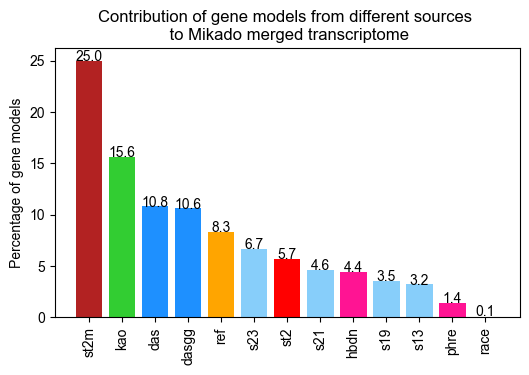

In [136]:
colors = ['firebrick', 'limegreen', 'dodgerblue', 'dodgerblue', 'orange', 'lightskyblue', 'red', 'lightskyblue', 'deeppink', 'lightskyblue', 'lightskyblue', 'deeppink', 'silver']

plt.figure(figsize = (6, 3.5))
plt.title('Contribution of gene models from different sources \n to Mikado merged transcriptome')
plt.bar(list(contribution_fractions.keys()), list(contribution_fractions.values()), color = colors)
addlabels(contribution_fractions.keys(), np.round(list(contribution_fractions.values()), 1))
plt.ylabel('Percentage of gene models')
plt.xticks(rotation = 90)

plt.savefig('Mikado_contributions.svg')
plt.show()

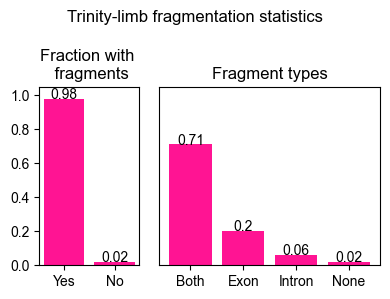

In [97]:
gff_trin_frag = 'PhRef5and3RACE_manualannot_Trinityfragmentation.tsv'
gff_df = pd.read_csv('~/Labwork/Bioinformatics/Transcripts/' + gff_trin_frag, sep = '\t')

fragmented_count = dict(gff_df['Trinity fragments?'].value_counts(normalize = True))
fragment_type = dict(gff_df['Fragment type'].value_counts(normalize = True))

fig = plt.figure(figsize = (4, 3))

G = mpl.gridspec.GridSpec(1, 3)

fig.add_subplot(G[0, 0])
plt.bar(fragmented_count.keys(), fragmented_count.values(), color = 'deeppink')
addlabels(fragmented_count.keys(), np.round(list(fragmented_count.values()), 2))
plt.ylim(0, 1.05)
plt.title('Fraction with \n fragments')

fig.add_subplot(G[0, 1:3])
plt.bar(fragment_type.keys(), fragment_type.values(), color = 'deeppink')
addlabels(fragment_type.keys(), np.round(list(fragment_type.values()), 2))
plt.ylim(0, 1.05)
plt.yticks([], [])
plt.title('Fragment types')

plt.suptitle('Trinity-limb fragmentation statistics')
plt.tight_layout()

plt.savefig('Trinity_fragmentation_plot.svg')

plt.show()

# Make annotation files for chromoMap

In [103]:
make_chr_file = False
make_test_chr_file = False
make_peaks_file = False
make_peaks_file_category = True

make_specific_chr_file = False
specific_chr = 'phaw_50.282695a'

#generate proper chromosomes file
if make_chr_file:
    chrom_sizes = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/GenomeSequences/Phaw_5.0_Annotation/genome/phaw_5.0.chrom.sizes", sep = "\t", header = None))
    display(chrom_sizes)
    chrom_sizes[2] = 1
    chr_file = chrom_sizes[[0, 2, 1]]
    chr_file.to_csv("~/Labwork/Bioinformatics/GenomeSequences/Phaw_5.0_Annotation/genome/phaw_5.0.cMap_chrfile.txt", sep = "\t", header = None, index = None)
    display(chr_file)

if make_test_chr_file:
    chrom_sizes = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/GenomeSequences/Phaw_5.0_Annotation/genome/phaw_5.0.chrom.sizes", sep = "\t", header = None))
    chrom_sizes.sort_values(1, ascending = False, inplace = True)
    display(chrom_sizes)
    chrom_sizes[2] = 1
    chr_file = chrom_sizes[[0, 2, 1]]
    chr_file = chr_file.iloc[0:1]
    chr_file.to_csv("~/Labwork/Bioinformatics/GenomeSequences/Phaw_5.0_Annotation/genome/phaw_5.0.cMap_chrfile_test.txt", sep = "\t", header = None, index = None)
    display(chr_file)

if make_specific_chr_file:
    chrom_sizes = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/GenomeSequences/Phaw_5.0_Annotation/genome/phaw_5.0.chrom.sizes", sep = "\t", header = None))
    chrom_sizes.sort_values(1, ascending = False, inplace = True)
    display(chrom_sizes)
    chrom_sizes[2] = 1
    chr_file = chrom_sizes[[0, 2, 1]]
    chr_file = chr_file[chr_file[0] == specific_chr]
    chr_file.to_csv("~/Labwork/Bioinformatics/GenomeSequences/Phaw_5.0_Annotation/genome/phaw_5.0.cMap_chrfile_" + specific_chr + ".txt", sep = "\t", header = None, index = None)
    display(chr_file)
    
if make_peaks_file:
    #load peaks w/ annotation type
    peak_types = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/Transcripts/" + "Sall_peaktypes.gff", sep = '\t', header = None))
    display(peak_types)
    
    #Expected fields are:
    #0: element name
    #1: chromosome name
    #2: element start
    #3: element end
    #4: data (optional) -> peak "strength"
    #5: secondary data (optional) -> peak "category"
    
    peaks_cMap = peak_types[[2, 0, 3, 4, 8, 1]]
    peaks_cMap.to_csv('~/Labwork/Bioinformatics/Transcripts/' + 'chromoMap_OmniATAC_peaks.txt', sep = '\t', index = None, header = None)
    display(peaks_cMap)

if make_peaks_file_category:
    #load peaks w/ annotation type
    peak_types = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/Transcripts/" + "Sall_peaktypes.gff", sep = '\t', header = None))
    display(peak_types)
    
    #Expected fields are:
    #0: element name
    #1: chromosome name
    #2: element start
    #3: element end
    #4: data (optional) -> peak "category"
    
    peaks_cMap = peak_types[[2, 0, 3, 4, 1]]
    peaks_cMap.to_csv('~/Labwork/Bioinformatics/Transcripts/' + 'chromoMap_OmniATAC_peaks_category.txt', sep = '\t', index = None, header = None)
    
    display(peaks_cMap[1].value_counts())
    display(peaks_cMap)

,0,1,2,3,4,5,6,7,8
0,phaw_50.000023,promoter,phaw_50.000023_39987_40643,39987,40643,COUNT=2;SCORE_MEAN=351;SIGNAL_MEAN=225.3805085;-log10(p)_MAX=3.966765;-log10(p)_MIN=3.94913;-log...,+,.,2
1,phaw_50.000023,promoter,phaw_50.000023_121270_121683,121270,121683,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=432.315552;-log10(p)_MAX=5.709125;-log10(p)_MIN=5.709125;-lo...,+,.,1
2,phaw_50.000027,promoter,phaw_50.000027_69831_70633,69831,70633,COUNT=6;SCORE_MEAN=658.6666667;SIGNAL_MEAN=495.1125947;-log10(p)_MAX=5.650686;-log10(p)_MIN=4.16...,+,.,6
3,phaw_50.000027,promoter,phaw_50.000027_157829_158672,157829,158672,COUNT=4;SCORE_MEAN=853;SIGNAL_MEAN=678.4532545;-log10(p)_MAX=7.638493;-log10(p)_MIN=5.39596;-log...,+,.,4
4,phaw_50.000028,promoter,phaw_50.000028_21120_21638,21120,21638,COUNT=7;SCORE_MEAN=728.4285714;SIGNAL_MEAN=325.6438557;-log10(p)_MAX=5.258597;-log10(p)_MIN=3.99...,+,.,7
...,...,...,...,...,...,...,...,...,...
190073,phaw_50.283856,unknown,phaw_50.283856_46103_47590,46103,47590,COUNT=17;SCORE_MEAN=922.3529412;SIGNAL_MEAN=1498.451131;-log10(p)_MAX=10.31401;-log10(p)_MIN=4.3...,+,.,17
190074,phaw_50.283856,unknown,phaw_50.283856_54876_55716,54876,55716,COUNT=14;SCORE_MEAN=965.3571429;SIGNAL_MEAN=729.0515604;-log10(p)_MAX=7.341001;-log10(p)_MIN=4.6...,+,.,14
190075,phaw_50.283858,unknown,phaw_50.283858_1105_1719,1105,1719,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=2300.867057;-log10(p)_MAX=11.550564;-log10(p)_MIN=8.902076;...,+,.,15
190076,phaw_50.283858,unknown,phaw_50.283858_6445_6923,6445,6923,COUNT=5;SCORE_MEAN=846.8;SIGNAL_MEAN=325.5418152;-log10(p)_MAX=6.457194;-log10(p)_MIN=4.907079;-...,+,.,5


distal_intergenic      97335
proximal_intergenic    38243
unknown                34571
promoter               17863
exon                    1032
gene                    1021
ncRNA_gene                13
Name: 1, dtype: int64

,2,0,3,4,1
0,phaw_50.000023_39987_40643,phaw_50.000023,39987,40643,promoter
1,phaw_50.000023_121270_121683,phaw_50.000023,121270,121683,promoter
2,phaw_50.000027_69831_70633,phaw_50.000027,69831,70633,promoter
3,phaw_50.000027_157829_158672,phaw_50.000027,157829,158672,promoter
4,phaw_50.000028_21120_21638,phaw_50.000028,21120,21638,promoter
...,...,...,...,...,...
190073,phaw_50.283856_46103_47590,phaw_50.283856,46103,47590,unknown
190074,phaw_50.283856_54876_55716,phaw_50.283856,54876,55716,unknown
190075,phaw_50.283858_1105_1719,phaw_50.283858,1105,1719,unknown
190076,phaw_50.283858_6445_6923,phaw_50.283858,6445,6923,unknown


# 

In [107]:
original_format = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/Transcripts/mikado.loci.sorted.gff", sep = '\t', header = None, skiprows = 1))
new_format = original_format[[0, 2, 1, 3, 4, 5, 6, 7, 8]]
new_format.to_csv("~/Labwork/Bioinformatics/Transcripts/mikado.loci.sorted.reordered.forvis.gff", sep = '\t', header = None, index = None)

# New peak identity guessing method

In [132]:
guess_promoter = True
guess_others = True
compile_guesses = True
compile_distances = True
compile_nearest_gene = True

all_dict = {}
startinglist_size = {}
finallist_size = {}
ratios = {}
hist_strength = {}

if guess_promoter:
    modelname = 'mikado.loci.genesonly.gff'
    dataloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/'
    genesonly = pd.read_csv(dataloc + modelname, header = None, sep = '\t')
    
    genesonly['size'] = genesonly.apply(lambda row: int(row[4]) - int(row[3]), axis = 1)
    genesonly = genesonly[genesonly['size'] > 500]
    startinglist_size[modelname] = len(genesonly)
    genesonly['newstart'] = genesonly.apply(lambda row: int(row[3]) if row[6] == '+' else int(row[4]) - 200, axis = 1)
    genesonly['newend'] = genesonly.apply(lambda row: int(row[4]) if row[6] == '-' else int(row[3]) + 200, axis = 1)

    geneendsname = modelname.replace('genesonly', 'geneends')
    geneendsloc = dataloc + geneendsname
    geneends = genesonly[[0, 1, 2, 'newstart', 'newend', 5, 6, 7, 8]]
    geneends.to_csv(geneendsloc, header = None, sep = '\t', index = None)
    geneendssorted = geneendsloc.replace('geneends', 'geneends.sorted')
    !/usr/local/bin/bedtools sort -i $geneendsloc > $geneendssorted

    #Specify the location of the final manual annotation file
    peaks_file = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/OmniATAC_bothruns_q005_allpeaks.igv_new.gff'
    original = pd.read_csv(peaks_file, sep = '\t', header = None)
    original['contig_start_end'] = original[0].astype(str) + '_' + original[3].astype(str) + '_' + original[4].astype(str)
    all_dict['original'] = original
    outputloc = dataloc + modelname.replace('.genesonly.gff', '.geneends.closest.gff')
    !/usr/local/bin/bedtools closest -D a -a $geneendssorted -b $peaks_file > $outputloc
    
    promoter_guesses = pd.read_csv(outputloc, header = None, sep = '\t')
    promoter_guesses = promoter_guesses[abs(promoter_guesses[18]) < 5000]
    promoter_guesses = promoter_guesses[promoter_guesses[18] != -1]
    promoter_guesses['IGV_address'] = promoter_guesses[9].astype(str) + ":" + promoter_guesses[12].astype(str) + "-" + promoter_guesses[13].astype(str)
    promoter_guesses['contig_start_end'] = promoter_guesses[9].astype(str) + "_" + promoter_guesses[12].astype(str) + "_" + promoter_guesses[13].astype(str)
    all_dict['promoters'] = promoter_guesses

if guess_others:
    modelname = 'mikado.loci.sorted.gff'
    dataloc = '~/Labwork/Bioinformatics/Transcripts/'
    allgffloc = dataloc + modelname
    allgffs = pd.read_csv(dataloc + modelname, header = None, sep = '\t', skiprows = 1)
    exons = allgffs[allgffs[2].isin(['exon', 'three_prime_UTR', 'five_prime_UTR'])]
    exonsloc = dataloc + modelname.replace('.sorted', '.exons_utrs.')
    exons.to_csv(exonsloc, index = None, header = None, sep = '\t')
    rnas = allgffs[allgffs[2].isin(['gene', 'ncRNA_gene'])]    
    rnasloc = dataloc + modelname.replace('.sorted', '.rnas_new.')
    rnas.to_csv(rnasloc, index = None, header = None, sep = '\t')
    
    #Specify the location of the final manual annotation file
    peaks_file = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/gene_model_analyses/OmniATAC_bothruns_q005_allpeaks.igv_new.gff'
    exons_outputloc = exonsloc.replace('.gff', '.closestpeaks_new.gff')
    rnas_outputloc = rnasloc.replace('.gff', '.closestpeaks_new.gff')
    rnas_outputloc2 = rnasloc.replace('.gff', '.closestpeaks_new2.gff')
    !/usr/local/bin/bedtools intersect -wao -a $peaks_file -b $exonsloc > $exons_outputloc
    !/usr/local/bin/bedtools intersect -wao -a $peaks_file -b $rnasloc > $rnas_outputloc
    !/usr/local/bin/bedtools closest -D a -t first -fu -a $peaks_file -b $rnasloc > $rnas_outputloc2
    
    exons_guesses = pd.read_csv(exons_outputloc, header = None, sep = '\t')
    exons_guesses['contig_start_end'] = exons_guesses[0].astype(str) + '_' + exons_guesses[3].astype(str) + '_' + exons_guesses[4].astype(str)
    exons_true = exons_guesses[exons_guesses[18] != 0]
    all_dict['exons'] = exons_true
    rnas_guesses = pd.read_csv(rnas_outputloc, header = None, sep = '\t')
    rnas_guesses['contig_start_end'] = rnas_guesses[0].astype(str) + '_' + rnas_guesses[3].astype(str) + '_' + rnas_guesses[4].astype(str)
    rnas_true = rnas_guesses[rnas_guesses[18] != 0]
    all_dict['rnas'] = rnas_true
    nearest_rnas= pd.read_csv(rnas_outputloc2, header = None, sep = '\t')
    nearest_rnas['contig_start_end'] = nearest_rnas[0].astype(str) + '_' + nearest_rnas[3].astype(str) + '_' + nearest_rnas[4].astype(str)
    display(nearest_rnas)
    all_dict['intergenics'] = nearest_rnas
    
if compile_nearest_gene:
    all_dict['promoters']['nearest_gene'] = all_dict['promoters'][8].str.split(';', expand = True)[0].str.replace('ID=', '')
    
    all_dict['exons'][['a', 'b', 'c', 'd']] = all_dict['exons'][17].str.split(';', expand = True)[1].str.replace('Parent=', '').str.split('.', expand = True)
    all_dict['exons']['nearest_gene'] = all_dict['exons'][['a', 'b', 'c']].agg('.'.join, axis = 1)
    
    all_dict['rnas']['nearest_gene'] = all_dict['rnas'][17].str.split(';', expand = True)[1].str.replace('Name=', '')
    all_dict['intergenics']['nearest_gene'] = all_dict['intergenics'][17].str.split(';', expand = True)[1].str.replace('Name=', '')
    
if compile_guesses:
    #Set the original df
    original = all_dict['original']
    all_dict['promoters']['type'] = 'promoter'
    
    #Grab all peaks that were called as promoters using the promoter guessing approach
    promoters = original.merge(all_dict['promoters'][['contig_start_end', 'type', 'nearest_gene']])
    #Remove the promoters from the possible peaks to merge with
    original_nopro = original[~original['contig_start_end'].isin(promoters['contig_start_end'])]
    
    #Set the exons with their type
    all_dict['exons']['type'] = all_dict['exons'][11]
    #Merge the non-promoter peaks to get the exonic peaks
    exons = original_nopro.merge(all_dict['exons'][['contig_start_end', 'type', 'nearest_gene']])
    #Remove the exonic peaks from the dataset
    original_noexon = original_nopro[~original_nopro['contig_start_end'].isin(exons['contig_start_end'])]
    
    #Set the non-exon RNAs
    all_dict['rnas']['type'] = all_dict['rnas'][11]
    display(all_dict['rnas'])
    #Assign all non-exon RNA overlapping peaks as introns
    introns = original_noexon.merge(all_dict['rnas'][['contig_start_end', 'type', 'nearest_gene']])
    original_intergenic = original_noexon[~original_noexon['contig_start_end'].isin(introns['contig_start_end'])]
    intergenic = original_intergenic.merge(all_dict['intergenics'][['contig_start_end', 13, 18, 'nearest_gene']])
    identified = intergenic[intergenic[13] != -1]
    proximal_intergenic = identified[abs(identified[18]) <= 10000]
    proximal_intergenic['type'] = 'proximal_intergenic'
    distal_intergenic = identified[~identified['contig_start_end'].isin(proximal_intergenic['contig_start_end'])]
    distal_intergenic['type'] = 'distal_intergenic'
    remain = intergenic[intergenic[13] == -1]
    remain['type'] = 'unknown'
    
    compiled = promoters.append(exons).append(introns).append(proximal_intergenic).append(distal_intergenic).append(remain)
    
    if compile_nearest_gene:
        compiled_nearestgene = compiled[[0, 'type', 'contig_start_end', 3, 4, 5, 6, 7, 2, 'nearest_gene']].drop_duplicates(['contig_start_end'])
        compiled_nearestgeneloc = dataloc + 'Sall_peaktypes_nearestgene_new.gff'
        compiled_nearestgene.to_csv(compiled_nearestgeneloc, sep = '\t', header = None, index = None)
        
    if compile_distances:
        compiled_distances = compiled[[0, 'type', 'contig_start_end', 3, 4, 5, 6, 7, 2, 'nearest_gene', 18]].drop_duplicates(['contig_start_end'])
        compiled_distancesloc = dataloc + 'Sall_peaktypes_distances_new.gff'
        compiled_distances.to_csv(compiled_distancesloc, sep = '\t', header = None, index = None)
    
    compiled.reset_index(inplace = True)
    
    compiled_outloc = dataloc + 'Sall_peaktypes_new.gff'
    compiled_out = compiled[[0, 'type', 'contig_start_end', 3, 4, 5, 6, 7, 2]].drop_duplicates()
    compiled_out.to_csv(compiled_outloc, sep = '\t', header = None, index = None)
    
    all_dict['compiled'] = compiled_out
    display(compiled_out)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,contig_start_end
0,phaw_50.000003,bed2gff,15,4303,5642,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=2054.581486;-log10(p)_MAX=11.055425;-log10(p)_MIN=8.578344;...,+,.,15;,.,.,.,-1,-1,.,.,.,.,-1,phaw_50.000003_4303_5642
1,phaw_50.000009,bed2gff,1,11629,11888,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=269.657501;-log10(p)_MAX=5.01003;-log10(p)_MIN=5.01003;-log1...,+,.,1;,phaw_50.000009,Mikado_loci,gene,10027,10513,19,+,.,ID=mikado.phaw_50.000009G1;Name=mikado.phaw_50.000009G1;multiexonic=False;superlocus=Mikado_supe...,-1116,phaw_50.000009_11629_11888
2,phaw_50.000014,bed2gff,15,206407,207519,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=1376.176314;-log10(p)_MAX=10.238941;-log10(p)_MIN=7.131846;...,+,.,15;,phaw_50.000014,Mikado_loci,gene,136822,138919,20,-,.,ID=mikado.phaw_50.000014G3;Name=mikado.phaw_50.000014G3;multiexonic=True;superlocus=Mikado_super...,-67488,phaw_50.000014_206407_207519
3,phaw_50.000014,bed2gff,3,238985,239410,COUNT=3;SCORE_MEAN=1000;SIGNAL_MEAN=403.0396423;-log10(p)_MAX=6.473408;-log10(p)_MIN=5.29058;-lo...,+,.,3;,phaw_50.000014,Mikado_loci,gene,182680,213402,20,-,.,ID=mikado.phaw_50.000014G4;Name=mikado.phaw_50.000014G4;multiexonic=True;superlocus=Mikado_super...,-25583,phaw_50.000014_238985_239410
4,phaw_50.000014,bed2gff,12,239712,240244,COUNT=12;SCORE_MEAN=944.5;SIGNAL_MEAN=766.4063032;-log10(p)_MAX=7.610405;-log10(p)_MIN=4.299145;...,+,.,12;,phaw_50.000014,Mikado_loci,gene,182680,213402,20,-,.,ID=mikado.phaw_50.000014G4;Name=mikado.phaw_50.000014G4;multiexonic=True;superlocus=Mikado_super...,-26310,phaw_50.000014_239712_240244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190073,phaw_50.283875b,bed2gff,2,1535467,1535680,COUNT=2;SCORE_MEAN=1000;SIGNAL_MEAN=223.467064;-log10(p)_MAX=5.899739;-log10(p)_MIN=5.556468;-lo...,+,.,2;,phaw_50.283875b,Mikado_loci,gene,1518895,1519376,17,-,.,ID=mikado.phaw_50.283875bG13;Name=mikado.phaw_50.283875bG13;multiexonic=False;superlocus=Mikado_...,-16091,phaw_50.283875b_1535467_1535680
190074,phaw_50.283875b,bed2gff,13,1546842,1547714,COUNT=13;SCORE_MEAN=926.4615385;SIGNAL_MEAN=1193.281705;-log10(p)_MAX=11.16451;-log10(p)_MIN=4.8...,+,.,13;,phaw_50.283875b,Mikado_loci,gene,1518895,1519376,17,-,.,ID=mikado.phaw_50.283875bG13;Name=mikado.phaw_50.283875bG13;multiexonic=False;superlocus=Mikado_...,-27466,phaw_50.283875b_1546842_1547714
190075,phaw_50.283875b,bed2gff,1,1548469,1548807,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=384.672821;-log10(p)_MAX=5.47358;-log10(p)_MIN=5.47358;-log1...,+,.,1;,phaw_50.283875b,Mikado_loci,gene,1518895,1519376,17,-,.,ID=mikado.phaw_50.283875bG13;Name=mikado.phaw_50.283875bG13;multiexonic=False;superlocus=Mikado_...,-29093,phaw_50.283875b_1548469_1548807
190076,phaw_50.283876,bed2gff,15,1906,3313,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=3321.552816;-log10(p)_MAX=11.202005;-log10(p)_MIN=8.831523;...,+,.,15;,phaw_50.283876,Mikado_loci,gene,1230,2833,20,-,.,ID=mikado.phaw_50.283876G1;Name=mikado.phaw_50.283876G1;multiexonic=False;superlocus=Mikado_supe...,0,phaw_50.283876_1906_3313


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-132-3334cd27ef38>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dict['exons']['nearest_gene'] = all_dict['exons'][['a', 'b', 'c']].agg('.'.join, axis = 1)
<ipython-input-132-3334cd27ef38>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,contig_start_end,nearest_gene,type
2,phaw_50.000014,bed2gff,15,206407,207519,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=1376.176314;-log10(p)_MAX=10.238941;-log10(p)_MIN=7.131846;...,+,.,15;,phaw_50.000014,...,182680,213402,20,-,.,ID=mikado.phaw_50.000014G4;Name=mikado.phaw_50.000014G4;multiexonic=True;superlocus=Mikado_super...,1113,phaw_50.000014_206407_207519,mikado.phaw_50.000014G4,gene
9,phaw_50.000023,bed2gff,2,39987,40643,COUNT=2;SCORE_MEAN=351;SIGNAL_MEAN=225.3805085;-log10(p)_MAX=3.966765;-log10(p)_MIN=3.94913;-log...,+,.,2;,phaw_50.000023,...,39009,40795,21,+,.,ID=mikado.phaw_50.000023G1;Name=mikado.phaw_50.000023G1;multiexonic=False;superlocus=Mikado_supe...,657,phaw_50.000023_39987_40643,mikado.phaw_50.000023G1,gene
14,phaw_50.000023,bed2gff,8,114177,114682,COUNT=8;SCORE_MEAN=822.5;SIGNAL_MEAN=434.4128666;-log10(p)_MAX=5.422709;-log10(p)_MIN=4.105318;-...,+,.,8;,phaw_50.000023,...,110641,118184,21,-,.,ID=mikado.phaw_50.000023G4;Name=mikado.phaw_50.000023G4;multiexonic=True;superlocus=Mikado_super...,506,phaw_50.000023_114177_114682,mikado.phaw_50.000023G4,gene
15,phaw_50.000023,bed2gff,1,121270,121683,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=432.315552;-log10(p)_MAX=5.709125;-log10(p)_MIN=5.709125;-lo...,+,.,1;,phaw_50.000023,...,119632,140731,22,-,.,ID=mikado.phaw_50.000023G5;Name=mikado.phaw_50.000023G5;multiexonic=True;superlocus=Mikado_super...,414,phaw_50.000023_121270_121683,mikado.phaw_50.000023G5,gene
18,phaw_50.000025,bed2gff,1,70163,70316,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=229.583206;-log10(p)_MAX=5.102831;-log10(p)_MIN=5.102831;-lo...,+,.,1;,phaw_50.000025,...,62828,121526,20,+,.,ID=mikado.phaw_50.000025G1;Name=mikado.phaw_50.000025G1;multiexonic=True;superlocus=Mikado_super...,154,phaw_50.000025_70163_70316,mikado.phaw_50.000025G1,gene
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199237,phaw_50.283875b,bed2gff,1,743222,743721,COUNT=1;SCORE_MEAN=804;SIGNAL_MEAN=401.982697;-log10(p)_MAX=5.353724;-log10(p)_MIN=5.353724;-log...,+,.,1;,phaw_50.283875b,...,678705,750621,18,+,.,ID=mikado.phaw_50.283875bG4;Name=mikado.phaw_50.283875bG4;multiexonic=True;superlocus=Mikado_sup...,500,phaw_50.283875b_743222_743721,mikado.phaw_50.283875bG4,gene
199239,phaw_50.283875b,bed2gff,15,850040,850855,COUNT=15;SCORE_MEAN=943.2666667;SIGNAL_MEAN=538.304191;-log10(p)_MAX=6.149063;-log10(p)_MIN=4.66...,+,.,15;,phaw_50.283875b,...,845033,855748,20,-,.,ID=mikado.phaw_50.283875bG7;Name=mikado.phaw_50.283875bG7;multiexonic=True;superlocus=Mikado_sup...,816,phaw_50.283875b_850040_850855,mikado.phaw_50.283875bG7,gene
199244,phaw_50.283875b,bed2gff,1,1249054,1249395,COUNT=1;SCORE_MEAN=871;SIGNAL_MEAN=297.901215;-log10(p)_MAX=4.989775;-log10(p)_MIN=4.989775;-log...,+,.,1;,phaw_50.283875b,...,1241047,1261378,22,-,.,ID=mikado.phaw_50.283875bG9;Name=mikado.phaw_50.283875bG9;multiexonic=True;superlocus=Mikado_sup...,342,phaw_50.283875b_1249054_1249395,mikado.phaw_50.283875bG9,gene
199253,phaw_50.283875b,bed2gff,7,1409007,1409584,COUNT=7;SCORE_MEAN=931.1428571;SIGNAL_MEAN=706.7873973;-log10(p)_MAX=8.844542;-log10(p)_MIN=5.06...,+,.,7;,phaw_50.283875b,...,1404886,1409630,20,+,.,ID=mikado.phaw_50.283875bG11;Name=mikado.phaw_50.283875bG11;multiexonic=True;superlocus=Mikado_s...,578,phaw_50.283875b_1409007_1409584,mikado.phaw_50.283875bG11,gene


<ipython-input-132-3334cd27ef38>:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proximal_intergenic['type'] = 'proximal_intergenic'
<ipython-input-132-3334cd27ef38>:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distal_intergenic['type'] = 'distal_intergenic'
<ipython-input-132-3334cd27ef38>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

,0,type,contig_start_end,3,4,5,6,7,2
0,phaw_50.000023,promoter,phaw_50.000023_39987_40643,39987,40643,COUNT=2;SCORE_MEAN=351;SIGNAL_MEAN=225.3805085;-log10(p)_MAX=3.966765;-log10(p)_MIN=3.94913;-log...,+,.,2
1,phaw_50.000023,promoter,phaw_50.000023_121270_121683,121270,121683,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=432.315552;-log10(p)_MAX=5.709125;-log10(p)_MIN=5.709125;-lo...,+,.,1
2,phaw_50.000027,promoter,phaw_50.000027_69831_70633,69831,70633,COUNT=6;SCORE_MEAN=658.6666667;SIGNAL_MEAN=495.1125947;-log10(p)_MAX=5.650686;-log10(p)_MIN=4.16...,+,.,6
3,phaw_50.000027,promoter,phaw_50.000027_157829_158672,157829,158672,COUNT=4;SCORE_MEAN=853;SIGNAL_MEAN=678.4532545;-log10(p)_MAX=7.638493;-log10(p)_MIN=5.39596;-log...,+,.,4
5,phaw_50.000028,promoter,phaw_50.000028_21120_21638,21120,21638,COUNT=7;SCORE_MEAN=728.4285714;SIGNAL_MEAN=325.6438557;-log10(p)_MAX=5.258597;-log10(p)_MIN=3.99...,+,.,7
...,...,...,...,...,...,...,...,...,...
206527,phaw_50.283856,unknown,phaw_50.283856_46103_47590,46103,47590,COUNT=17;SCORE_MEAN=922.3529412;SIGNAL_MEAN=1498.451131;-log10(p)_MAX=10.31401;-log10(p)_MIN=4.3...,+,.,17
206528,phaw_50.283856,unknown,phaw_50.283856_54876_55716,54876,55716,COUNT=14;SCORE_MEAN=965.3571429;SIGNAL_MEAN=729.0515604;-log10(p)_MAX=7.341001;-log10(p)_MIN=4.6...,+,.,14
206529,phaw_50.283858,unknown,phaw_50.283858_1105_1719,1105,1719,COUNT=15;SCORE_MEAN=1000;SIGNAL_MEAN=2300.867057;-log10(p)_MAX=11.550564;-log10(p)_MIN=8.902076;...,+,.,15
206530,phaw_50.283858,unknown,phaw_50.283858_6445_6923,6445,6923,COUNT=5;SCORE_MEAN=846.8;SIGNAL_MEAN=325.5418152;-log10(p)_MAX=6.457194;-log10(p)_MIN=4.907079;-...,+,.,5


In [5]:
guess_promoter = True
guess_others = True
compile_guesses = True

results = {}

stage_list = ['S13', 'S14', 'S15', 'S17', 'S18', 'S19', 'S19plus', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27']
name_generator = [stage + 'A_bothruns_q10.Genrich_sorted.ATAC.q005.narrowPeak.gff' for stage in stage_list]

peak_classes = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/Transcripts/" + "Sall_peaktypes_new.gff", sep = '\t', header = None))

counts = dict(peak_classes[1].value_counts())

category_names = ['unknown', 'distal_intergenic', 'proximal_intergenic', 'promoter', 'exon', 'gene', 'ncRNA_gene']
reordered_counts = {}
    
for peaktype in category_names:
    if peaktype in list(counts.keys()):
        reordered_counts[peaktype] = counts[peaktype]
    else:
        reordered_counts[peaktype] = 0

results['all peaks'] = [i for i in list(reordered_counts.values())]

##################################################
#Generated ".sorted.gff" file using igvtools sort#
##################################################

stage_dict = {}

for peaks in name_generator:
    all_dict = {}
    peaks_prefix = peaks.split('A_')[0]
    
    peak_classesloc = "~/Labwork/Bioinformatics/Transcripts/" + "Sall_peaktypes_new.sorted.gff"
    dataloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/SLURM_scripts/q005_narrowPeak/'
    peaks_file = dataloc + peaks
    peak_classes_outputloc = peak_classesloc.replace('Sall', peaks_prefix).replace('sorted', 'nearest')
    !/usr/local/bin/bedtools closest -D a -t first -a $peaks_file -b $peak_classesloc > $peak_classes_outputloc
    
    original = pd.read_csv(peaks_file, header = None, sep = '\t')
    peak_classification = pd.read_csv(peak_classes_outputloc, header = None, sep = '\t')

    stage_dict[peaks_prefix] = peak_classification
    counts = dict(peak_classification[10].value_counts())
    
    reordered_counts = {}
    
    for peaktype in category_names:
        if peaktype in list(counts.keys()):
            reordered_counts[peaktype] = counts[peaktype]
        else:
            reordered_counts[peaktype] = 0
    
    results[peaks_prefix] = [i for i in list(reordered_counts.values())]

display(results)

results_fraction = {}
for i in results:
    results_fraction[i] = [np.round(j / sum(results[i]), 3) for j in results[i]]

display(results_fraction)

results_summed = {}

for stage in results:
    results_summed[stage] = sum(results[stage])

display(results_summed)

{'all peaks': [34571, 57490, 13386, 17863, 11837, 53682, 1520],
 'S13': [17534, 17057, 5311, 8738, 4007, 12861, 245],
 'S14': [18664, 15820, 4865, 8243, 3816, 12448, 230],
 'S15': [18379, 15917, 4867, 8234, 3799, 12385, 222],
 'S17': [18081, 19173, 5683, 9447, 4473, 16070, 325],
 'S18': [19555, 21450, 6270, 10125, 5149, 18894, 411],
 'S19': [18711, 22912, 6460, 10286, 5344, 20271, 430],
 'S19plus': [17994, 23837, 6698, 10558, 5606, 21431, 486],
 'S20': [18237, 27782, 7463, 11305, 6458, 25759, 590],
 'S21': [20673, 33296, 7617, 11872, 7383, 33069, 863],
 'S22': [23503, 27358, 6535, 10296, 5482, 25640, 635],
 'S23': [17593, 32004, 7539, 11990, 7072, 31379, 841],
 'S24': [16775, 31780, 7429, 11967, 6852, 30532, 828],
 'S25': [17178, 29371, 7129, 11703, 6202, 28130, 728],
 'S26': [17413, 30330, 7291, 11866, 6186, 29650, 802],
 'S27': [17870, 28809, 6926, 11506, 5893, 28750, 764]}

{'all peaks': [0.182, 0.302, 0.07, 0.094, 0.062, 0.282, 0.008],
 'S13': [0.267, 0.259, 0.081, 0.133, 0.061, 0.196, 0.004],
 'S14': [0.291, 0.247, 0.076, 0.129, 0.06, 0.194, 0.004],
 'S15': [0.288, 0.249, 0.076, 0.129, 0.06, 0.194, 0.003],
 'S17': [0.247, 0.262, 0.078, 0.129, 0.061, 0.219, 0.004],
 'S18': [0.239, 0.262, 0.077, 0.124, 0.063, 0.231, 0.005],
 'S19': [0.222, 0.271, 0.077, 0.122, 0.063, 0.24, 0.005],
 'S19plus': [0.208, 0.275, 0.077, 0.122, 0.065, 0.247, 0.006],
 'S20': [0.187, 0.285, 0.076, 0.116, 0.066, 0.264, 0.006],
 'S21': [0.18, 0.29, 0.066, 0.103, 0.064, 0.288, 0.008],
 'S22': [0.236, 0.275, 0.066, 0.104, 0.055, 0.258, 0.006],
 'S23': [0.162, 0.295, 0.07, 0.111, 0.065, 0.289, 0.008],
 'S24': [0.158, 0.299, 0.07, 0.113, 0.065, 0.288, 0.008],
 'S25': [0.171, 0.292, 0.071, 0.117, 0.062, 0.28, 0.007],
 'S26': [0.168, 0.293, 0.07, 0.115, 0.06, 0.286, 0.008],
 'S27': [0.178, 0.287, 0.069, 0.114, 0.059, 0.286, 0.008]}

{'all peaks': 190349,
 'S13': 65753,
 'S14': 64086,
 'S15': 63803,
 'S17': 73252,
 'S18': 81854,
 'S19': 84414,
 'S19plus': 86610,
 'S20': 97594,
 'S21': 114773,
 'S22': 99449,
 'S23': 108418,
 'S24': 106163,
 'S25': 100441,
 'S26': 103538,
 'S27': 100518}

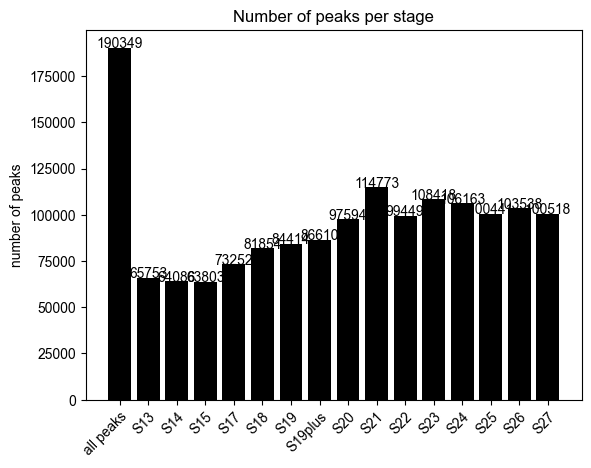

In [6]:
plt.bar(results_summed.keys(), results_summed.values(), color = 'k')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
addlabels(results_summed.keys(), list(results_summed.values()))

plt.title('Number of peaks per stage')
plt.ylabel('number of peaks')
plt.savefig('OmniATAC_numpeaks_perstage_new.svg')
plt.show()



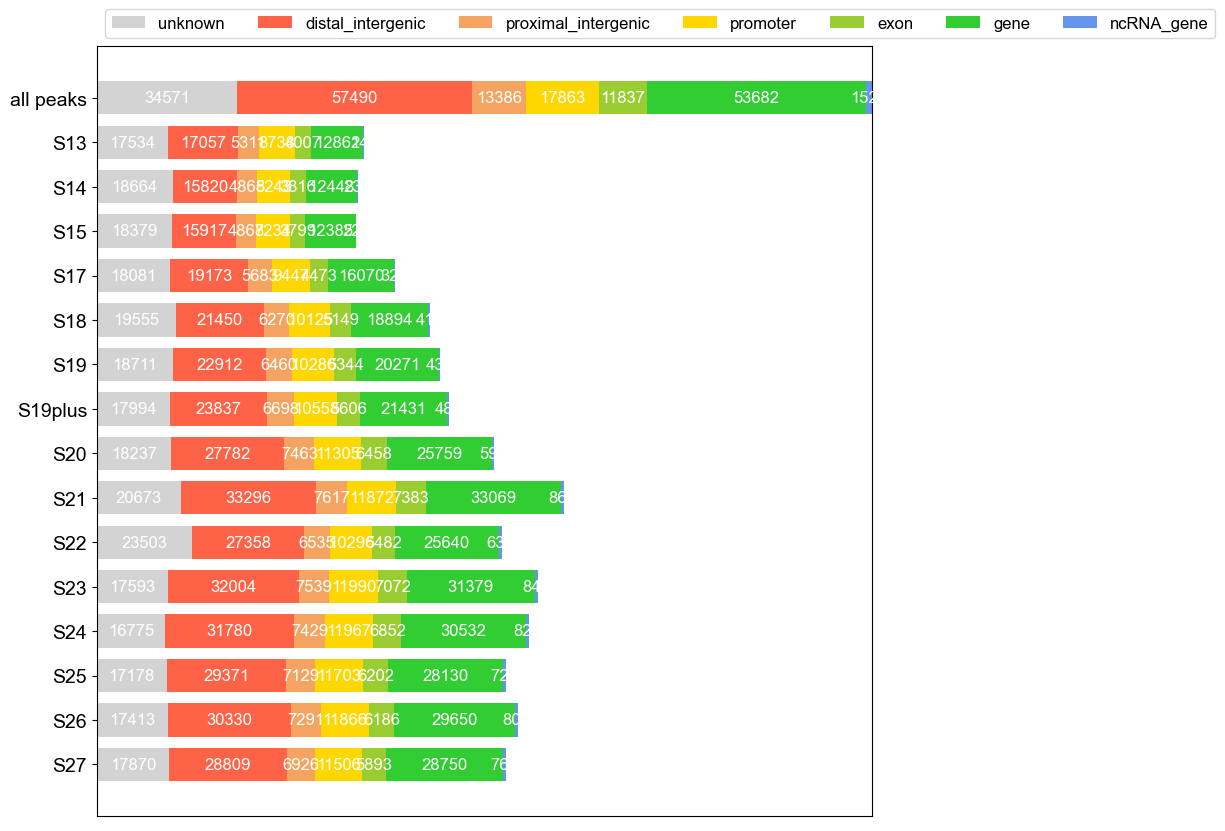

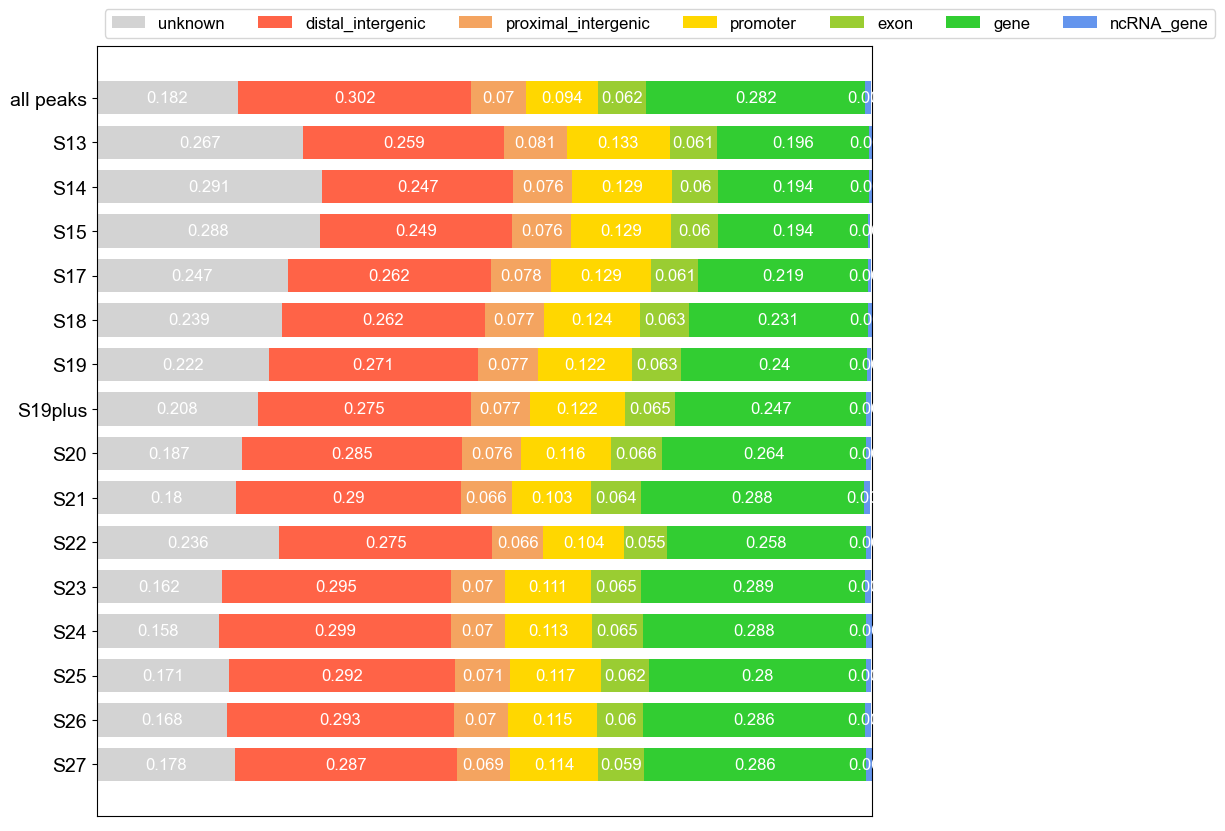

In [7]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = ['lightgray', 'tomato', 'sandybrown', 'gold', 'yellowgreen', 'limegreen', 'cornflowerblue', 'mediumslateblue']

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.75,
                        label=colname, color=color)

        text_color = 'white'
        ax.bar_label(rects, label_type='center', color=text_color, fontsize = 12)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize= 12)
    plt.yticks(fontsize = 14)

    return fig, ax

plt.rcParams.update(plt.rcParamsDefault)
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
plt.rcParams.update(new_rc_params)

sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

survey(results, category_names)
plt.savefig('OmniATAC_peaktype_absolute_bystage_new.svg')
plt.show()

survey(results_fraction, category_names)
plt.savefig('OmniATAC_peaktype_bystage_new.svg')
plt.show()

,0,1,2,3,4,5,6,7,8,9,10
84631,phaw_50.000009,proximal_intergenic,phaw_50.000009_11629_11888,11629,11888,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=269.657501;-log10(p)_MAX=5.01003;-log10(p)_MIN=5.01003;-log1...,+,.,1,mikado.phaw_50.000009G1,-1116.0
84632,phaw_50.000023,proximal_intergenic,phaw_50.000023_12096_12730,12096,12730,COUNT=15;SCORE_MEAN=956.7333333;SIGNAL_MEAN=526.3169403;-log10(p)_MAX=6.819659;-log10(p)_MIN=4.8...,+,.,15,mikado.phaw_50.000023G2,7768.0
84633,phaw_50.000023,proximal_intergenic,phaw_50.000023_87809_88060,87809,88060,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=631.877686;-log10(p)_MAX=7.602784;-log10(p)_MIN=7.602784;-lo...,+,.,1,mikado.phaw_50.000023G3,-5597.0
84634,phaw_50.000023,proximal_intergenic,phaw_50.000023_90731_91181,90731,91181,COUNT=4;SCORE_MEAN=680.5;SIGNAL_MEAN=296.6584663;-log10(p)_MAX=4.658824;-log10(p)_MIN=4.162148;-...,+,.,4,mikado.phaw_50.000023G3,-8519.0
84635,phaw_50.000025,proximal_intergenic,phaw_50.000025_45804_46262,45804,46262,COUNT=1;SCORE_MEAN=812;SIGNAL_MEAN=372.577393;-log10(p)_MAX=4.034373;-log10(p)_MIN=4.034373;-log...,+,.,1,mikado.phaw_50.000025G2,5727.0
...,...,...,...,...,...,...,...,...,...,...,...
155502,phaw_50.283875b,distal_intergenic,phaw_50.283875b_1477585_1478169,1477585,1478169,COUNT=7;SCORE_MEAN=959.8571429;SIGNAL_MEAN=486.7580914;-log10(p)_MAX=6.537003;-log10(p)_MIN=4.93...,+,.,7,mikado.phaw_50.283875bG11,-67955.0
155503,phaw_50.283875b,distal_intergenic,phaw_50.283875b_1535467_1535680,1535467,1535680,COUNT=2;SCORE_MEAN=1000;SIGNAL_MEAN=223.467064;-log10(p)_MAX=5.899739;-log10(p)_MIN=5.556468;-lo...,+,.,2,mikado.phaw_50.283875bG13,-16091.0
155504,phaw_50.283875b,distal_intergenic,phaw_50.283875b_1546842_1547714,1546842,1547714,COUNT=13;SCORE_MEAN=926.4615385;SIGNAL_MEAN=1193.281705;-log10(p)_MAX=11.16451;-log10(p)_MIN=4.8...,+,.,13,mikado.phaw_50.283875bG13,-27466.0
155505,phaw_50.283875b,distal_intergenic,phaw_50.283875b_1548469_1548807,1548469,1548807,COUNT=1;SCORE_MEAN=1000;SIGNAL_MEAN=384.672821;-log10(p)_MAX=5.47358;-log10(p)_MIN=5.47358;-log1...,+,.,1,mikado.phaw_50.283875bG13,-29093.0


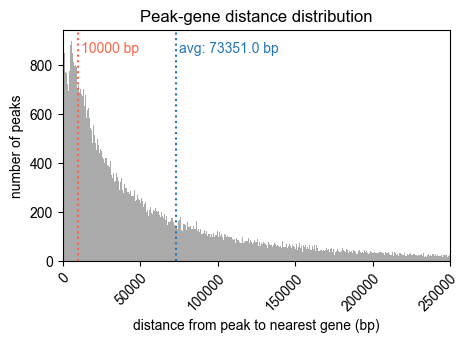

In [48]:
peak_classes = pd.DataFrame(pd.read_csv("~/Labwork/Bioinformatics/Transcripts/" + "Sall_peaktypes_distances_new.gff", sep = '\t', header = None))
peak_classes = peak_classes[peak_classes[10].notna()]
peak_classes = peak_classes[peak_classes[10] != -1]
display(peak_classes)

distances_list = [abs(x) for x in peak_classes[10]]
distances_average = np.round(np.mean(distances_list), 0)

plt.figure(figsize = (5, 3))

plt.hist(distances_list, bins = 2000, color = '#AAAAAA')
ax = plt.gca()
ylims = ax.get_ylim()

plt.vlines(10000, 0, 4000, color = 'tomato', linestyle = 'dotted')
plt.text(10000 + 2000, 850, str(10000) + ' bp', color = 'tomato')
plt.vlines(distances_average, 0, 4000, color = 'tab:blue', linestyle = 'dotted')
plt.text(distances_average + 2000, 850, "avg: " + str(distances_average) + ' bp', color = 'tab:blue')
plt.ylim(ylims)
plt.xlim((0, 250000))
plt.xlabel('distance from peak to nearest gene (bp)')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.ylabel('number of peaks')
plt.title('Peak-gene distance distribution')

plt.savefig('OmniATAC_peak-gene_distance_distribution_new.svg')

plt.show()

{'all peaks': [0.182, 0.302, 0.07, 0.094, 0.062, 0.282, 0.008],
 'S13': [0.267, 0.259, 0.081, 0.133, 0.061, 0.196, 0.004],
 'S14': [0.291, 0.247, 0.076, 0.129, 0.06, 0.194, 0.004],
 'S15': [0.288, 0.249, 0.076, 0.129, 0.06, 0.194, 0.003],
 'S17': [0.247, 0.262, 0.078, 0.129, 0.061, 0.219, 0.004],
 'S18': [0.239, 0.262, 0.077, 0.124, 0.063, 0.231, 0.005],
 'S19': [0.222, 0.271, 0.077, 0.122, 0.063, 0.24, 0.005],
 'S19plus': [0.208, 0.275, 0.077, 0.122, 0.065, 0.247, 0.006],
 'S20': [0.187, 0.285, 0.076, 0.116, 0.066, 0.264, 0.006],
 'S21': [0.18, 0.29, 0.066, 0.103, 0.064, 0.288, 0.008],
 'S22': [0.236, 0.275, 0.066, 0.104, 0.055, 0.258, 0.006],
 'S23': [0.162, 0.295, 0.07, 0.111, 0.065, 0.289, 0.008],
 'S24': [0.158, 0.299, 0.07, 0.113, 0.065, 0.288, 0.008],
 'S25': [0.171, 0.292, 0.071, 0.117, 0.062, 0.28, 0.007],
 'S26': [0.168, 0.293, 0.07, 0.115, 0.06, 0.286, 0.008],
 'S27': [0.178, 0.287, 0.069, 0.114, 0.059, 0.286, 0.008]}

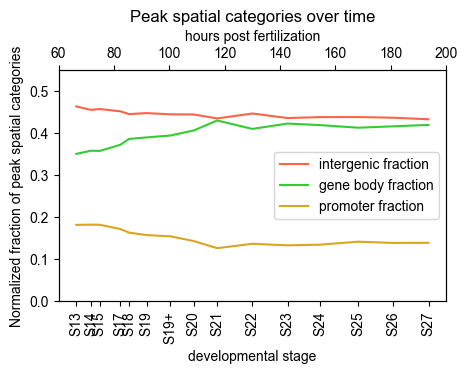

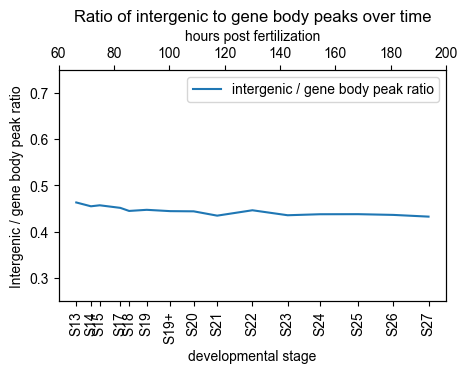

In [57]:
display(results_fraction)

times = [72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192]

intergenic_total = [sum(results_fraction[s][1:3]) / sum(results_fraction[s][1:]) for s in results_fraction]
promoter_total = [results_fraction[s][3] / sum(results_fraction[s][1:]) for s in results_fraction]
gene_body_total = [sum(results_fraction[s][4:6] / sum(results_fraction[s][1:])) for s in results_fraction]

plt.figure(figsize = (5, 3))

plt.plot(times, intergenic_total[1:], label = 'intergenic fraction', color = 'tomato')
plt.plot(times, gene_body_total[1:], label = 'gene body fraction', color = 'limegreen')
plt.plot(times, promoter_total[1:], label = 'promoter fraction', color = 'goldenrod')
plt.legend(loc = 'best')
plt.title('Peak spatial categories over time')
plt.ylabel('Normalized fraction of peak spatial categories')
plt.xlabel('developmental stage')
plt.xticks([72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192], ['S13', 'S14', 'S15', 'S17', 'S18', 'S19', 'S19+', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27'], rotation = 'vertical')

plt.ylim(0, 0.55)

ax2range = [i for i in range(60, 220, 20)]
ax2 = plt.twiny()
ax2.set_xticks([(i - 60) / (200 - 60) for i in ax2range])
ax2.set_xticklabels(ax2range)
ax2.set_xlabel('hours post fertilization')

plt.savefig('Omni-ATAC_normalized_peakfractions.svg')

plt.show()



intergenic_vs_gene_body_ratio = [i / j for i in intergenic_total for j in gene_body_total]
plt.figure(figsize = (5, 3))
plt.plot(times, intergenic_total[1:], label = 'intergenic / gene body peak ratio', color = 'tab:blue')
plt.legend(loc = 'best')
plt.title('Ratio of intergenic to gene body peaks over time')
plt.ylabel('Intergenic / gene body peak ratio')
plt.xlabel('developmental stage')
plt.xticks([72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192], ['S13', 'S14', 'S15', 'S17', 'S18', 'S19', 'S19+', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27'], rotation = 'vertical')

plt.ylim(0.25, 0.75)

ax2range = [i for i in range(60, 220, 20)]
ax2 = plt.twiny()
ax2.set_xticks([(i - 60) / (200 - 60) for i in ax2range])
ax2.set_xticklabels(ax2range)
ax2.set_xlabel('hours post fertilization')

plt.savefig('Omni-ATAC_peakratio.svg')

plt.show()